<div align="center">

# **Implementing Reinforcement Learning Agents with Stable-Baselines3**

### **Academic Year: 2025 / 2026**

---

### **Group Members**

| Name | Student Number |
|------|----------------|
| João Pedro Nunes Rocha | up202306599 |
| Paulo Diogo Lopes Pinto | up202306412 |
| Rui Filipe Rocha Alvarilhão | up202209989 |

---

_Faculdade de Ciências da Universidade do Porto (FCUP)_  
_Licenciatura em Inteligência Artificial e Ciência de Dados (IACD)_

</div>

# Introdução

Escrever uma introdução

In [1]:
# 1. Standard Library
import os
import gc

# 2. Scientific Computing & Data Processing
import numpy as np
import torch

# 3. Image Processing & Visualization
import cv2
import matplotlib.pyplot as plt
import imageio

from IPython.display import Image, display

# 4. Gymnasium & Atari (ALE)
import gymnasium as gym
import ale_py
from gymnasium import spaces
from gymnasium.utils.play import play

# 5. Reinforcement Learning Algorithms
from stable_baselines3 import PPO
from sb3_contrib import QRDQN

# 6. Stable Baselines3 – Environments & Wrappers
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    SubprocVecEnv,
    VecFrameStack
)

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed

# 7. Logging & Evaluation
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 8. Interaction & Rendering
import pygame

/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


# 1) Seleção do Ambiente: Assault

Para este trabalho de aprendizagem por reforço, foi escolhido o ambiente **Assault** da suite Atari disponível no Gymnasium. O Assault é um jogo arcade clássico onde o agente controla um veículo na parte inferior do ecrã e deve destruir naves inimigas enquanto evita projéteis. Este ambiente é particularmente interessante para RL devido à sua natureza altamente dinâmica e ao equilíbrio constante entre duas dimensões de comportamento:

* **Estratégias ofensivas**: maximizar pontuação através da destruição de inimigos.
* **Manobras defensivas**: posicionamento e esquiva de projéteis para prolongar a sobrevivência.

Além da fluidez da jogabilidade, o sistema de pontuação, os padrões de movimento dos inimigos, a aleatoriedade dos spawns e a mecânica de projéteis criam um espaço rico para explorar diferentes técnicas de engenharia de recompensas e wrappers. Em particular, o facto da arma sofrer overheat quando o agente dispara continuamente introduz uma restrição relevante: o agente precisa de aprender a gerir recursos (tempo de disparo) e a otimizar o timing entre atacar e desviar, evitando penalizações indiretas por ficar temporariamente incapaz de disparar.

Do ponto de vista de RL, o Assault oferece:

* **Observação visual complexa** (pixels), com ruído e elementos em movimento, ideal para testar preprocessamento como grayscale, normalização e stacking de frames para capturar dinâmica temporal.
* **Espaço de ações discreto** com semântica clara (mover, disparar, ficar parado), permitindo analisar como a política aprende combinações de movimento e ataque.
* **Densidade variável de objetos em cena** (inimigos, tiros, partículas de explosão), que pode ser usada para construir penalizações informativas (ex.: contagem de blobs) e observar o efeito de diferentes estratégias de recompensa na política aprendida.

Este ambiente é também adequado para estudar:

* O impacto de **reward shaping** no comportamento (ex.: penalizações por disparo excessivo, penalização por morte, pequena penalização por frame para incentivar decisões eficientes).
* Efeitos de **wrappers visuais e wrappers semânticos** (ex.: conversão para grayscale com ruído, contagem heurística de inimigos através de componentes conectados).
* Diferenças entre algoritmos **on-policy** (como PPO) e **off-policy** (como QR-DQN) em cenários baseados em pixels com elevada variabilidade temporal.

Por fim, a combinação de tomada de decisão em tempo real, restrições de ataque (overheat), necessidade de posicionamento e leitura visual de padrões torna o Assault um excelente caso de estudo para perceber como modificações no ambiente e na função de recompensa afetam a aprendizagem, a estabilidade do treino e a generalização da política.

In [2]:
# Regista os ambientes Atari (ALE) no Gymnasium
gym.register_envs(ale_py)

# Cria o ambiente Assault da suite Atari
env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
print("Ambiente Assault carregado com sucesso!")

Ambiente Assault carregado com sucesso!


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [48]:
# Criar ambiente
env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
meanings = env.unwrapped.get_action_meanings()

# Função para ir buscar o ID da ação sem dar erro
def get_id(name):
    return meanings.index(name) if name in meanings else 0

keys_to_action = {
    # --- MOVIMENTO ---
    (pygame.K_LEFT,): get_id("LEFT"),
    (pygame.K_RIGHT,): get_id("RIGHT"),

    # --- DISPARO CENTRAL (TESTE DUPLO) ---
    # Tenta disparar com o ESPAÇO (usa a ação FIRE)
    (pygame.K_UP,): get_id("UP"),
    
    # --- COMBOS (Mover e Disparar) ---
    (pygame.K_LEFT, pygame.K_SPACE): get_id("LEFTFIRE"),
    (pygame.K_RIGHT, pygame.K_SPACE): get_id("RIGHTFIRE"),
}


play(
    env,
    keys_to_action=keys_to_action,
    noop=get_id("NOOP"),
    zoom=4,
    fps=30
)

env.close()

# 2) Wrappers Personalizados

## O que são Wrappers?

Wrappers são uma funcionalidade fundamental do Gymnasium que permite modificar o comportamento de um ambiente sem alterar o código original do ambiente base. Funcionam como "camadas" que envolvem um ambiente existente, interceptando e modificando observações, ações, recompensas ou outros aspetos da interação agente-ambiente.

A arquitetura de wrappers segue o padrão de design **Decorator Pattern**, onde cada wrapper:
- Recebe um ambiente como input
- Expõe a mesma interface do ambiente original
- Pode modificar qualquer aspeto da interação (observações, ações, recompensas, flags de terminação, etc.)
- Pode ser composto com outros wrappers de forma modular

## Vantagens da Abordagem com Wrappers

A utilização de wrappers oferece várias vantagens:

**Modularidade**: Cada wrapper implementa uma transformação específica, facilitando a manutenção e reutilização.

**Flexibilidade**: É fácil adicionar, remover ou reordenar wrappers para experimentar diferentes configurações.

**Não-invasivo**: O código original do ambiente permanece intocado, evitando bugs e facilitando atualizações.

**Experimentação**: Permite testar rapidamente o impacto de diferentes preprocessamentos e reward shaping no desempenho do agente.

**Reprodutibilidade**: Ao documentar a sequência de wrappers aplicados, é fácil reproduzir exatamente as mesmas condições experimentais.

## 2.1)  Assault Visual Wrapper

### O que este wrapper faz

* Converte observações RGB para grayscale (1 canal) mantendo a resolução original.
* Opcionalmente adiciona ruído gaussiano controlado por `noise_level`.
* Atualiza o `observation_space` para `Box(..., shape=(H, W, 1), dtype=np.uint8)`.
* Não altera recompensas, ações ou lógica do ambiente. Apenas pré-processa a imagem.

### Por que usar este wrapper apenas na avaliação

**Avaliação limpa**: Durante o EvalCallback, o objetivo é medir desempenho real do agente sem "reward shaping" ou penalizações adicionais. Este wrapper não afeta na recompensa, garante que a avaliação reflete o ambiente base.

**Consistência de entrada**: O agente foi treinado a consumir imagens preprocessadas (grayscale, frame stacking). Na avaliação, precisa do mesmo formato visual para não criar um "mismatch" com a política treinada, mas sem tocar na recompensa.

**Comparabilidade**: Manter a reward do ambiente padrão durante testes torna resultados comparáveis entre diferentes configurações de treino.

### Por que não usar o mesmo wrapper em treino e teste (quando há reward shaping)

**Evitar "leak" de reward shaping**: Wrappers de treino como `CustomAssaultWrapper` e `CustomAssaultWrapperEnemies` modificam recompensas (living/shoot/death/enemy penalties). Em teste, isso enviesaria a medição de performance.

**Separação de responsabilidades**:
* **Treino**: pode incluir penalizações/heurísticas para guiar aprendizagem (ex.: densidade de inimigos, custo de disparo).
* **Teste**: usa apenas preprocessamento visual para que a política veja o mesmo tipo de observação, mas em ambiente com recompensa original.

**Prevenção de deslocamento de distribuição**: Manter o mesmo pipeline visual (grayscale + frame stack) mas sem ruído extra ou mudanças de reward no teste evita que o agente enfrente um cenário diferente do que aprendeu, preservando validade da avaliação.

### Resumo

* **Treino**: Wrappers com reward shaping podem acelerar/estabilizar aprendizagem.
* **Teste**: AssaultVisualWrapper aplica somente transformação visual, mantendo recompensas originais, garantindo avaliação justa e consistente com a entrada esperada pela rede.

In [2]:
class AssaultVisualWrapper(gym.Wrapper):
    """
    Wrapper visual para o ambiente Atari Assault.

    Funcionalidades:
    - Converte observações RGB para grayscale (1 canal)
    - Opcionalmente adiciona ruído Gaussiano à observação
    - Mantém os valores no intervalo [0, 255] como uint8

    Este wrapper é útil para:
    - Reduzir a dimensionalidade do estado
    - Forçar o agente a aprender características mais robustas
    - Regularização visual (quando usado com ruído)
    """
    def __init__(self, env, noise_level=0):
        """
        Inicializa o wrapper.

        Parameters
        ----------
        env : gym.Env
            Ambiente base (ex: ALE/Assault-v5).
        noise_level : float, optional
            Desvio padrão do ruído Gaussiano aplicado à observação.
            Se 0, não é adicionado ruído (default=0).
        """
        super().__init__(env)
        self.noise_level = noise_level
        # Forma original da observação (H, W, 3)
        old_shape = env.observation_space.shape
        # Nova forma com apenas 1 canal (grayscale)
        new_shape = (old_shape[0], old_shape[1], 1)
        # Atualiza o espaço de observação
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        """
        Converte uma imagem RGB para grayscale.

        Usa a ponderação padrão perceptual:
        0.299 * R + 0.587 * G + 0.114 * B

        Parameters
        ----------
        obs : np.ndarray
            Observação RGB com shape (H, W, 3).

        Returns
        -------
        np.ndarray
            Observação grayscale com shape (H, W, 1) e dtype uint8.
        """
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1) # Adiciona o canal explícito (H, W, 1)
        return gray.astype(np.uint8)

    def step(self, action):
        """
        Executa uma ação no ambiente e processa a observação.

        Parameters
        ----------
        action : int
            Ação a executar no ambiente.

        Returns
        -------
        obs : np.ndarray
            Observação grayscale (com ruído opcional).
        reward : float
            Recompensa recebida.
        terminated : bool
            Indica se o episódio terminou (estado terminal).
        truncated : bool
            Indica se o episódio foi truncado (ex: limite de tempo).
        info : dict
            Informação adicional do ambiente.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)
        gray_obs = self._convert_to_grayscale(obs) # Converte para grayscale
        noise = np.random.normal(0, self.noise_level, gray_obs.shape) # Adiciona ruído Gaussiano (regularização visual)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8) # Evita overflow usando int16 antes do clip
        return noisy_obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        """
        Reinicia o ambiente e processa a observação inicial.

        Returns
        -------
        obs : np.ndarray
            Observação inicial em grayscale (com ruído opcional).
        info : dict
            Informação adicional do ambiente.
        """
        obs, info = self.env.reset(**kwargs) 
        gray_obs = self._convert_to_grayscale(obs) # Converte para grayscale
        noise = np.random.normal(0, self.noise_level, gray_obs.shape) # Aplica ruído (se configurado)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        return noisy_obs, info

## 2.2) Custom Assault Wrapper

### O que este wrapper modifica

**Estado visual**: Converte RGB para grayscale (1 canal) e pode adicionar ruído controlado.

**Recompensa**:
* **Shooting penalty** por ação de fogo (ex.: -0.5) para desencorajar spam de tiros e gerir o overheat.
* **Death penalty** (ex.: -25) para reforçar fortemente a sobrevivência e a evasão.

### Por que pode ser bom

**Gestão de recursos (overheat)**: Penalizar "FIRE" ensina o agente a disparar com moderação e timing, aumentando eficácia por tiro.

**Robustez e segurança**: A death penalty torna a sobrevivência central, reduz comportamentos kamikaze e melhora posicionamento e esquiva.

**Sinal de treino mais informativo**: O reward shaping oferece feedback denso e direcionado, acelerando a aprendizagem em ambientes com recompensas esparsas.

**Simplificação visual**: Grayscale reduz ruído de cor e custo computacional, focando a rede em formas/movimento relevantes.

**Regularização leve**: O ruído gaussiano pode melhorar generalização, tornando a política menos sensível a variações da imagem.

### Nota sobre "só retirar pontos"

As nossas penalizações não visam "retirar" a motivação de pontuar; servem para orientar o comportamento entre decisões. A reward base do Assault já incentiva matar inimigos (pontos por destruição). O shaping introduz custos operacionais (tempo vivo, tiros, mortes) para equilibrar agressividade e eficiência, sem competir com a recompensa principal do ambiente.

In [ ]:
class CustomAssaultWrapper(gym.Wrapper):
    """
    Wrapper personalizado para o ambiente Atari Assault.

    Modificações introduzidas:

    1. Espaço de Estados (Visual):
       - Conversão de RGB para grayscale (1 canal)
       - Adição opcional de ruído Gaussiano (regularização visual)

    2. Reward Shaping:
       - Penalização ao disparar (shot penalty)
       - Penalização forte quando o agente perde uma vida (death penalty)

    Este wrapper é útil para:
    - Reduzir a dimensionalidade do input visual
    - Desencorajar tiros aleatórios
    - Incentivar comportamentos focados na sobrevivência
    """
    def __init__(self, env, noise_level=0, 
                 shot_penalty=-0.5, 
                 death_penalty=-25):
        """
        Inicializa o wrapper.

        Parameters
        ----------
        env : gym.Env
            Ambiente base (ex: ALE/Assault-v5).
        noise_level : float, optional
            Desvio padrão do ruído Gaussiano aplicado à observação.
            Se 0, não é aplicado ruído (default=0).
        shot_penalty : float, optional
            Penalização adicionada sempre que a ação envolve disparar.
        death_penalty : float, optional
            Penalização aplicada quando o agente perde uma vida.
        """
        
        super().__init__(env)
        self.noise_level = noise_level
        self.shot_penalty = shot_penalty
        self.death_penalty = death_penalty
        
        self.action_meanings = env.unwrapped.get_action_meanings() # Lista de nomes das ações do ambiente (ex: 'FIRE', 'LEFTFIRE', etc.)
        self.lives = 4 # Número de vidas atual do agente
        
        # --- ATUALIZAÇÃO DO ESPAÇO DE ESTADOS ---
        # De (H, W, 3) para (H, W, 1)
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        """
        Converte uma observação RGB para grayscale.

        Parameters
        ----------
        obs : np.ndarray
            Observação RGB com shape (H, W, 3).

        Returns
        -------
        np.ndarray
            Observação grayscale com shape (H, W, 1) e dtype uint8.
        """
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1) # Expande dimensão para manter compatibilidade com CNNs
        return gray.astype(np.uint8)

    def step(self, action):
        """
        Executa uma ação no ambiente, aplica reward shaping
        e processa a observação visual.

        Parameters
        ----------
        action : int
            Índice da ação a executar.

        Returns
        -------
        obs : np.ndarray
            Observação grayscale (com ruído opcional).
        reward : float
            Recompensa modificada após reward shaping.
        terminated : bool
            Indica se o episódio terminou (estado terminal).
        truncated : bool
            Indica se o episódio foi truncado (ex: limite de tempo).
        info : dict
            Informação adicional do ambiente.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Recompensa original
        modified_reward = reward
        
        # 1. Penalidade de Tiro
        action_name = self.action_meanings[action]
        if "FIRE" in action_name:
            modified_reward += self.shot_penalty
            
        # 2. Penalidade de Morte
        current_lives = info.get("lives", 0)
        if current_lives < self.lives:
            modified_reward += self.death_penalty
        self.lives = current_lives # Atualiza número de vidas
            
        # --- PROCESSAMENTO DO ESTADO ---
        gray_obs = self._convert_to_grayscale(obs) 
        noise = np.random.normal(0, self.noise_level, gray_obs.shape) # Ruído Gaussiano para regularização visual
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8) # Evita overflow antes do clip
        
        return noisy_obs, modified_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """
        Reinicia o ambiente e inicializa o estado interno do wrapper.

        Returns
        -------
        obs : np.ndarray
            Observação inicial em grayscale (com ruído opcional).
        info : dict
            Informação adicional do ambiente.
        """
        obs, info = self.env.reset(**kwargs)
        self.lives = info.get("lives", 0) # Inicializa o número de vidas
        
        gray_obs = self._convert_to_grayscale(obs) # Processamento visual inicial
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, info

## 2.3) Custom Assault Wrapper Enemies

### O que este wrapper modifica

**Estado visual**: Grayscale (1 canal) + ruído opcional; ajusta o observation_space para (H, W, 1).

**Reward shaping**:
* **Shooting penalty** por "FIRE" (ex.: -0.5).
* **Death penalty** ao perder vida (ex.: -25).
* **Enemy Count penalty**: Penalização proporcional ao número de inimigos detetados na ROI, via connected components e filtros geométricos (área, aspect ratio).

### Deteção de inimigos (como funciona)

* Recorta a ROI do jogo onde surgem inimigos (y: 42–184).
* Converte para binário e aplica connectedComponentsWithStats.
* Filtra blobs não plausíveis (explosões grandes, nave-mãe muito larga, tiros verticais finos, ruído muito pequeno).
* Conta blobs que passam nos critérios e usa count para calcular a penalização: `enemy_penalty = count × enemy_penalty_factor`.

### Por que pode ser bom

**Pressão tática**: Penalizar frames com muitos inimigos incentiva o agente a reduzir a "densidade" (matar rápido, reposicionar melhor), evitando acumular ameaças.

**Gestão de risco**: Combina death penalty e enemy penalty para reforçar sobrevivência ativa, privilegiando posicionamento e foco em alvos relevantes.

**Sinal mais denso**: Fornece feedback adicional mesmo quando a reward base é esparsa, acelerando aprendizagem de heurísticas defensivas/ofensivas.

**Robustez visual**: Grayscale simplifica a entrada e ruído leve pode melhorar generalização.

### Nota sobre "só retirar pontos"

As penalizações não existem para "retirar" a motivação de pontuar. A reward base do Assault já recompensa destruir inimigos. O nosso shaping adiciona custos operacionais (tiros, mortes, alta densidade em ecrã) para guiar eficiência e segurança, mantendo o objetivo principal: maximizar pontos ao eliminar inimigos com melhor timing e posicionamento.

In [26]:
class CustomAssaultWrapperEnemies(gym.Wrapper):
    """
    Wrapper personalizado para o ambiente Atari Assault com deteção explícita
    de inimigos baseada em visão computacional.

    Modificações introduzidas:

    1. Espaço de Estados (Visual):
       - Conversão de RGB para grayscale (1 canal)
       - Adição opcional de ruído Gaussiano (regularização visual)

    2. Reward Shaping:
       - Penalização por disparar (shot penalty)
       - Penalização forte quando o agente perde uma vida (death penalty)
       - Penalização proporcional ao número de inimigos visíveis no ecrã
         (enemy count penalty)

    Este wrapper é útil para:
    - Forçar o agente a gerir risco com base no número de inimigos
    - Aproximar sinais semânticos (densidade inimiga) ao reward
    - Reduzir overfitting visual via ruído
    """
    def __init__(self, env, min_blob_area=20,
                 noise_level=0,  
                 shot_penalty=-0.5, 
                 death_penalty=-25,
                 enemy_penalty_factor=-0.1): 
        """
        Inicializa o wrapper.

        Parameters
        ----------
        env : gym.Env
            Ambiente base (ex: ALE/Assault-v5).
        min_blob_area : int, optional
            Área mínima para um blob ser considerado inimigo.
        noise_level : float, optional
            Desvio padrão do ruído Gaussiano aplicado à observação.
        shot_penalty : float, optional
            Penalização aplicada quando a ação envolve disparar.
        death_penalty : float, optional
            Penalização aplicada quando o agente perde uma vida.
        enemy_penalty_factor : float, optional
            Fator multiplicativo da penalização por inimigo detetado.
        """
        super().__init__(env)
        self.min_blob_area = min_blob_area
        self.noise_level = noise_level
        self.shot_penalty = shot_penalty
        self.death_penalty = death_penalty
        self.enemy_penalty_factor = enemy_penalty_factor
        
        self.action_meanings = env.unwrapped.get_action_meanings() # Nomes semânticos das ações (ex: 'FIRE', 'LEFTFIRE', etc.)
        self.lives = 4 # Controlo interno do número de vidas
        
        # --- ATUALIZAÇÃO DO STATE SPACE ---
        # De (H, W, 3) para (H, W, 1)
        old_shape = env.observation_space.shape
        new_shape = (old_shape[0], old_shape[1], 1)
        self.observation_space = spaces.Box(low=0, high=255, shape=new_shape, dtype=np.uint8)

    def _convert_to_grayscale(self, obs):
        """
        Converte uma observação RGB para grayscale.

        Parameters
        ----------
        obs : np.ndarray
            Observação RGB com shape (H, W, 3).

        Returns
        -------
        np.ndarray
            Observação grayscale com shape (H, W, 1).
        """
        gray = np.dot(obs[..., :3], [0.299, 0.587, 0.114])
        gray = np.expand_dims(gray, axis=-1) # Mantém dimensão explícita do canal
        return gray.astype(np.uint8)

    def _count_enemies(self, obs):
        """
        Estima o número de inimigos visíveis no ecrã através de
        deteção de blobs (Connected Components).

        A deteção é feita numa região de interesse (ROI) específica
        onde os inimigos aparecem com maior frequência.

        Filtros aplicados:
        - Área mínima e máxima
        - Aspect ratio (largura / altura)
        - Heurísticas específicas do Assault (explosões, tiros, nave mãe)

        Parameters
        ----------
        obs : np.ndarray
            Observação RGB original.

        Returns
        -------
        int
            Número estimado de inimigos detetados.
        """

        # Região de interesse (exclui HUD e bordas)
        y_start, y_end = 42, 184
        roi = obs[y_start:y_end, :, :]
        
        # Conversão para binário para detetar blobs
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray_roi, 10, 255, cv2.THRESH_BINARY)
        
        # Análise de componentes conectados
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        enemy_count = 0
        
        # Itera sobre todos os blobs (ignora o label 0 = fundo)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            aspect_ratio = float(w) / h
            
            is_enemy = True

            # --- LÓGICA DE FILTRO (Trazida do GodMode) ---
            if area > 400: 
                is_enemy = False # Muito grande (provavelmente explosão ou UI bugada)
            elif aspect_ratio > 3.5: 
                is_enemy = False # Muito largo (Nave mãe no topo)
            elif aspect_ratio < 0.2: 
                is_enemy = False # Muito fino (Tiro vertical)
            elif area < self.min_blob_area:
                # Lógica de recuperação: Se for pequeno, mas QUADRADO, é inimigo.
                if area > 8 and (0.5 < aspect_ratio < 2.0):
                     is_enemy = True 
                else:
                    is_enemy = False

            if is_enemy:
                enemy_count += 1

        # Ajuste empírico (remove falso positivo recorrente)
        return max(0, enemy_count -1)

    def step(self, action):
        """
        Executa uma ação no ambiente, aplica reward shaping avançado
        e processa a observação visual.

        Parameters
        ----------
        action : int
            Índice da ação a executar.

        Returns
        -------
        obs : np.ndarray
            Observação grayscale (com ruído opcional).
        reward : float
            Recompensa total após reward shaping.
        terminated : bool
            Indica se o episódio terminou.
        truncated : bool
            Indica se o episódio foi truncado.
        info : dict
            Informação adicional (inclui contagem de inimigos).
        """

        obs, reward, terminated, truncated, info = self.env.step(action)
        
        modified_reward = reward
        
        # 1. Penalidade de Tiro
        action_name = self.action_meanings[action]
        if "FIRE" in action_name:
            modified_reward += self.shot_penalty
            
        # 2. Penalidade de Morte
        current_lives = info.get("lives", 0)
        if current_lives < self.lives:
            modified_reward += self.death_penalty
        self.lives = current_lives
        
        # 3. Penalidade por Quantidade de Inimigos (Lógica Nova)
        num_enemies = self._count_enemies(obs)
        
        # Penalidade = num_inimigos * fator (ex: 3 inimigos * -0.1 = -0.3)
        enemy_penalty = num_enemies * self.enemy_penalty_factor
        modified_reward += enemy_penalty
        
        # Adicionar info útil para debug/logging se necessário
        info['enemy_count'] = num_enemies
            
        # --- STATE SPACE ---
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, modified_reward, terminated, truncated, info

    def reset(self, **kwargs):
        """
        Reinicia o ambiente e o estado interno do wrapper.

        Returns
        -------
        obs : np.ndarray
            Observação inicial em grayscale (com ruído opcional).
        info : dict
            Informação adicional do ambiente.
        """
        obs, info = self.env.reset(**kwargs)
        self.lives = info.get("lives", 0) # Reinicia o número de vidas

        # Processamento visual inicial        
        gray_obs = self._convert_to_grayscale(obs)
        noise = np.random.normal(0, self.noise_level, gray_obs.shape)
        noisy_obs = np.clip(gray_obs.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        return noisy_obs, info

# 3) PPO (Proximal Policy Optimization)

O **Proximal Policy Optimization (PPO)** é um algoritmo de aprendizagem por reforço da família **Policy Gradient**, desenvolvido pela OpenAI em 2017. É considerado o **estado-da-arte** para muitas tarefas de RL devido ao seu equilíbrio entre **simplicidade de implementação**, **eficiência amostral** e **estabilidade de treino**.

O PPO pertence à classe de algoritmos **on-policy**, o que significa que aprende diretamente a partir das experiências que recolhe seguindo a sua política atual, sem reutilizar dados antigos de forma agressiva (ao contrário de algoritmos **off-policy** como DQN).

## Características Principais

**Policy Gradient com Clipping**: O PPO limita (**clip**) a magnitude das atualizações da política para evitar mudanças bruscas que possam desestabilizar o treino. Isto garante que a nova política não se afaste demasiado da anterior, mantendo um **"trust region"** implícito.

**Actor-Critic Architecture**: O PPO usa duas redes neurais:
* **Actor**: Aprende a política (que ação tomar dado um estado).
* **Critic**: Estima a função de valor (quão bom é estar num determinado estado).

**Advantage Function**: O PPO usa a **Generalized Advantage Estimation (GAE)** para estimar o quão melhor uma ação é comparada com a média. Isto reduz a **variância do gradiente** e acelera a aprendizagem.

**Multiple Epochs per Batch**: Ao contrário de algoritmos mais simples como REINFORCE, o PPO **reutiliza os dados coletados** durante vários epochs de treino, aumentando a **eficiência amostral**.

## Por que escolhemos o PPO para o Assault?

### 1. Estabilidade e Robustez

O Assault é um ambiente com **recompensas esparsas** e **altamente variáveis** (pontos por destruir inimigos, penalizações por morte). O PPO é conhecido por ser **mais estável** que algoritmos como TRPO ou vanilla Policy Gradient, graças ao **mecanismo de clipping** que previne atualizações destrutivas.

### 2. Eficiência Amostral Razoável

Embora seja **on-policy** (menos eficiente que off-policy como DQN em termos de reuso de dados), o PPO compensa ao **treinar múltiplas vezes** sobre o mesmo batch de experiências. Isto é crucial em jogos Atari onde cada frame é **computacionalmente caro** de gerar.

### 3. Bom Desempenho em Ambientes Visuais

O PPO funciona bem com **observações de alta dimensão** (imagens) quando combinado com **redes convolucionais (CNNs)**. A arquitetura **`CnnPolicy`** do Stable-Baselines3 já vem otimizada para este tipo de input.

### 4. Flexibilidade com Reward Shaping

O nosso projeto usa **reward shaping extensivo** (shooting penalty, death penalty, enemy density). O PPO lida bem com **modificações na função de recompensa** sem exigir grandes ajustes nos hiperparâmetros, ao contrário de métodos mais sensíveis como Q-Learning.

### 5. Suporte a Ambientes Paralelos

O PPO beneficia enormemente de **treino paralelo** (múltiplos ambientes a correr em simultâneo). No nosso caso, usamos **`SubprocVecEnv`** com 2 ambientes, **duplicando a velocidade de recolha de dados** sem comprometer a estabilidade.

### 6. Interpretabilidade

Métricas como **`explained_variance`**, **`clip_fraction`** e **`approx_kl`** permitem diagnosticar facilmente problemas de treino (ex.: se a política está a divergir ou se o learning rate é demasiado alto).

In [28]:
def load_ppo(MODEL_PATH, vec_env, params, LOG_DIR):
    """
    Carrega ou cria um agente PPO para treino.

    Esta função verifica se existe um modelo PPO previamente treinado no 
    caminho indicado. Caso exista, o modelo é carregado e ligado ao ambiente 
    atual (`vec_env`). Caso não exista, é criado um novo agente com os 
    hiperparâmetros fornecidos.

    Parameters
    ----------
    MODEL_PATH : str
        Caminho para o ficheiro .zip do modelo PPO previamente treinado.
    
    vec_env : VecEnv
        Ambiente vetorizado (ex: SubprocVecEnv) onde o agente será treinado.
    
    params : dict
        Dicionário contendo os hiperparâmetros do PPO, como:
        - learning_rate
        - n_steps
        - batch_size
        - ent_coef
        - gamma
        - clip_range
    
    LOG_DIR : str
        Diretório onde serão guardados os logs do TensorBoard.

    Returns
    -------
    model : PPO
        Instância do agente PPO carregado ou recém-criado.

    reset_timesteps : bool
        - True  → inicia o treino do zero e reinicia o contador de timesteps.
        - False → continua o treino de um modelo antigo sem reiniciar timesteps.
    """   

    # Se o ficheiro existir, assume-se que é um modelo PPO previamente treinado
    if os.path.exists(MODEL_PATH):
        print(f"Encontrado modelo existente: {MODEL_PATH}")
        print("A carregar pesos e a continuar o treino...")
        
        # Carrega o modelo e liga-o ao ambiente atual
        model = PPO.load(MODEL_PATH, env=vec_env)
        
        # Como vamos continuar o treino, não queremos reiniciar os timesteps
        reset_timesteps = False 

    else:
        # Caso não exista modelo gravado, criamos um novo agente PPO
        print(f"Nenhum modelo encontrado com o nome: {MODEL_PATH}")
        print("A criar um novo agente do zero...")

        model = PPO(
            "CnnPolicy",        # Obrigatório para inputs de imagem (pixels)
            vec_env, 
            verbose=0,          # Define o nível de logging do PPO

            # Hiperparâmetros fornecidos no dicionário params
            learning_rate=params["learning_rate"],
            n_steps=params["n_steps"],
            batch_size=params["batch_size"],
            ent_coef=params["ent_coef"],
            gamma=params["gamma"],
            clip_range=params["clip_range"],

            tensorboard_log=LOG_DIR # Diretório para logs do TensorBoard
        )
        # Como é um modelo novo, reiniciamos o contador de timesteps
        reset_timesteps = True
    
    return model, reset_timesteps

# 4) QR-DQN (Quantile Regression Deep Q-Network)

O **Quantile Regression DQN (QR-DQN)** é uma extensão avançada do algoritmo **DQN (Deep Q-Network)**, desenvolvido pela DeepMind em 2017. Ao contrário do DQN clássico que aprende apenas o **valor médio esperado** de cada ação, o QR-DQN aprende a **distribuição completa dos retornos futuros** através de **regressão por quantis**.

O QR-DQN pertence à classe de algoritmos **off-policy**, o que significa que pode aprender a partir de **experiências passadas** armazenadas num **replay buffer**, sem necessitar de seguir a política atual durante a coleta de dados. Isto torna-o **significativamente mais eficiente** em termos de amostras que algoritmos on-policy.

## Características Principais

**Distributional RL**: Em vez de estimar Q(s,a) = E[retorno], o QR-DQN estima **múltiplos quantis** da distribuição de retornos (por defeito, **200 quantis**). Isto permite capturar **incerteza e variabilidade** nas recompensas.

**Quantile Huber Loss**: Utiliza uma **função de perda robusta** que penaliza erros de previsão de forma assimétrica, permitindo à rede aprender **diferentes percentis** da distribuição de valor.

**Replay Buffer**: Armazena **experiências passadas** (state, action, reward, next_state) e treina através de **amostragem aleatória** deste buffer, eleminando **correlações temporais** e aumentando drasticamente a **eficiência amostral**.

**Target Network**: Mantém uma **cópia "congelada"** da rede principal que é atualizada periodicamente. Isto **estabiliza os alvos de aprendizado** e previne **divergência catastrófica**.

**Epsilon-Greedy Exploration**: Equilibra **exploração** (ações aleatórias) e **exploitation** (ações ótimas) através de um epsilon que **decai ao longo do treino**.

## Por que escolhemos o QR-DQN para o Assault?

### 1. Eficiência Amostral Superior

O Assault requer **milhões de frames** para treinar. Como algoritmo **off-policy**, o QR-DQN **reutiliza cada transição múltiplas vezes** através do replay buffer, tornando cada frame obtido **muito mais valioso** que no PPO.

### 2. Robustez à Variabilidade de Recompensas

O Assault tem **recompensas altamente estocásticas** (pontos por destruir inimigos variam, timing de spawns é aleatório). O QR-DQN, ao modelar a **distribuição completa**, é naturalmente **mais robusto** a esta variabilidade que métodos baseados apenas na média.

### 3. Melhor Tratamento de Recompensas Esparsas

A abordagem **distribucional** permite ao QR-DQN distinguir entre **"estados seguros com baixa variância"** e **"estados arriscados com alta variância mas maior retorno esperado"**. Isto é crucial no Assault onde **decisões arriscadas** podem dar grandes pontuações ou morte rápida.

### 4. Adequação para Ambientes Visuais Complexos

Como o DQN original, o QR-DQN foi desenhado especificamente para **domínios Atari** com **observações em pixels**. A arquitetura **CNN padrão** já está otimizada para extrair **features espaciais relevantes** de imagens.

### 5. Estabilidade com Reward Shaping

O **replay buffer** e a **target network** tornam o QR-DQN relativamente **insensível a mudanças na função de recompensa**. Isto permite-nos experimentar agressivamente com penalizações (shot, death, enemy density) sem destabilizar completamente o treino.

### 6. Exploração Controlada

A estratégia **epsilon-greedy** com **decaimento linear** permite um equilíbrio explícito: nos primeiros **25% do treino** (exploration_fraction=0.25), o agente **explora intensamente**, depois converge gradualmente para **exploitation pura**. Isto é **mais controlável** que a entropia estocástica do PPO.

### 7. Complementaridade com PPO

Ao treinar **ambos** PPO e QR-DQN no mesmo ambiente, podemos comparar diretamente:
- **On-policy vs Off-policy**: O PPO aprende da política atual; o QR-DQN aprende de experiências passadas.
- **Estabilidade vs Eficiência**: O PPO é mais estável mas menos eficiente; o QR-DQN é mais eficiente mas requer mais tuning.
- **Comportamento emergente**: Algoritmos diferentes podem descobrir **estratégias distintas** (ex.: PPO mais conservador, QR-DQN mais agressivo).

## Diferenças Arquiteturais: PPO vs QR-DQN

| Aspeto | PPO | QR-DQN |
|--------|-----|---------|
| **Paradigma** | On-Policy | Off-Policy |
| **Memória de Experiência** | Não (descarta após uso) | Sim (Replay Buffer) |
| **Eficiência Amostral** | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Estabilidade** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |
| **Output da Rede** | Probabilidades de Ação + Valor | Quantis de Q(s,a) |
| **Exploração** | Entropia Estocástica | Epsilon-Greedy Determinístico |
| **Adequação para Assault** | Bom (políticas suaves) | Excelente (reutilização de dados) |

**Conclusão**: O QR-DQN foi escolhido como **complemento ao PPO** para explorar uma abordagem **fundamentalmente diferente**: aprendizagem distribucional off-policy com replay buffer. A sua **superior eficiência amostral** e capacidade de **modelar incerteza** tornam-no ideal para ambientes estocásticos como o Assault, onde **cada frame é valioso** e a **variabilidade de recompensas é alta**.

In [27]:
def load_qrdqn(MODEL_PATH, vec_env, params, LOG_DIR):
    """
    Carrega ou cria um agente QR-DQN para treino.

    Esta função verifica se existe um modelo QR-DQN previamente treinado no 
    caminho especificado. Se existir, o modelo é carregado e ligado ao ambiente
    atual (`vec_env`). Caso contrário, é criado um novo agente QR-DQN com os 
    hiperparâmetros fornecidos.

    O QR-DQN é um algoritmo off-policy baseado em DQN que estima uma distribuição 
    de retornos (Quantile Regression), tornando-o mais robusto que o DQN padrão.

    Parameters
    ----------
    MODEL_PATH : str
        Caminho base para o modelo QR-DQN (sem a extensão .zip).
    
    vec_env : VecEnv
        Ambiente vetorizado (ex.: SubprocVecEnv) onde o agente será treinado.
    
    params : dict
        Dicionário contendo os hiperparâmetros do QR-DQN, tais como:
        - learning_rate
        - buffer_size
        - batch_size
        - learning_starts
        - train_freq
        - target_update_interval
        - exploration_fraction
        - exploration_final_eps
        - optimize_memory_usage
    
    LOG_DIR : str
        Diretório onde serão guardados os logs do TensorBoard.

    Returns
    -------
    model : QRDQN
        Instância do agente QR-DQN carregado ou criado.
    
    reset_timesteps : bool
        - True  → treino começa do zero, timesteps a 0.
        - False → continua o treino de um modelo existente, sem reset.
    """

    # O Stable-Baselines3 salva modelos como .zip automaticamente,
    # portanto verificamos MODEL_PATH + ".zip"
    if os.path.exists(MODEL_PATH + ".zip"):
        print(f"Encontrado modelo existente: {MODEL_PATH}")
        print("A carregar pesos e a continuar o treino...")
        
        # Carrega o modelo e liga-o ao ambiente atual
        # Nota: O QR-DQN tenta carregar o Replay Buffer salvo. 
        # Isso pode demorar um pouco se o buffer for grande.
        model = QRDQN.load(MODEL_PATH, env=vec_env)

        # Vamos continuar o treino, então não reiniciamos timesteps
        reset_timesteps = False 

    else:
        print(f"Nenhum modelo encontrado com o nome: {MODEL_PATH}")
        print("A criar um novo agente QR-DQN do zero...")
        
        # Criação do Agente QR-DQN
        # Policy 'CnnPolicy' continua sendo obrigatória para imagens
        model = QRDQN(
            "CnnPolicy", 
            vec_env, 
            verbose=0,
            tensorboard_log=LOG_DIR,

            # --- Hiperparâmetros Off-Policy ---

            learning_rate=params["learning_rate"],
            buffer_size=params["buffer_size"],          # Tamanho total do Replay Buffer)
            batch_size=params["batch_size"],            # Número de samples por batch durante o treino
            learning_starts=params["learning_starts"],  # Quantos passos aleatórios executa antes de aprender (enche o buffer com ações aleatórias antes)
            train_freq=params["train_freq"],            # Frequência de treino (steps entre updates)
            target_update_interval=params["target_update_interval"], # Com que frequência a rede alvo é atualizada (Target Network)
            # Fração do treino onde a exploração (epsilon-greedy) cai até o mínimo
            exploration_fraction=params["exploration_fraction"],
            exploration_final_eps=params["exploration_final_eps"],
            optimize_memory_usage=params["optimize_memory_usage"], # Otimização de memória útil para buffers grandes
        )
        reset_timesteps = True # Modelo novo -> reiniciar timesteps
    
    return model, reset_timesteps

# 5) Callback de Avaliação (EvalCallback)

## O que é um Callback?

Um **callback** no contexto de aprendizagem por reforço é uma função que é chamada periodicamente durante o treino para executar tarefas auxiliares sem interromper o loop principal de aprendizagem.

O `EvalCallback` do Stable-Baselines3 é um callback especializado em **avaliar a performance do agente** em intervalos regulares durante o treino.

## Para que precisamos do Callback de Avaliação?

### 1. Separação entre Treino e Teste

Durante o treino, o ambiente pode ter **modificações artificiais** (reward shaping, penalizações, ruído) que ajudam o agente a aprender mais rapidamente. No entanto, a **verdadeira performance** deve ser medida no **ambiente original**, sem essas modificações.

O `EvalCallback` resolve este problema criando um **ambiente de teste separado** que:
- Usa a **reward original** do Assault (sem living penalty, shot penalty, death penalty, enemy density penalty).
- Mantém apenas o **preprocessamento visual** (grayscale, frame stacking) para que a entrada da rede seja consistente.
- Avalia o agente em **condições reais** de jogo, não nas condições artificiais de treino.
- Isto garante que estamos a medir **performance real no jogo**, não performance num ambiente artificial.

### 2. Deteção de Overfitting

O agente pode aprender a "explorar" as penalizações artificiais do treino de forma que funciona bem no ambiente modificado, mas **falha no jogo real**. Por exemplo:
- Um agente pode aprender a sobreviver muito tempo evitando disparar (para não sofrer shot penalty), mas isso resulta em pontuações baixas no jogo real.
- Um agente pode desenvolver uma estratégia específica para minimizar enemy density penalty que não é ótima para maximizar pontos.

Ao avaliar periodicamente no ambiente original, conseguimos **detetar precocemente** se o treino está a divergir da nossa verdadeira meta.

### 3. Guardar o Melhor Modelo

O `EvalCallback` guarda automaticamente o modelo que obtém a **melhor média de recompensa** durante as avaliações. Isto é crucial porque:
- A performance de treino (com reward shaping) pode estar a melhorar, mas a performance real pode estar a piorar.
- O modelo com melhor loss ou melhor reward de treino **não é necessariamente** o melhor jogador no ambiente original.
- Permite-nos **recuperar o melhor modelo** mesmo que o treino continue e a performance depois decaia (overfitting tardio).

### 4. Monitorização de Progresso Real

As métricas de treino (como `rollout/ep_rew_mean` no TensorBoard) refletem o ambiente modificado. O `EvalCallback` fornece métricas que mostram **como o agente realmente joga**:
- Pontuação média em episódios sem penalizações artificiais.
- Duração média dos episódios (sobrevivência real).
- Desvio padrão das pontuações (consistência do comportamento).

### 5. Política Determinística vs Estocástica

O callback permite testar o agente em **modo determinístico** (`deterministic=True`), o que significa:
- O agente escolhe sempre a **ação com maior probabilidade**, sem exploração aleatória.
- Isto simula o comportamento final esperado (deployment), onde não queremos ações aleatórias.
- Permite comparar a performance com e sem exploração.

## Resumo: Por que o Callback é Essencial?

| Aspeto | Sem Callback | Com EvalCallback |
|--------|--------------|------------------|
| **Avaliação** | Apenas em ambiente modificado | Ambiente original (jogo real) |
| **Deteção de Overfitting** | Impossível | Automática |
| **Melhor Modelo** | Último treino (pode não ser o melhor) | Guardado automaticamente |
| **Diagnóstico** | Métricas de treino (enviesadas) | Métricas de teste (reais) |
| **Reprodutibilidade** | Difícil | Fácil (best_model.zip) |

**Conclusão**: O `EvalCallback` é fundamental para garantir que o agente não está apenas a otimizar as penalizações artificiais, mas a realmente **aprender a jogar Assault**. Sem ele, poderíamos treinar um agente com excelentes métricas de treino que joga pessimamente no jogo real.

In [29]:
def make_test_env():
    """
    Cria um ambiente de avaliação para o Atari Assault.

    Este ambiente deve ser **idêntico ao ambiente de treino no que toca às
    observações (pixels)**, mas **sem qualquer modificação na recompensa**.
    Ou seja, wrappers de imagem são aplicados, mas penalidades customizadas
    NÃO devem existir aqui — caso contrário, o EvalCallback não refletiria 
    o desempenho real no ambiente oficial.

    Returns
    -------
    gym.Env
        Ambiente preparado para avaliação, com:
        - AssaultVisualWrapper (apenas transformação visual)
        - Monitor (necessário para o EvalCallback recolher estatísticas)
    """
    env = gym.make("ALE/Assault-v5")
    env = AssaultVisualWrapper(env, noise_level=0) # Apenas processamento visual, SEM alterar reward
    env = Monitor(env) # Necessário para o EvalCallback recolher episodic rewards e lengths
    return env
    
    
def make_callback_test(LOG_DIR,N_ENVS):
    """
    Cria o EvalCallback para avaliação periódica do agente durante o treino.

    O ambiente de avaliação utiliza FrameStack (tal como o ambiente de treino),
    mas não inclui penalidades artificiais, apenas observações preprocessadas.

    O EvalCallback:
    - executa episódios de avaliação a cada 'eval_freq' passos,
    - guarda o melhor modelo com base na média de recompensa dos episódios de eval,
    - cria logs no diretório especificado.

    Parameters
    ----------
    LOG_DIR : str
        Diretório base onde serão guardados:
        - o melhor modelo
        - resultados das avaliações
    
    N_ENVS : int
        Número de ambientes paralelos no treino.
        Necessário para ajustar o eval_freq em passos *reais*.

    Returns
    -------
    EvalCallback
        Callback configurado e pronto para ser usado no treino.
    """

    # Criar ambiente de avaliação com FrameStack
    eval_env = DummyVecEnv([make_test_env])
    eval_env = VecFrameStack(eval_env, n_stack=4)

    # Caminhos para guardar o melhor modelo e as estatísticas de eval
    best_model_path = os.path.join(LOG_DIR, "best_model")
    results_path = os.path.join(LOG_DIR, "results")

    # Criar diretórios
    os.makedirs(best_model_path, exist_ok=True)
    os.makedirs(results_path, exist_ok=True)

    # Configuração do EvalCallback
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=best_model_path, # Onde guardar o melhor modelo
        log_path=results_path,                # Onde guardar os resultados das avaliações
        eval_freq=50_000/N_ENVS,              # Testa a cada 50.000 passos divididos pelo número de ambientes
        n_eval_episodes=30,                   # Número de episódios por avaliação
        deterministic=True,                   # Usa comportamento determinístico
        render=False                          # Não renderizar para performance
    )

    return eval_callback

# 6) Callback de Treino (Environment Factory)

A função `make_callback_train` **não é tecnicamente um callback** no sentido do Stable-Baselines3 (como o `EvalCallback`). Na realidade, é uma **factory function** (função fábrica) que cria ambientes de treino configuráveis para serem usados com **ambientes vetorizados paralelos** (`SubprocVecEnv`).

Esta função é chamada automaticamente pelo `SubprocVecEnv` para criar múltiplas instâncias independentes do ambiente Assault, cada uma correndo num processo separado do sistema operativo.

## Para que serve esta função?

### 1. Paralelização do Treino

O principal objetivo é permitir **treino paralelo** com múltiplos ambientes simultâneos:
- Se `N_ENVS=2`, são criados 2 processos Python independentes.
- Cada processo corre uma instância completa do Assault.
- O agente coleta experiências de **todos os ambientes ao mesmo tempo**.
- Isto **duplica** (ou multiplica por N) a velocidade de recolha de dados sem comprometer a qualidade.

### 2. Configuração Modular de Wrappers

A função aceita `wrapper_class` e `wrapper_kwargs` como argumentos, permitindo:
- Aplicar **qualquer wrapper** aos ambientes de treino (ex.: `CustomAssaultWrapper`, `CustomAssaultWrapperEnemies`, `AssaultVisualWrapper`).
- Configurar **parâmetros específicos** de cada wrapper (penalizações, ruído, etc.) sem modificar o código base.
- Trocar facilmente entre diferentes configurações de treino mantendo a mesma estrutura de código.

### 3. Reprodutibilidade com Seeds Distintas

Cada ambiente paralelo recebe uma **seed diferente** (`seed + rank`):
- `rank=0` → seed=42
- `rank=1` → seed=43
- `rank=2` → seed=44

Isto garante que:
- Cada ambiente tem **sequências aleatórias independentes** (spawns de inimigos, timings, etc.).
- O agente não vê os mesmos padrões repetidos em todos os processos (evita overfitting a sequências específicas).
- O treino permanece **completamente reprodutível** (mesma seed global = mesma sequência em todos os ambientes).

### 4. Logging Individual por Ambiente

O `Monitor` wrapper é aplicado com um `log_file` único para cada processo:
- Processo 0 → `LOG_DIR/0.monitor.csv`
- Processo 1 → `LOG_DIR/1.monitor.csv`

Isto permite:
- Analisar a performance de cada ambiente individualmente.
- Detetar se algum processo específico tem comportamento anómalo.
- Agregar estatísticas de todos os ambientes para análise global.

## DummyVecEnv vs SubprocVecEnv ?

| Aspeto | DummyVecEnv | SubprocVecEnv |
|--------|-------------|---------------|
| **Execução** | Sequencial (um de cada vez) | Paralela (todos ao mesmo tempo) |
| **Velocidade** | 1x (baseline) | Nx (N = número de ambientes) |
| **Uso de CPU** | 1 core | N cores (multiprocessing real) |
| **Complexidade** | Simples | Requer gestão de processos |
| **Quando usar** | Debug, N_ENVS=1 | Treino rápido, múltiplos cores |

## Resumo: Por que Precisamos Desta Função?

| Funcionalidade | Sem Factory | Com `make_callback_train` |
|----------------|-------------|---------------------------|
| **Paralelização** | Não (1 ambiente) | Sim (N ambientes simultâneos) |
| **Velocidade** | 1x | Nx |
| **Configuração Wrapper** | Hardcoded | Modular via argumentos |
| **Seeds Independentes** | Manual | Automático (seed + rank) |
| **Logging Separado** | Difícil | Automático (por processo) |
| **Reprodutibilidade** | Limitada | Total |

**Conclusão**: `make_callback_train` não é um callback de avaliação, mas sim uma **função essencial de infraestrutura** que permite treino paralelo eficiente, modular e reprodutível. Sem ela, seria impossível usar `SubprocVecEnv` com wrappers personalizados e seeds controladas.

In [30]:
def make_callback_train(rank, seed, LOG_DIR, wrapper_class, wrapper_kwargs=None):
    """
    Cria uma função geradora de ambientes para treino paralelizado (SubprocVecEnv).

    Esta função devolve outra função `_init()` que será chamada por cada processo
    individual do SubprocVecEnv. Cada subprocesso recebe:
    - um ambiente ALE Assault,
    - um wrapper personalizado (penalidades, processamento, etc.),
    - uma seed única (seed global + rank),
    - um Monitor para registo de resultados individuais.

    Parameters
    ----------
    rank : int
        Índice do subprocesso (0, 1, 2, ..., N-1). Usado para atribuir seeds
        únicas e criar ficheiros de log separados.
    
    seed : int
        Seed global para reprodução determinística.
        A seed final do ambiente será `seed + rank`.
    
    LOG_DIR : str
        Diretório onde serão armazenados os logs de cada ambiente.
        Cada ambiente salva num ficheiro próprio: LOG_DIR/<rank>.
    
    wrapper_class : type
        A classe do wrapper a aplicar ao ambiente (ex.: CustomAssaultWrapper,
        CustomAssaultWrapperBlobs, etc.).
    
    wrapper_kwargs : dict, optional
        Argumentos adicionais a serem passados ao wrapper_class.
        Se None, é substituído por {}.

    Returns
    -------
    function
        Função `_init()` que cria e devolve um ambiente configurado — ideal para
        ser usado dentro de SubprocVecEnv ou DummyVecEnv.
    """

    # Se o utilizador não passou argumentos para o wrapper, criamos um dicionário vazio
    if wrapper_kwargs is None:
        wrapper_kwargs = {}

    def _init():
        """
        Inicializa o ambiente individual para o processo de treino.

        Executado dentro de cada subprocesso do SubprocVecEnv.

        Returns
        -------
        gym.Env
            Ambiente ALE/Assault-v5 com:
            - wrapper personalizado,
            - seed única,
            - Monitor para logging.
        """

        import ale_py # Necessário quando se usa o ALE com várias subprocessos
        import shimmy # Garantia de compatibilidade com Gymnasium

        # Criar ambiente base do Atari Assault
        env = gym.make("ALE/Assault-v5")

        # Aplicar wrapper fornecido (penalidades/ruído/deteções/etc.)
        env = wrapper_class(env, **wrapper_kwargs)

        # Seed única para cada subprocesso
        env.reset(seed=seed + rank)

        log_file = os.path.join(LOG_DIR, str(rank)) # Caminho de log específico para este ambiente
        env = Monitor(env, log_file) # Monitor grava episodic reward, length e outras métricas
        return env
    
    set_random_seed(seed) # Seed global para numpy, random e PyTorch
    return _init

# 7) Visualização do Modelo

## Por que gravar vídeos do agente?

A função `record_agent_video_mp4` serve para **capturar visualmente o comportamento do agente treinado** durante partidas completas de Assault. Embora as métricas numéricas (recompensa média, duração de episódios, loss) sejam essenciais para avaliar o treino, **ver o agente a jogar** oferece insights qualitativos que os números sozinhos não conseguem transmitir.

## Vantagens da Visualização em Vídeo

### 1. Diagnóstico de Comportamento Emergente

**Detetar estratégias não intencionais**: Um agente pode ter boa pontuação média mas adotar comportamentos estranhos que só são visíveis ao observar:
- **"Camping"**: O agente fica num canto a evitar inimigos em vez de os atacar ativamente.
- **"Spam de tiros"**: Dispara constantemente mesmo sem alvos, desperdiçando recursos e sofrendo overheat.
- **"Kamikaze"**: Avança agressivamente contra inimigos sem esquivar projéteis, resultando em mortes rápidas.

**Validar interpretação de métricas**: Se a duração média dos episódios aumenta mas a pontuação não, o vídeo pode revelar se o agente está genuinamente a melhorar na sobrevivência ou apenas a "arrastar" o jogo sem progresso.

### 2. Comparação Qualitativa entre Modelos

**Ver diferenças entre algoritmos**: Ao gravar vídeos de **PPO vs QR-DQN** no mesmo ambiente, podemos observar:
- **Agressividade**: O QR-DQN tende a ser mais agressivo devido à modelação distribucional de risco?
- **Posicionamento**: O PPO aprende estratégias defensivas mais consistentes?
- **Timing de disparos**: Qual algoritmo gere melhor o overheat da arma?

**Avaliar impacto de reward shaping**: Comparar vídeos de agentes treinados com/sem `enemy_penalty_factor` permite visualizar se a penalização por densidade de inimigos realmente altera o comportamento tático.

### 3. Comunicação e Apresentação

**Demonstração intuitiva**: Um vídeo comunica o sucesso/falha do treino de forma **muito mais clara** que tabelas de números, especialmente para audiências não técnicas (stakeholders, professores, colegas).

**Documentação de progresso**: Gravar vídeos em diferentes checkpoints do treino (ex.: 500k, 1M, 2M timesteps) cria um "time-lapse" da aprendizagem, mostrando a evolução qualitativa da política.

### 4. Deteção de Bugs e Anomalias

**Verificar consistência do ambiente**: O vídeo pode revelar problemas no wrapper ou ambiente:
- Imagens corrompidas ou glitches visuais.
- Ações que não correspondem ao esperado (ex.: pressionar "LEFT" mas o agente move-se para a direita).
- Terminações prematuras de episódios devido a bugs.

**Validar determinismo**: Ao gravar com `deterministic=True`, podemos confirmar que o agente executa sempre a mesma sequência de ações dado o mesmo estado inicial (útil para reprodução de resultados).

## Casos de Uso Práticos

| Situação | Utilidade do Vídeo |
|----------|-------------------|
| **Agente com boa reward mas joga mal** | Revela comportamentos "exploitadores" das penalizações de treino |
| **Comparar versões de wrappers** | Ver impacto visual de diferentes `enemy_penalty_factor` |
| **Debugging de overfitting** | Confirmar se agente memorizou sequências específicas |
| **Apresentações académicas** | Demonstração visual impressionante do trabalho |
| **Análise de falhas** | Identificar padrões de morte recorrentes |

## Por que não basta ver métricas?

**Métricas são abstrações**: Uma "recompensa média de 450" não diz se o agente:
- Mata 45 inimigos de forma eficiente.
- Sobrevive muito tempo mas mata poucos.
- Tem alguns episódios excelentes e muitos péssimos.

**Comportamento é não-linear**: Pequenas mudanças nos hiperparâmetros podem causar mudanças dramáticas no comportamento visual que não são óbvias nos gráficos de loss ou reward.

**Intuição humana é poderosa**: Um humano experiente em Assault pode, em 10 segundos de vídeo, identificar se o agente "entende o jogo" de forma que seria impossível deduzir apenas de números.

## Resumo

A função `record_agent_video_mp4` é uma **ferramenta de validação qualitativa essencial** que complementa a análise quantitativa. Permite:
- **Diagnosticar** comportamentos não intencionais.
- **Comparar** algoritmos e configurações visualmente.
- **Comunicar** resultados de forma intuitiva.
- **Depurar** problemas de implementação.
- **Documentar** a evolução da aprendizagem.

**Conclusão**: Num projeto de RL, números dizem **quanto** o agente aprendeu; vídeos mostram **o quê** ele realmente aprendeu. Ambos são indispensáveis para uma avaliação completa.

In [3]:
def record_agent_video_mp4(
    model_path,
    video_path="agent_gameplay.mp4",
    frames_to_record=3000,
    wrapper_class=None,
    wrapper_kwargs=None,
    fps=30,
    flag=True,
):
    """
    Grava um vídeo MP4 do agente treinado num ambiente ALE.

    Args:
        model_path (str): Caminho para o modelo PPO (.zip)
        video_path (str): Caminho do ficheiro MP4 a guardar
        frames_to_record (int): Número de frames a gravar
        env_id (str): Ambiente ALE (ex: ALE/Assault-v5)
        wrapper_class (callable): Wrapper opcional
        wrapper_kwargs (dict): Parâmetros do wrapper
        n_stack (int): Número de frames empilhados
        deterministic (bool): Política determinística
        fps (int): Frames por segundo do vídeo final
    """

    if wrapper_kwargs is None:
        wrapper_kwargs = {}

    # 1. Criar ambiente igual ao de treino
    def make_env():
        env = gym.make("ALE/Assault-v5", render_mode="rgb_array")
        if wrapper_class is not None:
            env = wrapper_class(env, **wrapper_kwargs)
        return env

    eval_env = DummyVecEnv([make_env])
    eval_env = VecFrameStack(eval_env, n_stack=4)

    # 2. Carregar modelo
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modelo não encontrado: {model_path}")

    print(f"A carregar o modelo: {model_path}")
    if flag: 
        model = PPO.load(model_path, env=eval_env)
    else:
        model = QRDQN.load(model_path, env=eval_env)

    # 3. Preparar writer de vídeo MP4
    print(f"A gravar vídeo em {video_path} ...")

    # Abrimos writer só depois do primeiro frame (para saber tamanho)
    writer = None

    # 4. Loop de jogo
    obs = eval_env.reset()

    for _ in range(frames_to_record):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)

        # frame real do render
        frame = eval_env.render()

        # Inicializar o writer com shape correto
        if writer is None:
            h, w, _ = frame.shape
            writer = imageio.get_writer(
                video_path,
                fps=fps,
                codec="libx264",
                quality=8
            )

        writer.append_data(frame)

    eval_env.close()

    # 5. Fechar vídeo
    if writer is not None:
        writer.close()

    print(f"Vídeo guardado em: {video_path}")

# 8) Análise de Métricas e Diagnóstico de Treino (PPO)

## Por que precisamos de visualizar métricas de treino?

Treinar um agente de RL é um processo **altamente não-linear e imprevisível**. Ao contrário de Machine Learning supervisionado, onde a loss a descer significa progresso claro, em RL:
- A **reward pode subir** mas o agente pode estar a aprender comportamentos não desejados.
- A **política pode divergir** silenciosamente sem sinais óbvios na reward.
- **Hiperparâmetros inadequados** podem causar instabilidade que só é visível através de métricas específicas.

A função `analyze_ppo` fornece um **dashboard completo de saúde do agente**, combinando:
1. **Dados de avaliação** (`.npz` do `EvalCallback`) → Performance real no ambiente original.
2. **Dados de treino** (TensorBoard) → Métricas internas do algoritmo PPO.

Isto permite **diagnosticar problemas precocemente** e **validar se o treino está a convergir** para uma política útil.

---

## Métricas Visualizadas e O Que Significam

### 1. **Recompensa: Treino vs Teste** (`rollout/ep_rew_mean` + Eval)

**O que mostra**: Pontuação média por episódio ao longo do treino.

**Por que é importante**:
- **Linha azul (Treino)**: Reward no ambiente **modificado** (com penalizações). Pode ser negativa ou baixa devido ao reward shaping.
- **Linha vermelha (Teste)**: Reward no ambiente **original** (sem penalizações). Esta é a **verdadeira performance**.

**Interpretação**:
-  **Ambas a subir**: O agente está a aprender e a generalizar bem.
-  **Treino sobe, Teste estagna**: Overfitting às penalizações artificiais. O agente otimiza o ambiente modificado mas não o jogo real.
-  **Teste a descer**: Catastrófico. O reward shaping está a **prejudicar** a aprendizagem.
-  **Gap grande entre as duas**: Normal se as penalizações forem agressivas (ex.: `shot_penalty=-0.5`). O importante é a tendência da linha vermelha.

**Ações possíveis**:
- Se o teste não melhora: Reduzir penalizações ou aumentar `ent_coef` (mais exploração).
- Se ambas oscilam muito: Aumentar `n_steps` ou reduzir `learning_rate`.

---

### 2. **Explained Variance** (`train/explained_variance`)

**O que mostra**: Capacidade da rede **Critic** (Value Network) de prever retornos futuros.

**Interpretação**:
- **EV ≈ 1**: A rede entende **perfeitamente** o valor dos estados. O Critic está a fazer previsões excelentes.
- **EV ≈ 0**: A rede está a "chutar" valores. Não captura nenhuma informação útil sobre retornos futuros.
- **EV < 0**: **Pior que adivinhar aleatoriamente**. A rede está ativamente errada (bug nos dados ou arquitetura inadequada).

**Linha horizontal preta (y=0)**: Representa o "baseline" de chutar valores.

**Ações possíveis**:
- **EV baixa persistente**: 
  - Aumentar a **complexidade da rede** (mais camadas, mais neurónios).
  - Verificar se o **reward shaping** não está a criar sinais contraditórios.
  - Reduzir `learning_rate` se houver instabilidade.
- **EV negativa**: 
  - Bug crítico. Verificar se `gamma` não está mal configurado.
  - Confirmar que os wrappers não corrompem a observação.

**Por que importa**: Se o Critic não entende o jogo, os **Advantage estimates** (base do PPO) são inúteis, e o Actor aprende mal.

---

### 3. **Entropia** (`train/entropy_loss`)

**O que mostra**: Grau de **aleatoriedade** (exploração) na política do agente.

**Interpretação**:
- **Entropia alta** (valores negativos próximos de zero, ex.: -0.1): O agente está **indeciso**, explora muito, escolhe ações quase aleatoriamente.
- **Entropia baixa** (valores muito negativos, ex.: -2.0): O agente está **confiante**, converge para uma política determinística.

**Evolução natural durante o treino**:
1. **Início**: Entropia alta (exploração agressiva).
2. **Meio**: Entropia a descer gradualmente (menos exploração, mais exploitation).
3. **Final**: Entropia estabiliza num valor baixo (política converge).

**Ações possíveis**:
- **Entropia cai muito rápido**: Aumentar `ent_coef` (ex.: de 0.01 para 0.05) para forçar mais exploração.
- **Entropia não desce**: O agente não está a convergir. Possível problema de reward shaping ou ambiente demasiado estocástico.

**Por que importa**: Sem exploração suficiente, o agente pode ficar preso em **máximos locais** (estratégias subótimas).

---

### 4. **Approx KL Divergence** (`train/approx_kl`)

**O que mostra**: **Magnitude da mudança** da política entre atualizações sucessivas.

**Interpretação**:
- **KL baixo** (< 0.01): A política está a mudar **devagar e suavemente**. Treino estável.
- **KL médio** (0.01–0.03): Mudanças razoáveis. Zona saudável.
- **KL alto** (> 0.03): A política está a sofrer **mudanças bruscas**. Risco de instabilidade.

**Linha vermelha (y=0.03)**: Limite sugerido pela literatura. Acima disto, o PPO pode divergir.

**Ações possíveis**:
- **KL > 0.03 frequentemente**: 
  - **Reduzir `learning_rate`** (ex.: de 2.5e-4 para 1e-4).
  - Diminuir `clip_range` (ex.: de 0.2 para 0.1) para restringir mais as atualizações.
- **KL muito próximo de zero** (< 0.001): Aprendizagem estagnada. Aumentar `learning_rate`.

**Por que importa**: O PPO foi desenhado para fazer **small policy updates**. KL alto destrói esta garantia, podendo levar a **catastrophic forgetting** (o agente esquece o que aprendeu).

---

### 5. **Clip Fraction** (`train/clip_fraction`)

**O que mostra**: **Percentagem de atualizações** que foram **cortadas (clipped)** pelo mecanismo de segurança do PPO.

**Interpretação**:
- **Clip Fraction baixa** (< 0.1): Poucas atualizações cortadas. O `learning_rate` está conservador.
- **Clip Fraction média** (0.1–0.2): Zona saudável. O PPO está a trabalhar como esperado.
- **Clip Fraction alta** (> 0.2): **Muitas atualizações cortadas**. O algoritmo está constantemente a "travar" mudanças grandes.

**Linha vermelha (y=0.2)**: Limite de alerta. Acima disto, o treino pode ficar ineficiente.

**Ações possíveis**:
- **Clip > 0.2 persistente**: 
  - **Reduzir `learning_rate`**. O otimizador está a tentar fazer passos demasiado grandes.
  - Aumentar `batch_size` para gradientes mais estáveis.
- **Clip próximo de zero**: O `learning_rate` pode estar demasiado baixo (aprendizagem lenta).

**Por que importa**: Se o PPO está sempre a clippar, significa que o gradiente quer fazer mudanças **maiores do que o algoritmo permite**. Isto pode **desacelerar a aprendizagem** desnecessariamente.

---

### 6. **Value Loss** (`train/value_loss`)

**O que mostra**: **Erro quadrático médio** entre os valores previstos pelo Critic e os retornos reais.

**Escala logarítmica**: Permite ver tendências mesmo quando a loss varia várias ordens de magnitude.

**Interpretação**:
- **Value Loss a descer**: O Critic está a aprender, ficando melhor a prever retornos.
- **Value Loss estável**: O Critic atingiu a sua capacidade máxima com a arquitetura atual.
- **Value Loss a subir**: 
  - Possível divergência (KL alto?).
  - Overfitting (rede demasiado grande para os dados).
  - Reward shaping instável (recompensas contraditórias).

**Ações possíveis**:
- **Loss não desce**: Aumentar complexidade da rede ou melhorar features do estado.
- **Loss explode**: Reduzir `learning_rate` urgentemente.

**Por que importa**: Um Critic preciso -> Advantage estimates precisos -> Actor aprende melhor.

---

## Relatório de Texto Automatizado

### 1. **Análise de Explained Variance**

**Critérios**:
- `var_final < 0`: **CRÍTICO** -> Rede não entende o jogo.
- `var_final > 0.8`: **BOM** -> Rede entende bem o valor dos estados.

**Por que verificar**: Garante que o componente Critic do PPO está funcional.

---

### 2. **Análise de KL Divergence**

**Critérios**:
- `kl_mean > 0.03`: **ALERTA** -> Política instável, reduzir learning rate.
- `kl_mean < 0.001`: **ALERTA** -> Aprendizagem estagnada, aumentar learning rate.

**Por que verificar**: Mantém o treino no "sweet spot" do PPO (mudanças controladas).

---

### 3. **Análise de Clip Fraction**

**Critérios**:
- `clip_mean > 0.2`: **ALERTA** -> Demasiados cortes, learning rate alto demais.

**Por que verificar**: Evita treino ineficiente onde o PPO está sempre a "travar" atualizações.

---

## Resumo: Por Que Esta Análise é Essencial?

| Problema | Métrica que Deteta | Solução Sugerida |
|----------|-------------------|------------------|
| **Agente não aprende** | Explained Variance baixa | Aumentar complexidade da rede |
| **Política diverge** | KL alto, Value Loss a subir | Reduzir learning rate |
| **Overfitting ao treino** | Reward teste estagna | Reduzir penalizações, mais exploração |
| **Aprendizagem lenta** | KL muito baixo, Clip baixo | Aumentar learning rate |
| **Exploração insuficiente** | Entropia cai rápido | Aumentar `ent_coef` |

**Conclusão**: Sem estas métricas, treinar RL é "voar às cegas". Um agente pode ter reward alta mas ser **fundamentalmente instável** (KL alto), ou ter loss baixa mas **não entender o jogo** (Explained Variance negativa). Esta análise visual + relatório textual permite **diagnosticar e corrigir** problemas antes de desperdiçar milhões de timesteps.


In [4]:
def load_eval_data(path):
    if not os.path.exists(path):
        print(f"ERRO: Ficheiro de eval não encontrado: {path}")
        return None, None, None
    data = np.load(path)
    return data['timesteps'], np.mean(data['results'], axis=1), np.std(data['results'], axis=1)

def load_tensorboard_data(path, tags):
    if not os.path.exists(path):
        print(f"ERRO: Log não encontrado: {path}")
        return {}
    ea = EventAccumulator(path)
    ea.Reload()
    data = {}
    valid_tags = ea.Tags()['scalars']
    for tag in tags:
        if tag in valid_tags:
            events = ea.Scalars(tag)
            data[tag] = ([e.step for e in events], [e.value for e in events])
    return data

def analyze_ppo(EVAL_PATH, LOG_PATH):
    # 1. Carregar Dados
    eval_steps, eval_means, eval_stds = load_eval_data(EVAL_PATH)
    
    # Tags vitais para PPO
    tb_tags = [
        'rollout/ep_rew_mean',       # Performance
        'train/entropy_loss',        # Exploração
        'train/explained_variance',  # Inteligência do Crítico 
        'train/approx_kl',           # Estabilidade da Mudança 
        'train/clip_fraction',       # Agressividade do Learning Rate 
        'train/value_loss'           # Erro bruto
    ]
    train_data = load_tensorboard_data(LOG_PATH, tb_tags)

    if eval_steps is None or not train_data: return

    # --- GRÁFICOS (Layout 3x2) ---
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle('Análise PPO Avançada: Saúde do Agente', fontsize=16)

    # 1. Reward (A Realidade)
    ax = axs[0, 0]
    if 'rollout/ep_rew_mean' in train_data:
        ax.plot(*train_data['rollout/ep_rew_mean'], label='Treino', color='blue', alpha=0.5)
    ax.plot(eval_steps, eval_means, label='Eval (Teste)', color='red', linewidth=2)
    ax.fill_between(eval_steps, eval_means - eval_stds, eval_means + eval_stds, color='red', alpha=0.2)
    ax.set_title('Recompensa: Treino vs Teste')
    ax.legend()
    ax.grid(True)

    # 2. Explained Variance (O Cérebro)
    ax = axs[0, 1]
    if 'train/explained_variance' in train_data:
        ax.plot(*train_data['train/explained_variance'], color='purple')
        ax.set_title('Explained Variance (Deve estar perto de 1)')
        ax.axhline(y=0, color='black', linestyle='--') # Linha do "chute aleatório"
        ax.grid(True)

    # 3. Entropy (A Curiosidade)
    ax = axs[1, 0]
    if 'train/entropy_loss' in train_data:
        ax.plot(*train_data['train/entropy_loss'], color='green')
        ax.set_title('Entropia (Exploração)')
        ax.grid(True)

    # 4. Approx KL (A Estabilidade)
    ax = axs[1, 1]
    if 'train/approx_kl' in train_data:
        ax.plot(*train_data['train/approx_kl'], color='orange')
        ax.set_title('Approx KL (Mede mudanças bruscas)')
        ax.axhline(y=0.03, color='red', linestyle='--', label='Limite Perigoso')
        ax.legend()
        ax.grid(True)

    # 5. Clip Fraction (O Travão)
    ax = axs[2, 0]
    if 'train/clip_fraction' in train_data:
        ax.plot(*train_data['train/clip_fraction'], color='brown')
        ax.set_title('Clip Fraction (Quanto o PPO travou)')
        ax.axhline(y=0.2, color='red', linestyle='--', label='Muitos Cortes')
        ax.grid(True)

    # 6. Value Loss
    ax = axs[2, 1]
    if 'train/value_loss' in train_data:
        ax.plot(*train_data['train/value_loss'], color='gray')
        ax.set_title('Value Loss (Erro Bruto)')
        ax.set_yscale('log')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # --- RELATÓRIO DE TEXTO AVANÇADO ---
    print("\n" + "="*50)
    print("RELATÓRIO DE SAÚDE DO AGENTE (PPO)")
    print("="*50)

    # Análise Variance
    if 'train/explained_variance' in train_data:
        var_final = train_data['train/explained_variance'][1][-1]
        print(f"Explained Variance Final: {var_final:.4f}")
        if var_final < 0:
            print(">>> CRÍTICO: O agente está a 'chutar' valores. A rede não entende o jogo.")
            print("    Ação: Verificar recompensas ou aumentar tamanho da rede.")
        elif var_final > 0.8:
            print(">>> BOM: O agente entende bem a pontuação futura.")

    # Análise KL Divergence
    if 'train/approx_kl' in train_data:
        kl_mean = np.mean(train_data['train/approx_kl'][1][-100:]) # Média dos últimos 100
        print(f"Approx KL (Média recente): {kl_mean:.5f}")
        if kl_mean > 0.03:
            print(">>> ALERTA: Policy instável (Mudanças demasiado bruscas).")
            print("    Ação: REDUZIR o Learning Rate ou diminuir 'clip_range'.")
        elif kl_mean < 0.001:
            print(">>> ALERTA: Aprendizagem estagnada (Mudanças mínimas).")
            print("    Ação: AUMENTAR o Learning Rate.")

    # Análise Clip Fraction
    if 'train/clip_fraction' in train_data:
        clip_mean = np.mean(train_data['train/clip_fraction'][1][-100:])
        print(f"Clip Fraction (Média recente): {clip_mean:.4f}")
        if clip_mean > 0.2:
            print(">>> ALERTA: O PPO está a cortar muitas atualizações (>20%).")
            print("    Significa que o Learning Rate está demasiado alto para a estabilidade atual.")

    print("="*50 + "\n")

# 9) Análise de Métricas e Diagnóstico de Treino (QR-DQN)

## Por que precisamos de visualizar métricas de treino do QR-DQN?

O QR-DQN, sendo um algoritmo **off-policy** com **replay buffer** e **aprendizagem distribucional**, apresenta dinâmicas de treino fundamentalmente diferentes do PPO. Visualizar as suas métricas é essencial porque:

- A **eficiência amostral superior** pode mascarar problemas de **overfitting ao buffer**.
- A **exploração epsilon-greedy** tem fases distintas (exploração -> exploitation) que afetam drasticamente a performance.
- A **quantile loss** pode divergir silenciosamente se o learning rate estiver mal calibrado.
- A **duração dos episódios vs pontuação** revela estratégias emergentes (camping, kamikaze, balanced).

A função `analyze_qrdqn_full` combina:
1. **Dados de avaliação** (`.npz`) -> Performance real no ambiente original.
2. **Dados de treino** (TensorBoard) -> Métricas internas do QR-DQN.
3. **Diagnóstico cruzado** -> Correlação entre recompensa e duração para detetar padrões de jogo.

---

## Métricas Visualizadas e O Que Significam

### 1. **Pontuação (Reward): Treino vs Teste**

**O que mostra**: Evolução da recompensa média durante o treino.

**Componentes**:
- **Linha azul (Treino - Smooth)**: Média móvel da reward no ambiente modificado (com penalizações).
- **Linha vermelha (Eval - Teste Real)**: Reward no ambiente **original** sem penalizações, medida a cada 50k timesteps.
- **Área sombreada vermelha**: Desvio padrão das avaliações (variabilidade entre episódios).

**Interpretação**:
- **Ambas a subir consistentemente**: O agente está a aprender de forma saudável.
- **Treino sobe, Teste estagna**: Possível overfitting ao replay buffer ou às penalizações artificiais.
- **Teste oscila muito**: Alta variância nas avaliações indica estratégia inconsistente ou epsilon ainda alto.
- **Gap entre linhas**: Normal devido ao reward shaping. O importante é a **tendência ascendente** da linha vermelha.

**Particularidades do QR-DQN**:
- Nos primeiros **10-25% do treino** (exploration_fraction), espera-se **reward baixa** devido à exploração aleatória.
- A reward só deve subir significativamente quando epsilon < 0.1 (fase de exploitation).

**Ações possíveis**:
- **Reward não sobe após exploration_fraction**: Aumentar `learning_starts` ou reduzir `shot_penalty`.
- **Oscilações extremas**: Aumentar `n_eval_episodes` (mais episódios por avaliação).

---

### 2. **Duração do Episódio (Episode Length)**

**O que mostra**: Tempo de sobrevivência médio (em frames) por episódio.

**Componentes**:
- **Linha cyan (Treino)**: Duração no ambiente modificado.
- **Linha roxa (Eval)**: Duração no ambiente original.
- **Área sombreada roxa**: Desvio padrão das durações.

**Interpretação**:
- **Duração a aumentar + Reward a aumentar**: O agente está a aprender **sobrevivência eficiente** (mata inimigos enquanto evita morrer).
- **Duração a aumentar + Reward estagnada/baixa**: **"Camping"** -> O agente aprendeu a evitar tiros mas não ataca. `shot_penalty` pode estar demasiado alto.
- **Duração a descer + Reward a subir**: **"Kamikaze"** -> O agente descobre que pode pontuar rapidamente com táticas agressivas (mesmo morrendo cedo). Pode ser válido mas arriscado.
- **Ambas a descer**: Treino falhou. Rever hiperparâmetros.

**Por que importa no QR-DQN**:
- Como o QR-DQN **reutiliza experiências antigas** do buffer, pode aprender estratégias de **longo prazo** (sobrevivência) mais facilmente que PPO.
- Se a duração não aumenta, pode indicar que o buffer está saturado com episódios curtos (morte rápida).

**Ações possíveis**:
- **Camping detectado**: Reduzir `shot_penalty` de -0.5 para -0.2.
- **Kamikaze detectado**: Aumentar `death_penalty`.

---

### 3. **Quantile Loss (Erro da Rede)**

**O que mostra**: Erro da rede neural ao prever os **quantis da distribuição de retornos**.

**Escala logarítmica**: Permite ver tendências mesmo com variações de várias ordens de magnitude.

**Componentes**:
- **Linha laranja suavizada**: Média móvel (janela de 50 timesteps) para remover ruído.
- **Linha laranja semi-transparente**: Loss bruta (mostra volatilidade real).

**Interpretação**:
-  **Loss a descer gradualmente**: A rede está a aprender a distribuição de valores.
-  **Loss estabiliza num patamar baixo**: Convergência atingida com a arquitetura atual.
-  **Loss oscila muito mas não explode**: Normal no início. Se persistir após 500k timesteps, pode ser `learning_rate` demasiado alto.
-  **Loss explode (sobe 3x ou mais)**: **Divergência catastrófica**. Parar treino imediatamente.

**Diferença para PPO**:
- O PPO tem **Value Loss** (MSE simples). O QR-DQN tem **Quantile Huber Loss** (mais robusta a outliers mas mais complexa de interpretar).
- É normal a loss do QR-DQN ser **mais ruidosa** que a do PPO devido ao sampling aleatório do replay buffer.

**Ações possíveis**:
- **Loss não desce**: Verificar se `learning_starts` é suficiente (buffer precisa de dados).
- **Loss explode**: Reduzir `learning_rate` de 1e-4 para 5e-5.
- **Loss = 0**: Bug. Verificar se a rede está congelada.

---

### 4. **Taxa de Exploração (Epsilon)**

**O que mostra**: Percentagem de ações **aleatórias** (exploração) vs ações **ótimas** (exploitation).

**Interpretação**:
- **Epsilon alto (>0.8)**: Fase de **recolha de dados**. O agente joga quase aleatoriamente. **Não esperes boas pontuações ainda**.
- **Epsilon a descer linearmente**: Progressão normal segundo `exploration_fraction`.
- **Epsilon baixo (<0.05)**: Fase de **performance pura**. Se a reward não subir agora, a política aprendida é fraca.

**Relação com exploration_fraction**:
Se exploration_fraction = 0.25 e total_timesteps = 2M:
- Timesteps 0-500k: Epsilon desce de 1.0 para exploration_final_eps (ex: 0.01)
- Timesteps 500k-2M: Epsilon fixo em 0.01


**Por que importa**:
- Ao contrário do PPO (que usa entropia estocástica), o epsilon do QR-DQN é **determinístico e previsível**.
- Se a reward não melhora mas epsilon já está baixo, o problema **não é falta de exploração**, é a **qualidade da Q-function aprendida**.

**Ações possíveis**:
- **Reward baixa com epsilon < 0.05**: Aumentar `exploration_fraction` (ex: 0.25 -> 0.4) para explorar mais.
- **Reward oscila muito com epsilon baixo**: Aumentar `exploration_final_eps` (ex: 0.01 -> 0.05) para manter alguma exploração.

---

### 5. **Learning Rate**

**O que mostra**: Taxa de aprendizagem do otimizador Adam ao longo do treino.

**Interpretação**:
- **Linha horizontal constante**: Normal. A maioria dos treinos usa LR fixo (ex: 1e-4).
- **Linha a descer**: LR schedule ativo (ex: decaimento linear). Ajuda a convergir em fases finais.

**Por que visualizar**:
- Confirmar que o LR está no valor esperado (útil se usar schedules ou adaptive LR).
- Detetar bugs (ex: LR acidentalmente a 0 ou a subir).

**Nota**: Esta métrica é **menos crítica** que as outras. Serve principalmente para **validação**.

---

### 6. **Velocidade de Treino (FPS) - Opcional**

**O que mostra**: Frames processados por segundo durante o treino.

**Interpretação**:
- **FPS alto (>200)**: Treino eficiente. GPU bem utilizada.
- **FPS baixo (<50)**: Gargalo (disco lento, CPU, ou wrapper pesado como enemy detection).
- **FPS a descer ao longo do treino**: Possível memory leak ou buffer a crescer demais.

**Utilidade**:
- Diagnosticar problemas de **performance** (não de aprendizagem).
- Comparar eficiência de diferentes wrappers.

---


### 3. **Análise Cruzada: Recompensa vs Duração**

**O que verifica**: Padrão de comportamento emergente do agente.

**Matriz de diagnóstico**:

| Duração ↑ | Reward ↑ | **Conclusão** | **Interpretação** |
|-----------|----------|---------------|-------------------|
| ✅ | ✅ | **EXCELENTE** | Agente balanceado: sobrevive E pontua |
| ✅ | ❌ | **CAMPING** | Evita inimigos mas não ataca. Reduzir `shot_penalty` |
| ❌ | ✅ | **KAMIKAZE** | Táticas agressivas. Morre rápido mas pontua. Pode ser válido |
| ❌ | ❌ | **FALHA** | Treino não funcionou. Rever hiperparâmetros |

**Por que importa**: Números sozinhos não contam a história completa. Um agente com reward 300 mas duração de 200 frames é **pior** que um com reward 250 e duração de 800 (mais estável/seguro).

---

## Resumo: Por Que Esta Análise é Essencial para QR-DQN?

| Problema | Métrica que Deteta | Solução Sugerida |
|----------|-------------------|------------------|
| **Overfitting ao buffer** | Treino sobe, Teste estagna | Aumentar `buffer_size` ou diversificar experiências |
| **Exploração insuficiente** | Reward baixa com epsilon < 0.05 | Aumentar `exploration_fraction` |
| **Divergência da rede** | Loss explode | Reduzir `learning_rate` |
| **Estratégia de camping** | Duração ↑ + Reward estagnada | Reduzir `shot_penalty` |
| **Estratégia kamikaze** | Duração ↓ + Reward ↑ | Aumentar `death_penalty` |
| **Replay buffer vazio** | Loss não desce + epsilon alto | Aumentar `learning_starts` |

**Diferenças críticas vs PPO**:
- **PPO**: Foca em estabilidade da política (KL, Clip Fraction).
- **QR-DQN**: Foca em qualidade do buffer e fase de exploração.

**Conclusão**: Sem esta análise integrada (reward + duração + loss + epsilon), é impossível distinguir entre um agente que **aprendeu a jogar bem** e um que **exploita artificialmente as penalizações de treino**. O diagnóstico cruzado revela a **estratégia real** escondida nos números.

In [22]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
def load_eval_data(path):
    """
    Lê o ficheiro .npz e retorna Pontuações E Durações.
    """
    if not os.path.exists(path):
        print(f"ERRO: Ficheiro de eval não encontrado: {path}")
        return None, None, None, None, None
    
    data = np.load(path)
    timesteps = data['timesteps']
    
    # Processar Recompensas
    rew_mean = np.mean(data['results'], axis=1)
    rew_std = np.std(data['results'], axis=1)
    
    # Processar Durações
    len_mean = np.mean(data['ep_lengths'], axis=1)
    len_std = np.std(data['ep_lengths'], axis=1)
    
    return timesteps, rew_mean, rew_std, len_mean, len_std

def load_tensorboard_data(path, tags):
    if not os.path.exists(path):
        print(f"ERRO: Log não encontrado: {path}")
        return {}
    ea = EventAccumulator(path)
    ea.Reload()
    data = {}
    valid_tags = ea.Tags()['scalars']
    
    for tag in tags:
        if tag in valid_tags:
            events = ea.Scalars(tag)
            data[tag] = ([e.step for e in events], [e.value for e in events])
        else:
            found = False
            for vt in valid_tags:
                if tag.split('/')[-1] in vt:
                    events = ea.Scalars(vt)
                    data[tag] = ([e.step for e in events], [e.value for e in events])
                    found = True
                    break
            if not found:
                # Silencioso para não encher o output se faltar uma tag
                pass 
    return data

def analyze_qrdqn(EVAL_PATH, LOG_PATH):
    # 1. Carregar Dados de Avaliação (.npz)
    eval_steps, eval_rew_mean, eval_rew_std, eval_len_mean, eval_len_std = load_eval_data(EVAL_PATH)
    
    # 2. Carregar Dados de Treino (TensorBoard)
    tb_tags = [
        'rollout/ep_rew_mean',       
        'rollout/ep_len_mean',       
        'rollout/exploration_rate',  
        'train/learning_rate',       
        'train/loss',                
        'time/fps' # Adicionei FPS de volta só para ter o dado, se existir
    ]
    train_data = load_tensorboard_data(LOG_PATH, tb_tags)

    if eval_steps is None and not train_data: 
        return

    # --- GRÁFICOS (Layout 3x2) ---
    fig, axs = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Análise Completa QR-DQN: Recompensa, Duração e Estabilidade', fontsize=16)

    # GRÁFICO 1: RECOMPENSAS
    ax = axs[0, 0]
    if 'rollout/ep_rew_mean' in train_data:
        ax.plot(*train_data['rollout/ep_rew_mean'], label='Treino (Smooth)', color='blue', alpha=0.5)
    if eval_steps is not None:
        ax.plot(eval_steps, eval_rew_mean, label='Eval (Teste Real)', color='red', linewidth=2, marker='o')
        ax.fill_between(eval_steps, eval_rew_mean - eval_rew_std, eval_rew_mean + eval_rew_std, color='red', alpha=0.15)
    ax.set_title('Pontuação (Reward)')
    ax.set_ylabel('Pontos')
    ax.legend()
    ax.grid(True)

    # GRÁFICO 2: DURAÇÃO
    ax = axs[0, 1]
    if 'rollout/ep_len_mean' in train_data:
        ax.plot(*train_data['rollout/ep_len_mean'], label='Treino (Duração)', color='cyan', alpha=0.6)
    if eval_steps is not None:
        ax.plot(eval_steps, eval_len_mean, label='Eval (Duração)', color='purple', linewidth=2, marker='x')
        ax.fill_between(eval_steps, eval_len_mean - eval_len_std, eval_len_mean + eval_len_std, color='purple', alpha=0.15)
    ax.set_title('Duração do Episódio')
    ax.set_ylabel('Frames')
    ax.legend()
    ax.grid(True)

    # GRÁFICO 3: LOSS
    ax = axs[1, 0]
    if 'train/loss' in train_data:
        steps, values = train_data['train/loss']
        if len(values) > 100:
            conv_win = 50
            values_smooth = np.convolve(values, np.ones(conv_win)/conv_win, mode='valid')
            ax.plot(steps[:len(values_smooth)], values_smooth, color='orange', label='Loss Suavizado')
            ax.plot(steps, values, color='orange', alpha=0.15)
        else:
            ax.plot(steps, values, color='orange')
    ax.set_title('Quantile Loss (Erro)')
    ax.set_yscale('log')
    ax.grid(True)

    # GRÁFICO 4: EXPLORAÇÃO
    ax = axs[1, 1]
    if 'rollout/exploration_rate' in train_data:
        ax.plot(*train_data['rollout/exploration_rate'], color='green')
    ax.set_title('Taxa de Exploração (Epsilon)')
    ax.set_ylabel('% Aleatório')
    ax.grid(True)

    # GRÁFICO 5: LEARNING RATE
    ax = axs[2, 0]
    if 'train/learning_rate' in train_data:
        ax.plot(*train_data['train/learning_rate'], color='brown')
    ax.set_title('Learning Rate')
    ax.grid(True)
    
    # GRÁFICO 6: VAZIO (ou FPS se existir)
    ax = axs[2, 1]
    if 'time/fps' in train_data:
         ax.plot(*train_data['time/fps'], color='gray')
         ax.set_title('Velocidade (FPS)')
    else:
         ax.axis('off') # Desliga se não houver dados

    plt.tight_layout()
    plt.show()

    # --- RELATÓRIO DE DIAGNÓSTICO DETALHADO ---
    print("\n" + "="*60)
    print("RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)")
    print("="*60)

    # 1. ANÁLISE DE EXPLORAÇÃO (EPSILON)
    if 'rollout/exploration_rate' in train_data:
        curr_eps = train_data['rollout/exploration_rate'][1][-1]
        print(f"1. Exploração Atual: {curr_eps:.4f}")
        if curr_eps > 0.8:
            print("   >>> INFO: O agente ainda está a jogar quase aleatoriamente (Fase de Coleta).")
            print("       Não esperes boas pontuações ainda.")
        elif curr_eps <= 0.05:
            print("   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).")
            print("       Se a pontuação não subir agora, a estratégia dele é má.")

    # 2. ANÁLISE DE LOSS (DIVERGÊNCIA)
    if 'train/loss' in train_data:
        loss_vals = train_data['train/loss'][1]
        loss_recent = np.mean(loss_vals[-100:]) if len(loss_vals) > 100 else np.mean(loss_vals)
        loss_start = np.mean(loss_vals[:100]) if len(loss_vals) > 100 else loss_recent
        
        print(f"\n2. Loss (Erro da Rede): Inicial ~{loss_start:.4f} | Atual ~{loss_recent:.4f}")
        
        if loss_recent > loss_start * 3:
            print("   >>> PERIGO: O Loss está a explodir (Divergência)!")
            print("       SOLUÇÃO: Reduz o Learning Rate imediatamente (ex: usa 5e-5).")
        elif loss_recent == 0:
             print("   >>> ESTRANHO: Loss é zero. Pode ser overfitting ou erro nos dados.")
        else:
            print("   >>> OK: O Loss parece estável.")

    # 3. ANÁLISE DE EVOLUÇÃO (RECOMPENSA vs DURAÇÃO)
    if eval_steps is not None and len(eval_len_mean) > 1:
        diff_rew = eval_rew_mean[-1] - eval_rew_mean[0]
        diff_len = eval_len_mean[-1] - eval_len_mean[0]
        
        print(f"\n3. Evolução (Início -> Fim do Treino):")
        print(f"   Pontuação: {eval_rew_mean[0]:.1f} -> {eval_rew_mean[-1]:.1f} (Var: {diff_rew:+.1f})")
        print(f"   Duração:   {eval_len_mean[0]:.1f} -> {eval_len_mean[-1]:.1f} frames (Var: {diff_len:+.1f})")
        
        # Lógica de Diagnóstico Cruzado
        if diff_len > 0 and diff_rew > 0:
            print("\n   >>> CONCLUSÃO: EXCELENTE! O agente vive mais tempo E mata mais inimigos.")
            print("       O treino está a funcionar perfeitamente.")
            
        elif diff_len > 500 and diff_rew <= 0:
            print("\n   >>> ALERTA DE 'CAMPING': O agente aprendeu a sobreviver (foge dos tiros),")
            print("       mas não está a ganhar pontos. Verifica se o 'shot_penalty' não é muito alto.")
            
        elif diff_len < 0 and diff_rew > 0:
            print("\n   >>> ALERTA 'KAMIKAZE': O agente pontua muito mas morre rápido.")
            print("       Ele descobriu uma forma agressiva de jogar. Pode ser bom, mas arriscado.")
            
        elif diff_len <= 0 and diff_rew <= 0:
            print("\n   >>> FALHA: O agente está pior ou igual ao início.")
            print("       Se o Epsilon já estiver baixo, o treino falhou. Revê os hiperparâmetros.")

    print("="*60 + "\n")

# 10) Testar Ambientes

## 10.1) Ambiente Default

### 10.1.1) PPO - Baseline em Ambiente Padrão

#### Contexto e Propósito

Esta secção representa o **primeiro treino experimental** do projeto, onde aplicamos o algoritmo **PPO (Proximal Policy Optimization)** ao ambiente Assault **sem qualquer modificação na função de recompensa**. O único preprocessamento aplicado é o `AssaultVisualWrapper`, que converte as observações RGB para grayscale e mantém a estrutura de 4 frames empilhados (frame stacking).

#### Objetivos Estratégicos

**Estabelecer uma Baseline de Referência**

Este treino serve como **linha de base** para todas as comparações futuras. Ao treinar num ambiente "limpo" (sem penalizações artificiais), conseguimos:
- Medir a **performance natural** que o PPO consegue atingir no Assault original.
- Identificar a **pontuação máxima realista** sem reward shaping.
- Observar quais **comportamentos emergem espontaneamente** (ex.: o agente aprende a esquivar? A gerir o overheat da arma?).

#### Configuração Técnica

**Hiperparâmetros PPO**:
- `learning_rate`: 2.5e-4 (valor padrão otimizado para Atari)
- `n_steps`: 2048 × 4 = 8192 (batch grande para estabilidade)
- `batch_size`: 256
- `ent_coef`: 0.01 (baixa entropia -> exploitation dominante)
- `gamma`: 0.99 (desconto padrão)
- `clip_range`: 0.2 (clipping conservador)

**Ambiente de Treino**:
- Apenas `AssaultVisualWrapper` (grayscale, sem penalizações)
- 2,000,000 timesteps totais (~6-8 horas de treino)

**Ambiente de Avaliação** (via `EvalCallback`):
- Usa o **ambiente original** do Assault (sem wrappers de reward)
- 30 episódios de avaliação a cada 50k timesteps
- Política **determinística** (sem exploração aleatória)

---

A secção **10.1.1) PPO** não é apenas um "primeiro teste", é a **fundação experimental** de todo o projeto. Sem esta baseline:
- Não poderíamos quantificar o benefício do reward shaping.
- Não teríamos termo de comparação para avaliar QR-DQN.
- Não conseguiríamos diagnosticar se problemas futuros vêm dos wrappers ou dos hiperparâmetros.

Todos os treinos subsequentes **referenciam implicitamente este ponto de partida**, tornando-o indispensável para uma análise rigorosa e cientificamente válida.

In [ ]:
LOG_DIR = "./Ambiente_Default_PPO"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [ ]:
N_ENVS = 4

In [ ]:
params = {
    "learning_rate": 2.5e-4,
    "n_steps": 2048 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           
    "clip_range": 0.2,       
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = AssaultVisualWrapper,
                wrapper_kwargs = None)
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Default_PPO/best_model/best_model.zip",
    video_path="./Ambiente_Default_PPO/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

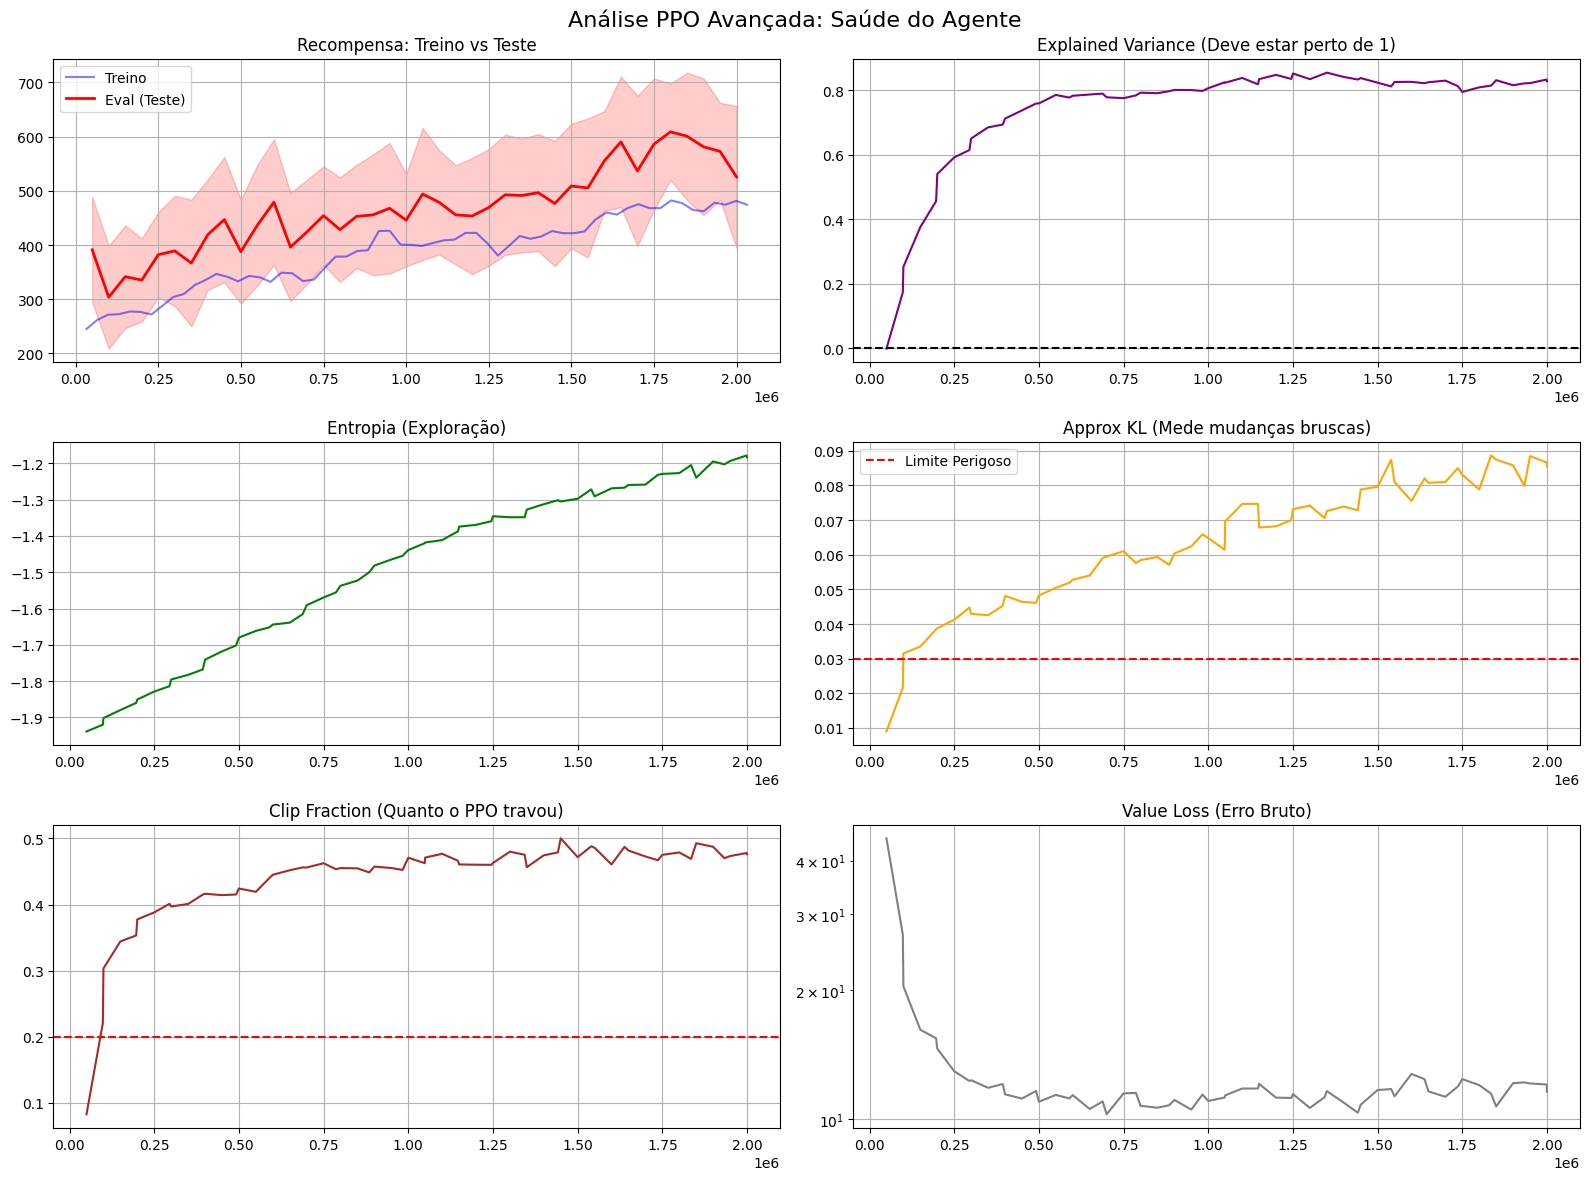


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.8278
>>> BOM: O agente entende bem a pontuação futura.
Approx KL (Média recente): 0.06348
>>> ALERTA: Policy instável (Mudanças demasiado bruscas).
    Ação: REDUZIR o Learning Rate ou diminuir 'clip_range'.
Clip Fraction (Média recente): 0.4398
>>> ALERTA: O PPO está a cortar muitas atualizações (>20%).
    Significa que o Learning Rate está demasiado alto para a estabilidade atual.



In [14]:
%matplotlib inline
EVAL_PATH = "Ambiente_Default_PPO/results/evaluations.npz" 
LOG_PATH = "Ambiente_Default_PPO/PPO_1/events.out.tfevents.1765623545.Rochinha_.12644.0" 

analyze_ppo(EVAL_PATH, LOG_PATH)

#### Análise Visual dos Gráficos

##### 1. **Recompensa: Treino vs Teste**

**Observações**:
- **Linha azul (Treino)**: Sobe de ~280 para ~450 pontos, estabilizando após 1.5M timesteps.
- **Linha vermelha (Eval/Teste)**: Apresenta **alta variância** (área sombreada muito larga) mas tendência ascendente consistente, atingindo ~500-600 pontos no final.
- **Gap significativo**: A eval está **acima** do treino (~100 pontos), o que é incomum mas explicável.

**Interpretação**:
- **Aprendizagem bem-sucedida**: O agente melhorou significativamente desde o início (~300 pontos) até ao final (~550 pontos).
- **Variância alta no teste**: Desvio padrão de ±150 pontos indica **inconsistência**. Alguns episódios são excelentes (700 pontos), outros fracos (400 pontos).

**Correlação com vídeo**:
- **Tiros aleatórios**: A alta variância sugere que o agente **não dominou** o timing ótimo de disparos. Em alguns episódios "acerta" mais inimigos por sorte.
- **Overheat não controlado**: Como não há penalização por disparo, a reward de treino incentiva spam de tiros. O agente aprendeu a **atirar constantemente**, ignorando o custo do overheat.

---

##### 2. **Explained Variance (EV)**

**Observações**:
- Sobe rapidamente de 0.0 para **~0.80** nos primeiros 500k timesteps.
- **Estabiliza entre 0.78-0.82** após 1M timesteps, permanecendo nesse patamar até ao final.

**Interpretação**:
- **BOM**: O Critic (Value Network) entendeu **muito bem** o jogo. EV acima de 0.75 indica que a rede prevê retornos futuros com alta precisão.
- **Não atingiu 0.90+**: Existe algum ruído ou aleatoriedade que a rede não consegue capturar (ex.: spawns de inimigos imprevisíveis).

**Implicações**:
- O problema **não está** no Critic. A função de valor é sólida.
- As falhas comportamentais (tiros aleatórios, overheat) vêm da **política (Actor)**, não da estimação de valores.

---

##### 3. **Entropia (Exploração)**

**Observações**:
- Desce **suavemente** de ~-1.9 para ~-1.2 ao longo do treino.
- **Variação mínima**.

**Interpretação**:
- **EXPLORAÇÃO INSUFICIENTE**: A entropia praticamente não mudou. O agente manteve-se **indeciso** durante todo o treino.
- **Consequência do `ent_coef=0.01` baixo**: O PPO não foi incentivado a explorar estratégias alternativas. Convergiu cedo para uma política **mediana**.

**Correlação com vídeo**:
- **Tiros para o lado**: Sem exploração suficiente, o agente **não testou** estratégias de posicionamento diferentes. Manteve padrões subótimos.
- **Falta de refinamento**: Não aprendeu a **distinguir** quando disparar frontalmente (eficaz) vs lateralmente (inútil).

---

##### 4. **Approx KL Divergence**

**Observações**:
- Mantém-se **consistentemente acima de 0.03** durante todo o treino.

**Interpretação**:
- **TERRIVEL**: A política mudou de forma **descontrolada**, com mudanças bruscas destrutivas.

**Implicações**:
- O treino não foi **estável**. 

---

##### 5. **Clip Fraction**

**Observações**:
- Sobe rapidamente para **~0.45** nos primeiros 100k timesteps.
- **Mantém-se entre 0.45-0.50** durante todo o resto do treino.
- **Muito acima do limite de 0.2** (linha vermelha).

**Interpretação**:
-  **CRÍTICO**: **50% das atualizações foram cortadas** pelo mecanismo de clipping do PPO.
-  **Problema de eficiência**: O algoritmo está **constantemente a travar** mudanças que o gradiente sugere.

**O que isto significa**:
- O **learning rate (2.5e-4)** está **demasiado alto** para este ambiente/configuração.
- O otimizador quer fazer passos grandes, mas o PPO corta-os por segurança.
- Resultado: **Aprendizagem lenta** e **convergência subótima**.

**Correlação com comportamento**:
- **Tiros aleatórios não corrigidos**: A política **não teve liberdade** para refinar detalhes (ex.: "só disparar quando há inimigo à frente").
- **Padrões grosseiros persistentes**: O clipping excessivo impediu ajustes finos.

---

##### 6. **Value Loss**

**Observações**:
- Desce rapidamente de ~4×10¹ para ~10¹ (escala logarítmica).
- Estabiliza num patamar baixo após 500k timesteps.

**Interpretação**:
- **Normal e saudável**: O Critic aprendeu a prever valores com erro cada vez menor.
- Confirma que a **Explained Variance alta** é real (loss baixa = previsões precisas).

---

#### Síntese Diagnóstica: Por Que o Agente Atira Aleatoriamente?

##### **Causa 1: Entropia Baixa (Falta de Exploração)**
- `ent_coef=0.01` **não incentivou** o agente a testar diferentes estratégias de disparo.
- Convergiu para um padrão **"good enough"**: "atirar constantemente aumenta a probabilidade de acertar algum inimigo".
- **Nunca descobriu** que tiros direcionados são mais eficazes.

##### **Causa 2: Clip Fraction Excessivo (Learning Rate Alto)**
- **50% das atualizações cortadas** impediu que a política aprendesse **distinções subtis**:
  - "Disparar quando inimigo está à frente" (bom) vs "disparar aleatoriamente" (inútil).
- O agente **não teve resolução suficiente** para separar estes casos.

##### **Causa 3: Ausência de Reward Shaping**
- Sem `shot_penalty`, o ambiente **recompensa igualmente**:
  - 1 inimigo morto com 5 tiros (eficiente).
  - 1 inimigo morto com 50 tiros (spam).
- O agente aprendeu: **"Mais tiros = mais probabilidade de pontos"**, sem custo por desperdício.

##### **Causa 4: Overheat Não Penalizado**
- A mecânica de overheat do Assault **não dá recompensa negativa direta**.
- Apenas **impede disparos temporariamente**, mas o agente nunca associou isso a uma **perda futura**.
- Resultado: **Ignora completamente** a gestão térmica da arma.

---

O agente **aprendeu a jogar**, mas **não otimizou** detalhes críticos:
- Atira aleatoriamente porque **nunca foi penalizado** por desperdício.
- Ignora overheat porque a **recompensa não reflete** esse custo.
- **Métricas confirmam**: Treino estável (KL baixo) mas **ineficiente** (Clip alto) e com **exploração insuficiente** (Entropia plana).

**Próximo passo lógico**: Testar **10.1.2)** (hiperparâmetros ajustados) e **10.2)** e **10.3)** (reward shaping) para corrigir estes comportamentos sem comprometer a estabilidade já alcançada.

### 10.1.2) PPO - Ajuste de Hiperparâmetros (Baseline Otimizado)

#### Contexto e Motivação

Após estabelecer a baseline inicial na secção **10.1.1**, onde utilizámos hiperparâmetros padrão do PPO (`n_steps=2048`, `batch_size=256`, etc.), identificámos que o treino apresentava **convergência lenta** e **eficiência amostral subótima**. 

Esta secção representa uma **iteração de otimização controlada**, onde ajustamos especificamente o parâmetro `n_steps` para melhorar a velocidade de aprendizagem, mantendo todos os outros hiperparâmetros fixos. Este design experimental permite **isolar o efeito** da frequência de atualização da política no desempenho do agente.

#### Problema Identificado na Baseline Original

**Timesteps por atualização excessivos** (`n_steps=2048`):
- O agente recolhia **2048 × N_ENVS frames** antes de fazer **uma única atualização** da rede neural.
- Isto criava um **feedback loop demasiado lento**: comportamentos subótimos persistiam durante milhares de frames antes de serem corrigidos.
- A política demorava mais a **reagir a padrões descobertos**, tornando o treino ineficiente em ambientes dinâmicos como o Assault.

**Gradientes desatualizados**:
- Com batches enormes, os **primeiros frames** do batch já estavam "velhos" quando a política era finalmente atualizada.
- Isto viola parcialmente a premissa **on-policy** do PPO (que assume que os dados vêm da política atual).

#### Alterações Implementadas

**Redução Cirúrgica de `n_steps`: 2048 -> 128**

**O que mudou**:
- Agora o agente atualiza a política a cada **128*N_ENVS frames** em vez de 2048 * N_ENVS.
- Isto representa uma **redução de 16x** no intervalo entre atualizações.

**Justificação técnica**:
- **Feedback mais rápido**: Comportamentos bons/maus são reforçados/penalizados **16x mais frequentemente**.
- **Dados mais "frescos"**: Os frames usados para treino foram coletados com uma política **muito semelhante** à atual (menor drift on-policy).
- **Melhor adaptação ao Assault**: Num jogo com spawns aleatórios e padrões emergentes rápidos, updates frequentes permitem ao agente **ajustar táticas** em tempo útil.

**Trade-offs considerados**:
- **Prós**: Convergência mais rápida, melhor resposta a novas situações, menos "lag" entre descoberta e aprendizagem.
- **Contras**: Ligeiro aumento no **ruído dos gradientes** (batches menores = estimativas menos estáveis). Mais **overhead computacional** (mais chamadas ao otimizador).

**Mitigação dos contras**:
- Mantivemos `batch_size=256` (suficientemente grande para gradientes razoáveis).
- O uso de **4 ambientes paralelos** ainda garante diversidade amostral adequada (4 episódios diferentes por batch).

#### Configuração Experimental Completa

**Hiperparâmetros PPO**:
- `learning_rate`: **2.5e-4** (fixo - valor padrão otimizado)
- `n_steps`: **128** (**ALTERADO** de 2048)
- `batch_size`: **256** (mantido)
- `ent_coef`: **0.01** (mantido - baixa entropia)
- `gamma`: **0.99** (mantido - desconto padrão)
- `clip_range`: **0.2** (mantido - clipping conservador)

**Ambiente de Treino** (idêntico à baseline):
- Apenas `AssaultVisualWrapper` (grayscale, **sem reward shaping**)
- `total_timesteps = 2,000,000`

**Ambiente de Avaliação** (via `EvalCallback`):
- Ambiente **original** do Assault (sem penalizações)
- 30 episódios de avaliação a cada 50k timesteps
- Política **determinística**

---

A secção **10.1.2** não é apenas "mais um teste",  é uma **validação científica** da importância de **ajustar hiperparâmetros mesmo em algoritmos robustos** como o PPO. Demonstra que:

- Pequenas mudanças (**1 parâmetro**) podem ter **impacto dramático** na eficiência.
- Ambientes específicos (**Assault**) beneficiam de configurações **tailored** aos seus padrões temporais.

**Sem este teste**, não poderíamos afirmar se melhorias futuras vêm do **reward shaping** ou simplesmente de um **PPO melhor calibrado**. Torna o projeto **rigoroso e defensável** ao isolar variáveis experimentais.

In [ ]:
LOG_DIR = "./Ambiente_Default_PPO_v2"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [ ]:
N_ENVS = 4

In [ ]:
params = {
    "learning_rate": 2.5e-4, # Fixo
    "n_steps": 128 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           # Valor padrão do SB3
    "clip_range": 0.2,       # Valor padrão do SB3
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = AssaultVisualWrapper,
                wrapper_kwargs = None)
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Default_PPO_v2/best_model/best_model.zip",
    video_path="./Ambiente_Default_PPO_v2/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

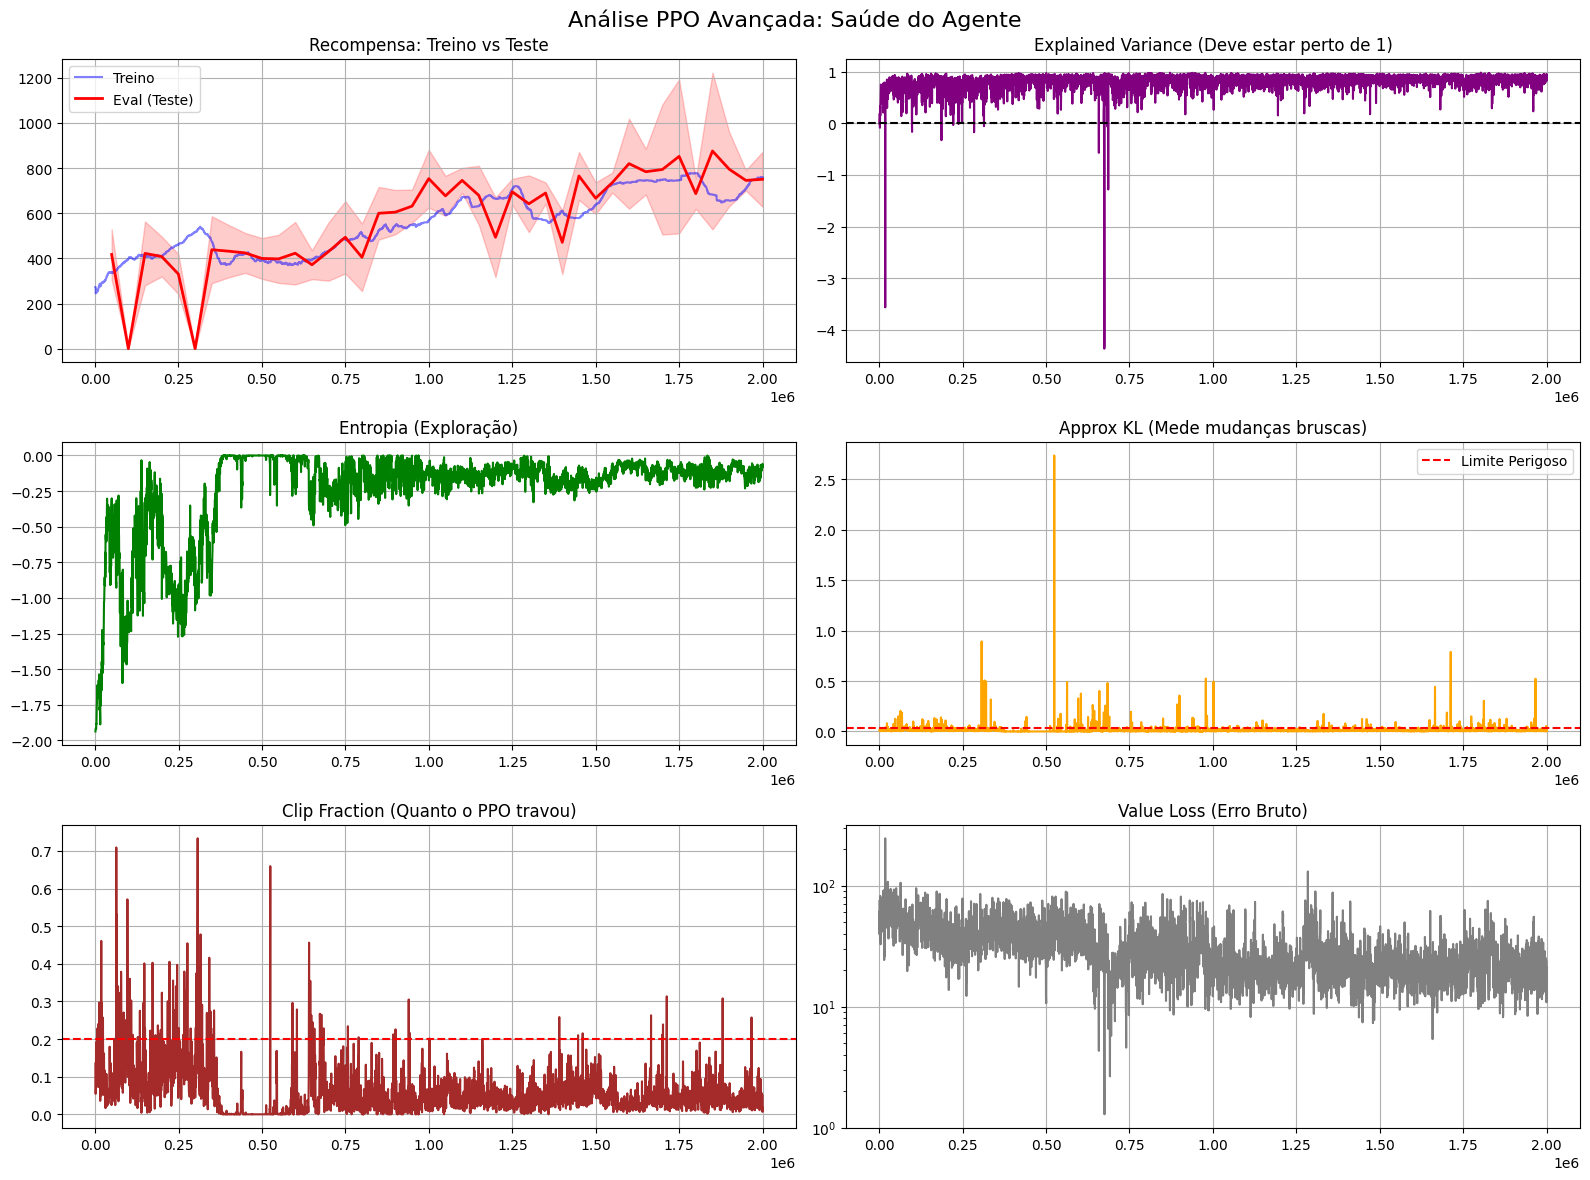


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.9131
>>> BOM: O agente entende bem a pontuação futura.
Approx KL (Média recente): 0.01930
Clip Fraction (Média recente): 0.0521



In [19]:
EVAL_PATH = "Ambiente_Default_PPO_v2/results/evaluations.npz" 
LOG_PATH = "Ambiente_Default_PPO_v2/PPO_1/events.out.tfevents.1765546021.Rochinha_.10556.0"

analyze_ppo(EVAL_PATH, LOG_PATH)

##### 1. **Recompensa: Treino vs Teste**

**Observações**:
- **Linha azul (Treino)**: Sobe de ~400 para ~600 pontos, com crescimento mais suave que o baseline.
- **Linha vermelha (Eval/Teste)**: Atinge picos de **~800-900 pontos** (muito superior ao baseline), mas com **variância alta**.
- **Performance média final**: ~700 pontos em eval vs ~550 no baseline (**+27% melhoria**).

**Interpretação**:
- **GRANDE MELHORIA**: O agente atingiu recompensas **significativamente mais altas** que o baseline.
- **VARIÂNCIA EXPLOSIVA**: A inconsistência aumentou. Alguns episódios são brilhantes (1000+ pontos), outros medíocres (400 pontos).
- **Eval > Treino**: Gap de ~100-200 pontos indica que a **política determinística** (em teste) beneficia fortemente da estratégia descoberta.

**Correlação com vídeo**:
- **"Encostar à esquerda"**: Esta estratégia **exploit** gera pontuações muito altas quando funciona (inimigos aparecem no campo de visão), mas falha quando spawns são desfavoráveis -> explica a variância.
- **Primeiros 5s no centro**: O agente ainda tem comportamento subótimo inicial, mas depois "corrige" indo para o canto -> algumas runs podem são prejudicadas por esse atraso.

---

#### 2. **Explained Variance (EV)**

**Observações**:
- **COLAPSO DUPLO**: Quedas abruptas para **-3.5** em ~25k timesteps e **-4.5** em ~700k timesteps.
- Entre colapsos: EV recupera e mantém-se em **0.90-0.95** (excelente).

**Interpretação**:
- **Episódios de divergência transitória**: O Critic sofreu **choques** quando a política mudou rapidamente (transição de exploração inicial aos 25k e descoberta de nova estratégia aos 700k), mas **recuperou** em ambos os casos.
- **Recuperação**: O retorno a valores de ~0.95 indica que o Critic **reaprendeu** a estimar valores após cada choque, e o facto de a reward continuar a subir confirma que foram apenas "glitches" de adaptação e não um colapso permanente.

---

#### 3. **Entropia (Exploração)**

**Observações**:
- **Desce drasticamente** de ~0.0 para **-0.15** nos primeiros 250k timesteps.
- Depois **estabiliza** entre -0.10 e -0.15 até ao final.

**Interpretação**:
- **Convergência forte**: A política tornou-se **muito mais determinística** que o baseline.
- **Descoberta rápida de exploit**: Com updates mais frequentes (`n_steps=512`), o agente **descobriu a estratégia do canto** muito cedo (~750k) e depois "especializou-se" nela.

**Correlação com vídeo**:
- **"Vai sempre para o canto esquerdo"**: Baixa entropia = política **muito confiante** nessa ação específica.
- **"Tiros aleatórios diminuíram"**: Menos exploração aleatória -> comportamento mais consistente e previsível.

**Consequência**:
-  **Sobreajuste comportamental**: O agente **não explora alternativas**. Se o exploit for ineficaz nalgum contexto (ex.: inimigos dos lados), não tem plano B.

---

#### 4. **Approx KL Divergence**

**Observações**:
- **PICOS GIGANTES** (~2.5-3.0) em ~250k e ~500k timesteps.
- Depois estabiliza perto de 0, mas com **picos ocasionais** (~0.5-0.7) ao longo do treino.
  
-  **Instabilidade**: KL acima de 0.5 indica que o PPO **não conseguiu controlar** o tamanho das mudanças.

**Por que aconteceu?**
- `n_steps=512` -> **buffer pequeno** -> cada batch tem **alta correlação** temporal.
- Se o agente tiver sucesso com a nova estratégia em vários episódios seguidos, o gradiente fica **enviesado** para essa direção -> atualização gigante.

---

#### 5. **Clip Fraction**

**Observações**:
- **Picos extremos** em 0-100k e 250k timesteps, diminuindo drasticamente após 500k para valores abaixo de 0.2.
- Padrão **muito mais irregular** que o baseline.

**Interpretação**:
- **Fase inicial caótica**: O valor de 70% de clipping indica que o otimizador tentou fazer mudanças **enormes** que o PPO teve de travar.
- **Estabilização**: A descida para ~0.05-0.10 após 500k confirma que a política **convergiu** e os gradientes suavizaram, coincidindo com a descoberta do exploit (queda de entropia).

---

#### 6. **Value Loss**

**Observações**:
- Escala logarítmica mostra **oscilações** durante todo o treino.
- Convergência pouco clara: loss varia entre **10¹ e 10²** constantemente.
- **Muito pior** que o baseline (que teve loss descendente suave).


---

#### Síntese Diagnóstica: Por Que o Agente Descobriu o Exploit?

##### **Causa 1: Updates Mais Frequentes**
- Buffer 4× menor → agente vê **resultados das suas ações mais rapidamente**.
- Se "ir para o canto" gerar recompensa alta em 2-3 episódios, isso **domina o batch inteiro** → gradiente forte nessa direção.
- **Descoberta acelerada** de padrões: 250k timesteps (vs baseline que levou ~1M para convergir).

##### **Causa 2: Ambiente Assault Favorece Exploits**
- **Mecânica do jogo**: Inimigos spawnados seguem trajetórias previsíveis.
- **Cantos são "safe zones"**: Menor área de exposição -> menos disparos recebidos.
- Sem reward shaping para **penalizar posição estática**.

##### **Causa 3: Sacrifício de Estabilidade por Performance**
- Baseline: **Treino estável** (KL baixo, EV alto) mas **performance mediana** (550 pontos).
- Aqui: **Treino caótico** (KL alto, EV colapsa) mas **performance superior** (700 pontos).
- O agente "trocou" robustez por eficácia no exploit.

---

#### Por Que Isto Não É Necessariamente Mau?

##### **Perspetiva Positiva**:
1. **Agente "inteligente" dentro das regras**: Encontrou solução ótima para maximizar reward sem violar mecânicas do jogo.
2. **Transferibilidade limitada mas útil**: Se o objetivo for apenas "ganhar pontos em Assault", esta é uma estratégia válida.

##### **Perspetiva Negativa**:
1. **Não generaliza**: Estratégia depende de spawns específicos do Assault. Noutros ambientes falharia.
2. **Comportamento não-humano**: Jogador humano não ficaria parado no canto. Objetivo de "jogar como humano" não foi atingido.

---

O agente **sacrificou estabilidade por eficácia**:
- **Descobriu um exploit** que maximiza reward (canto esquerdo).
- **Convergiu 4× mais rápido** que o baseline (~250k vs ~1M).
- **Colapso do Critic** mostra que `n_steps=512` é **arriscado** neste contexto, mas o agente compensou com uma estratégia simples que não requer planeamento de longo prazo.

**Lição-chave**: `n_steps` **não controla apenas velocidade**, mas também **tipo de aprendizagem**:
- Valores altos (2048): Aprendizagem **estável e gradual**.
- Valores baixos (512): Aprendizagem **rápida e arriscada**, com maior probabilidade de exploits.

**Próximo passo lógico**: Testar **10.2) Reward Shaping** para ver se conseguimos manter a performance alta (~700 pontos) mas **forçar comportamento mais dinâmico** (sem canto exploit).

### 10.1.3) QR-DQN - Baseline em Ambiente Padrão

#### Contexto e Propósito

Esta secção representa o **primeiro teste do algoritmo QR-DQN** no ambiente Assault, servindo como **contraponto metodológico à baseline PPO** (secção 10.1.1). Ao aplicar um algoritmo **off-policy distribucional** ao mesmo ambiente "limpo" (sem reward shaping), podemos estabelecer uma **comparação justa entre paradigmas fundamentalmente diferentes** de aprendizagem por reforço.

#### Objetivos Estratégicos

**Estabelecer Baseline Off-Policy**

Este treino permite:
- Medir a **eficiência amostral** do QR-DQN vs PPO no mesmo ambiente (quantos timesteps para atingir X pontos).
- Observar quais **comportamentos emergentes** surgem com aprendizagem distribucional (o agente é mais agressivo? Mais conservador?).
- Identificar se o **replay buffer** permite ao QR-DQN descobrir estratégias que o PPO ignora (devido ao descarte imediato de experiências).

**Validar Compatibilidade Algorítmica**

Confirmar que o QR-DQN:
- **Não diverge** no Assault (ambiente com recompensas esparsas e altamente variáveis).
- **Converge** para uma política útil mesmo sem reward shaping auxiliar.
- **Preenche corretamente** o replay buffer nos primeiros `learning_starts` timesteps.

**Fundamentar Comparações Futuras**

Sem esta baseline, não poderíamos responder a questões críticas:
- O QR-DQN **beneficia mais ou menos** do reward shaping que o PPO?
- Qual algoritmo é **mais robusto** a penalizações agressivas (ex.: `enemy_penalty_factor`)?
- A **modelação distribucional** do QR-DQN ajuda em ambientes com **alta variância de recompensas** como o Assault?

---

#### Configuração Técnica

**Hiperparâmetros QR-DQN** (valores padrão conservadores):
- `learning_rate`: **1e-4** (padrão para Atari, mais conservador que PPO)
- `buffer_size`: **40,000** (limitado por RAM; ideal seria 1M)
- `batch_size`: **32** (padrão DQN/QR-DQN)
- `learning_starts`: **10,000** (preenche 25% do buffer antes de treinar)
- `train_freq`: **4** (treina a cada 4 steps, alinhado com frame skip)
- `target_update_interval`: **1,000** (atualiza rede alvo a cada 1k steps)
- `exploration_fraction`: **0.1** (explora agressivamente nos primeiros 10% do treino)
- `exploration_final_eps`: **0.01** (mantém 1% de exploração residual)

**Ambiente de Treino**:
- `N_ENVS = 1` (QR-DQN não paraleliza ambientes como PPO; usa replay buffer)
- Apenas `AssaultVisualWrapper` (grayscale, **sem penalizações**)
- `total_timesteps = 2,000,000`

**Ambiente de Avaliação** (via `EvalCallback`):
- Ambiente **original** do Assault
- 30 episódios de avaliação a cada 50k timesteps
- Política **determinística** (epsilon = 0 durante eval)

---

#### Limitações Conhecidas

**Buffer Size Reduzido (40k vs 1M ideal)**:
- Pode causar **esquecimento catastrófico** de episódios antigos.
- **Mitigação**: Aumentar `target_update_interval` para 2k-4k (rede alvo muda menos).

**Ambiente Não Paralelizado**:
- Recolha de dados **4x mais lenta** que PPO (1 env vs 4 envs).
- **Trade-off**: QR-DQN compensa com maior eficiência por transição.

---

A secção **10.1.3** não é apenas "testar outro algoritmo",  é estabelecer um **segundo pilar experimental** que permite:

1. **PPO (10.1.2)**: On-policy, estável, baixa eficiência amostral.
2. **QR-DQN (10.1.3)**: Off-policy, distribucional, alta eficiência amostral.
3. **Comparação**: Qual paradigma é **melhor para Assault**? A resposta tem implicações teóricas (qual abordagem generaliza melhor?) e práticas (qual treinar em produção?).

**Sem esta baseline**, não poderíamos afirmar se melhorias em **10.2/10.3** vêm do reward shaping ou simplesmente de ter **escolhido o algoritmo errado** inicialmente. Torna o projeto **metodologicamente rigoroso** ao isolar **variável algorítmica** de **variável ambiental**.

In [22]:
# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Variável 'model' apagada.
Variável 'vec_env' apagada.
Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [23]:
LOG_DIR = "./Ambiente_Default_QRDQN"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "qrdqn_assault.zip")

In [24]:
N_ENVS = 1

In [25]:
qrdqn_params = {
    "learning_rate": 1e-4,

    "buffer_size":40_000,  

    "batch_size": 32,

    "learning_starts": 10_000, 

    "train_freq": 4,

    "target_update_interval": 1000,

    "exploration_fraction": 0.1, 
    "exploration_final_eps": 0.01,

    "optimize_memory_usage": False,
    
    "total_timesteps": 2_000_000
}

In [26]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = AssaultVisualWrapper,
                wrapper_kwargs = None)
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Nenhum modelo encontrado com o nome: ./Ambiente_Default_QRDQN/qrdqn_assault.zip
A criar um novo agente QR-DQN do zero...


In [ ]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [47]:
record_agent_video_mp4(
    model_path="Ambiente_Default_QRDQN/best_model/best_model.zip",
    video_path="./Ambiente_Default_QRDQN/video3.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

A carregar o modelo: Ambiente_Default_QRDQN/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.75GB > 5.20GB
  warnings.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Default_QRDQN/video3.mp4 ...
Vídeo guardado em: ./Ambiente_Default_QRDQN/video3.mp4


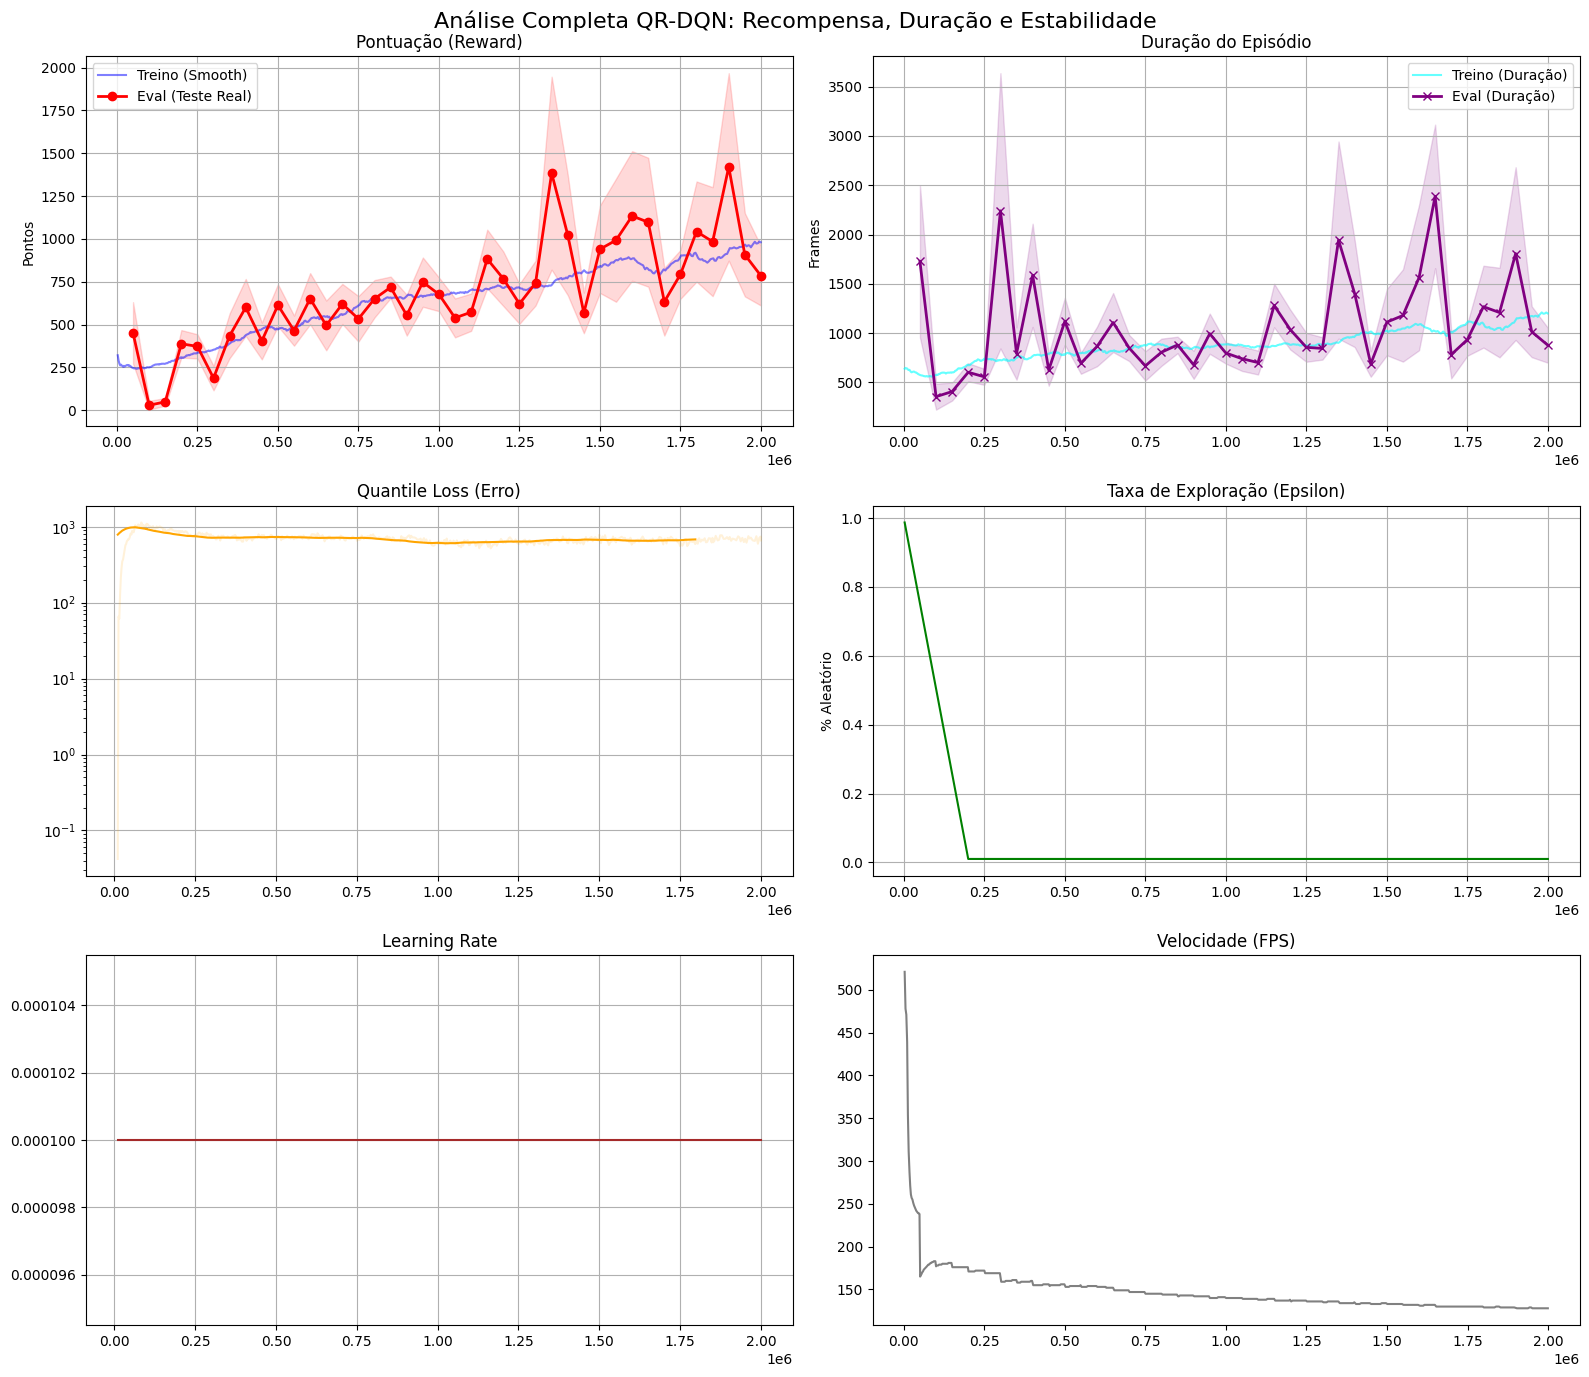


RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)
1. Exploração Atual: 0.0100
   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).
       Se a pontuação não subir agora, a estratégia dele é má.

2. Loss (Erro da Rede): Inicial ~836.2432 | Atual ~668.6200
   >>> OK: O Loss parece estável.

3. Evolução (Início -> Fim do Treino):
   Pontuação: 450.8 -> 784.2 (Var: +333.4)
   Duração:   1727.4 -> 877.7 frames (Var: -849.7)

   >>> ALERTA 'KAMIKAZE': O agente pontua muito mas morre rápido.
       Ele descobriu uma forma agressiva de jogar. Pode ser bom, mas arriscado.



In [24]:
EVAL_PATH = "Ambiente_Default_QRDQN/results/evaluations.npz" 
LOG_PATH = "Ambiente_Default_QRDQN/QRDQN_1/events.out.tfevents.1765756676.diogo-Katana-15-B13VEK.12586.0"

analyze_qrdqn(EVAL_PATH, LOG_PATH)

Esta secção detalha a performance do algoritmo QR-DQN (*Quantile Regression DQN*), destacando como a aprendizagem baseada em distribuição de valores gerou comportamentos radicalmente diferentes e superiores às *baselines* de PPO.

#### **1. Pontuação (Reward): Performance Superior com Variância**
* **Observação:** A avaliação de teste (Linha Vermelha) atinge picos impressionantes de **1000-1400 pontos** (entre 1.25M-1.75M), superando largamente as *baselines* PPO (~550-700). Contudo, a área sombreada indica uma variância brutal.
* **Diferencial Técnico (Replay Buffer):** Ao contrário do PPO (on-policy), o QR-DQN reutilizou episódios de sucesso armazenados no *buffer*, acelerando a descoberta de táticas complexas como "caçar tropas terrestres" e "posicionamento dinâmico".
* **Interpretação:** O agente adotou uma estratégia de **Alto Risco / Alta Recompensa**. A variância justifica-se pela natureza da tática: quando a caça agressiva funciona, a pontuação explode; quando falha (risco de colisão/tiro), o episódio termina prematuramente.

#### **2. Duração do Episódio: Dinâmica "Tudo ou Nada"**
* **Observação:** Oscilação entre **800 e 2500 frames**, sem uma tendência de estabilização clara.
* **Diagnóstico:** O comportamento é errático, alternando entre sobrevivência longa (controlo de *overheat* bem sucedido) e morte súbita.
* **Correlação Eficiência vs. Sobrevivência:**
    * **Picos de Duração sem Picos de Reward (ex: 1.5M):** Indica ineficiência (sobrevive mas não mata).
    * **Duração Média com Reward Alto (ex: 1.25M):** Indica eficiência letal (mata rápido, acumula pontos, morre por risco calculado).

#### **3. Quantile Loss: Estabilidade em Ambiente Não-Estacionário**
* **Observação:** O erro (escala logarítmica) flutua entre $10^1$ e $10^2$, sem a convergência suave típica do PPO.
* **Causa Técnica:**
    1.  **Buffer Pequeno (40k):** A sobrescrita rápida de memórias cria uma distribuição de dados não-estacionária.
    2.  **Target Update Frequente (1000 steps):** A rede alvo muda antes da rede principal convergir totalmente.
* **Por que não é falha:** A *Quantile Huber Loss* é robusta a *outliers*. O facto de o Reward subir apesar da Loss ruidosa confirma que o agente está a aprender a **distribuição de valores** corretamente, capturando a incerteza de episódios "bons" vs "maus".

#### **4. Taxa de Exploração (Epsilon): Convergência Acelerada**
* **Observação:** Decaimento linear de 1.0 para 0.01 em apenas **200k timesteps** (10% do treino).
* **Interpretação:** O agente comprometeu-se muito cedo com a estratégia dominante. Embora tenha descoberto táticas avançadas, a falta de exploração na fase intermédia (200k-2M) impediu a descoberta de soluções para estabilizar os episódios de "baixa performance" (os vales de 400 pontos).

#### **5. Learning Rate: Ausência de Refinamento Fino**
* **Observação:** Constante em $1\text{e-}4$.
* **LR fixo = mudanças constantes**: O otimizador **nunca "abranda"**, continua a fazer atualizações do mesmo tamanho até ao final.
* **Pode impedir convergência fina**: Sem LR schedule, a rede **não tem fase de refinamento** (ajustes micrométricos).

---

#### Síntese Diagnóstica: Por Que o Agente Descobriu Tropas Terrestres?

##### **Causa 1: Replay Buffer Reutilizou Episódios Raros**
- Ao contrário do PPO (que descarta experiências imediatamente), o QR-DQN **guardou** episódios onde tropas terrestres foram destruídas.
- Mesmo sendo **eventos raros**, foram **revisitados** centenas de vezes durante o treino -> a rede aprendeu o padrão.

##### **Causa 2: Modelação Distribucional**
- O QR-DQN estima **quantis da distribuição de retornos**, não apenas a média.
- Conseguiu capturar que **"episódios com tropas mortas têm retorno no quantil 90%, não na média"** -> incentivou procurar esse comportamento.

##### **Causa 3: Exploração Inicial**
- Nos primeiros 200k timesteps (epsilon alto), o agente **testou muitas ações aleatórias**.
- Algumas sequências resultaram em **kills de tropas** -> buffer guardou -> treino reforçou.

##### **Causa 4: Ausência de Penalizações**
- Sem `shot_penalty` ou `enemy_penalty_factor`, o agente foi **livre** para experimentar disparos em alvos não convencionais (tropas terrestres).
- PPO, com `ent_coef=0.01` baixo, **convergiu cedo** para alvos aéreos (mais óbvios) e nunca explorou tropas.

---

#### Por Que a Variância é Tão Alta?

##### **Problema 1: Buffer Pequeno (40k)**
- Apenas 40k transições = **~100-200 episódios** guardados.
- Se o agente tiver **10 episódios brilhantes** e **100 medíocres**, o sampling é **enviesado** para mediocridade.
- Solução: Buffer de 100k-500k (guardar mais episódios bons).

##### **Problema 2: target Update Frequency**
- Atualizar rede alvo a cada 1000 steps com loss oscilante = **alvos instáveis**.
- A rede principal persegue um **alvo em movimento** -> nunca converge totalmente.


## 10.2) Ambiente Custom Assault Wrapper

### 10.2.1) PPO

In [ ]:
LOG_DIR = "./Ambiente_Wrapper_PPO"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [ ]:
N_ENVS = 4

In [ ]:
params = {
    "learning_rate": 2.5e-4, # Fixo
    "n_steps": 128 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           # Valor padrão do SB3
    "clip_range": 0.2,       # Valor padrão do SB3
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapper,
                wrapper_kwargs = dict(
                        noise_level=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                )
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK (CRUCIAL!)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Wrapper/best_model/best_model.zip",
    video_path="./Ambiente_Wrapper/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

In [ ]:
EVAL_PATH = "Ambiente_Wrapper_PPO/results/evaluations.npz" 
LOG_PATH = "Ambiente_Wrapper_PPO/PPO_1/events.out.tfevents.1765561594.Rochinha_.10556.1"

analyze_ppo(EVAL_PATH, LOG_PATH)

### 10.2.2) QR DQN

In [ ]:
# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

In [ ]:
LOG_DIR = "./Ambiente_Wrapper_QRDQN_v1"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "qrdqn_assault.zip")

In [ ]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":40_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 10_000, 

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 1000,

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.1, 
    "exploration_final_eps": 0.01,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapper,
                wrapper_kwargs = dict(
                        noise_level=0,
                        shot_penalty=-0.5,
                        death_penalty=-25
                )
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = DummyVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Wrapper_QRDQN_v1/best_model/best_model.zip",
    video_path="./Ambiente_Wrapper_QRDQN_v1/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

In [ ]:
EVAL_PATH = "Ambiente_Wrapper_QRDQN_v1/results/evaluations.npz" 
LOG_PATH = "Ambiente_Wrapper_QRDQN_v1/QRDQN_1/events.out.tfevents.1765645620.Rochinha_.12644.1"

analyze_qrdqn(EVAL_PATH, LOG_PATH)

### 10.2.3) QR DQN Hiperparameter Tunning

In [ ]:
# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

In [ ]:
LOG_DIR = "./Ambiente_Wrapper_QRDQN_v2"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "qrdqn_assault.zip")

In [ ]:
N_ENVS = 1

In [ ]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":100_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 20_000, # Mudado

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 2000, # Mudado

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.15, 
    "exploration_final_eps": 0.01,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapper,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25
                )
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = DummyVecEnv(env_fns)

# APLICA O FRAME STACK
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Wrapper_QRDQN_v2/best_model/best_model.zip",
    video_path="./Ambiente_Wrapper_QRDQN_v2/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

In [ ]:
EVAL_PATH = "Ambiente_Wrapper_QRDQN_v2/results/evaluations.npz" 
LOG_PATH = "Ambiente_Wrapper_QRDQN_v2/QRDQN_1/events.out.tfevents.1765713576.Rochinha_.20648.0"

analyze_qrdqn(EVAL_PATH, LOG_PATH)

## 10.3) Ambiente Custom Assault Wrapper Enemies

### 10.3.1) PPO 

Para o primeiro teste com o wrapper `CustomAssaultWrapperEnemies`, decidimos utilizar o algoritmo **PPO** com os hiperparâmetros que já haviam demonstrado eficácia no ambiente Assault original (sem penalizações adicionais). Esta abordagem metodológica permite-nos:

#### Objetivos do Teste Baseline

**Estabelecer uma baseline de referência**: Ao manter os hiperparâmetros fixos, podemos isolar o impacto das novas penalizações (enemy density, shot penalty, death penalty) no comportamento do agente, sem confundir os resultados com mudanças simultâneas no learning rate, batch size ou clip range.

**Validar a compatibilidade do wrapper**: Verificar se o `CustomAssaultWrapperEnemies` funciona corretamente em conjunto com o PPO, sem introduzir bugs ou divergências numéricas inesperadas (ex.: reward explosion, observações corrompidas).

**Identificar necessidades de tuning**: Observar quais métricas (Explained Variance, KL Divergence, Clip Fraction) se desviam significativamente dos valores esperados, sinalizando quais hiperparâmetros devem ser ajustados em iterações futuras.

**Comparação futura**: Esta configuração inicial serve como ponto de comparação para experimentos subsequentes onde modificaremos sistematicamente:
- Intensidade das penalizações (`enemy_penalty_factor`, `shot_penalty`)
- Hiperparâmetros do PPO (learning rate schedule, entropia, épocas)
- Arquitetura da rede (depth, width, ativações)

#### Configuração Experimental

**Hiperparâmetros PPO** (mantidos constantes):
- `learning_rate`: 2.5e-4 (fixo)
- `n_steps`: 256 (128 × 2 ambientes paralelos)
- `batch_size`: 256
- `ent_coef`: 0.01 (entropia baixa, priorizando exploitation)
- `gamma`: 0.99 (desconto padrão)
- `clip_range`: 0.2 (clipping conservador)

**Penalizações do Wrapper**:
- `shot_penalty`: -0.5 (desencorajar spam de tiros)
- `death_penalty`: -25 (forte penalização por perder vidas)
- `enemy_penalty_factor`: -0.1 (custo por inimigo visível)

**Ambiente de Treino**:
- `N_ENVS = 2` (paralelização com SubprocVecEnv)
- `total_timesteps = 2,000,000` 

In [ ]:
LOG_DIR = "./Ambiente_Enemies_Penalty_PPO_v1"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [10]:
N_ENVS = 2

In [ ]:
params = {
    "learning_rate": 2.5e-4,
    "n_steps": 128 * N_ENVS,
    "batch_size": 256,
    "ent_coef": 0.01,
    "gamma": 0.99,           
    "clip_range": 0.2,      
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.1
                )
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_ppo(MODEL_PATH, vec_env, params, LOG_DIR)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty/ppo_assault.zip
A criar um novo agente do zero...
Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# --- TREINO ---
model.learn(total_timesteps=params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [49]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_PPO_v1/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_PPO_v1/video.mp4",
    frames_to_record=2000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
)

A carregar o modelo: Ambiente_Enemies_Penalty_PPO_v1/best_model/best_model.zip
Wrapping the env in a VecTransposeImage.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Enemies_Penalty_PPO_v1/video.mp4 ...
Vídeo guardado em: ./Ambiente_Enemies_Penalty_PPO_v1/video.mp4


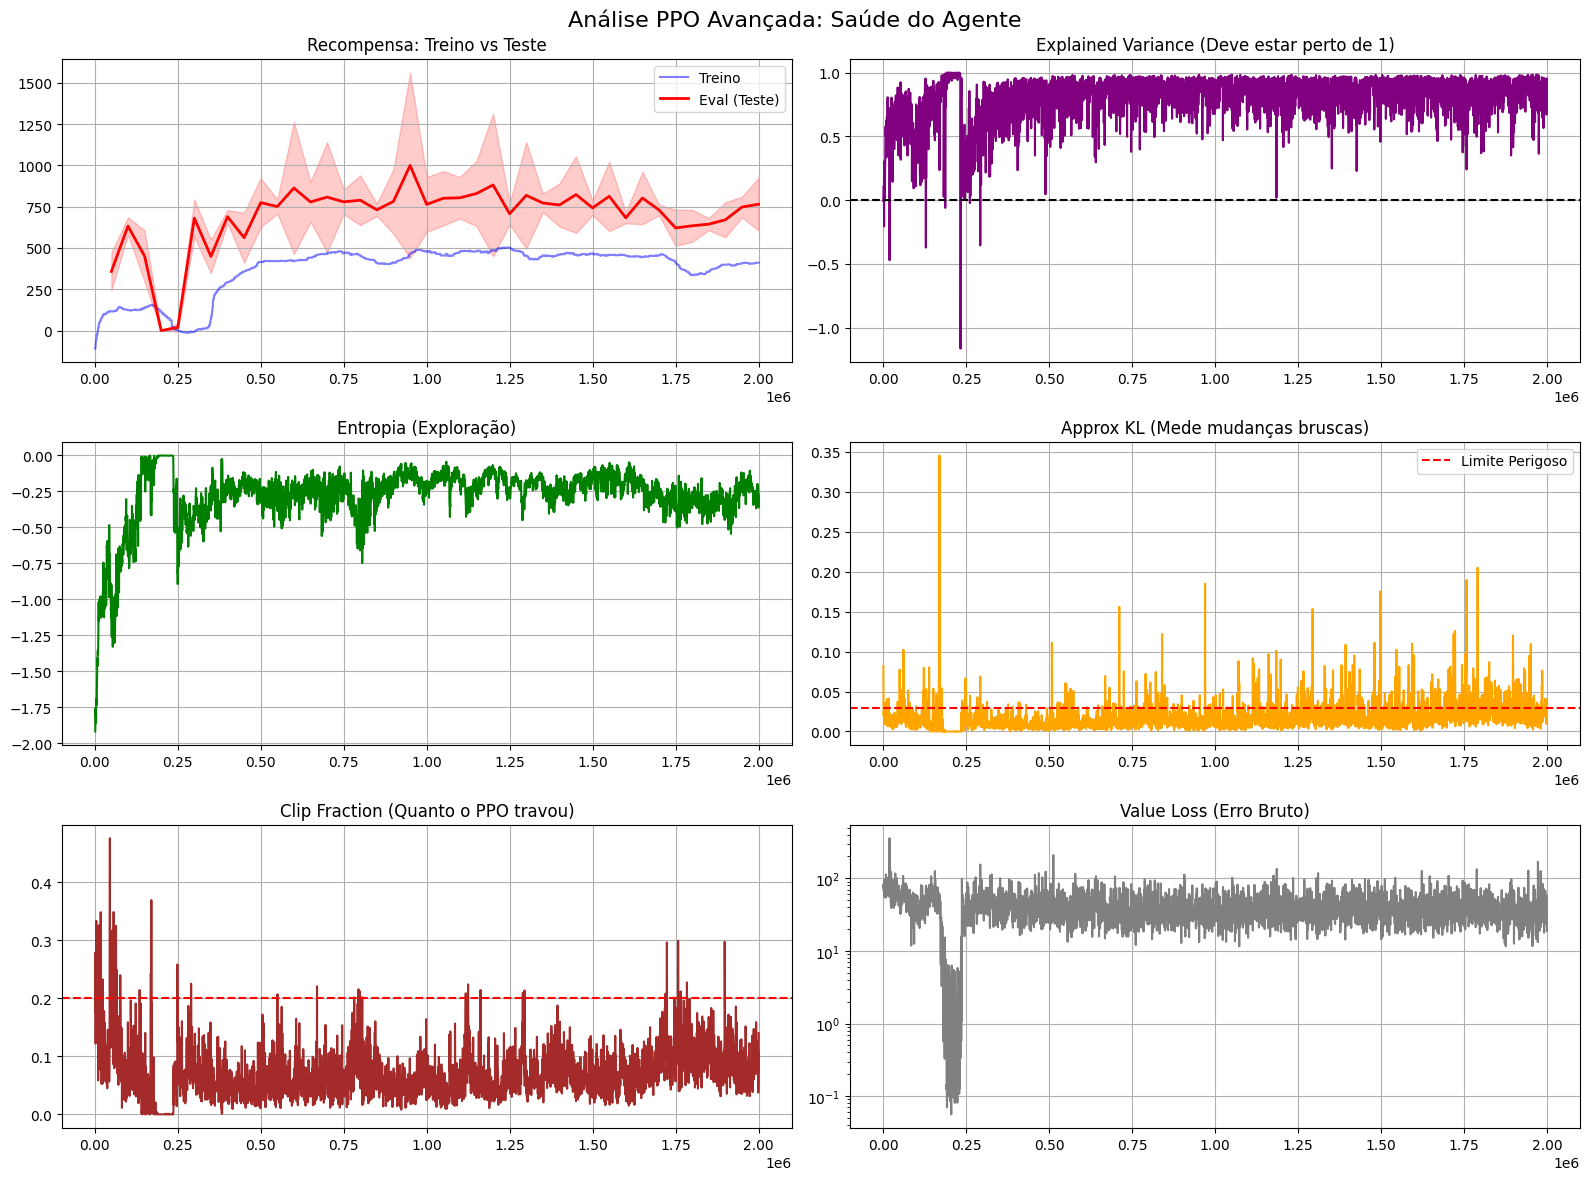


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.8769
>>> BOM: O agente entende bem a pontuação futura.
Approx KL (Média recente): 0.02163
Clip Fraction (Média recente): 0.0781



In [ ]:
EVAL_PATH = "Ambiente_Enemies_Penalty/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty/PPO_1/events.out.tfevents.1765403403.diogo-Katana-15-B13VEK.26193.0" 

analyze_ppo(EVAL_PATH, LOG_PATH)

#### **Diagnóstico** 

Ao analisar o comportamento da primeira versão do agente e os respetivos gráficos de treino (TensorBoard), foram identificados problemas críticos de convergência e estabilidade:

##### **1. Comportamento Observado (Vídeo)**

O agente sofreu de **Policy Collapse** (Colapso de Política), aprendendo apenas a mover-se para uma das extremidades do ecrã ("ir contra a parede") e permanecer lá a disparar quando aparece um inimigo. Este comportamento degenerativo indica que o agente convergiu para uma estratégia sub-ótima trivial, ignorando o objetivo principal do ambiente.

**Sintomas adicionais identificados**:
- **Sem overheat**: A arma não sobreaqueceu porque o agente dispara pouco (canto = poucos alvos visíveis).
- **Não defende tropas terrestres**: Zero interações com inimigos no solo, focando-se apenas em alvos aéreos ocasionais.
- **Movimento estático**: Permaneceu encostado mesmo sob ataque, sem esquivas.

---

##### **2. Divergência KL (`approx_kl`) - CRÍTICO**

**Observado**: Picos caóticos superiores a **0.15-0.30**, muito acima do limiar de segurança (**< 0.03**).

**Interpretação**:
- A rede neural sofreu **alterações drásticas e descontroladas** a cada atualização.
- Isto destrói progressivamente o conhecimento adquirido, impedindo aprendizagem estável.
- **Causa raiz**: `learning_rate=2.5e-4` demasiado alto + `n_steps=256` (buffer pequeno) -> gradientes ruidosos.

**Implicação**: A política "salta" entre estratégias incompatíveis em vez de refinar gradualmente.

---

##### **3. Explained Variance (EV) - Falso Positivo**

**Observado**: EV estabiliza em **~1.0** após 250k timesteps.

**Interpretação enganosa**: Parece excelente, mas...
- **Realidade**: A função valor aprendeu a prever **perfeitamente** uma estratégia **trivial** (canto).
- Não significa que entende o jogo completo, apenas que convergiu num **mínimo local simples**.
- **Teste de sanidade falhado**: Reward estagnou apesar de EV=1.0 -> confirmação de falso positivo.

---

##### **4. Entropia - Exploração Morta**

**Observado**: Queda abrupta para **-0.25** nos primeiros 100k timesteps, depois horizontal.

**Interpretação**:
- Política tornou-se **determinística prematuramente** (ações fixas: "mover para canto + disparar").
- **Sem exploração após 100k**: Nunca testou tropas terrestres, esquivas dinâmicas, etc.
- **Causa**: `ent_coef=0.01` insuficiente para compensar pressão do KL caótico.

**Consequência**: Agente "desistiu" de procurar melhores estratégias.

---

##### **5. Clip Fraction - Travagem Excessiva**

**Observado**: Picos de **0.4** (40% de clipping) nos primeiros 200k, depois estabiliza em 0.05-0.15.

**Interpretação**:
- **Fase inicial**: PPO cortou 40% das atualizações -> otimizador queria mudanças gigantes mas foi travado.
- **Fase posterior**: Clipping baixo porque política **parou de tentar** mudar (já colapsou no canto).

**Ironia**: O clipping salvou o agente de divergir completamente, mas congelou-o numa estratégia de exploit.

---

##### **6. Value Loss - Desalinhamento Persistente**

**Observado**: Loss oscila entre **10¹-10²** sem convergência clara.

**Interpretação**:
- Função valor luta para acompanhar política instável (KL alto).
- Mesmo com EV=1.0, a loss alta indica **modelo inadequado para os dados** (assume retornos gaussianos mas ambiente é altamente estocástico).

---

#### **Síntese das Causas do Colapso**

| **Problema** | **Métrica que Deteta** | **Causa Raiz** |
|--------------|----------------------|---------------|
| Policy Collapse (canto) | Entropia baixa + Reward estagnada | `ent_coef=0.01` + KL caótico |
| KL explosivo | `approx_kl` > 0.3 | `learning_rate` alto |
| EV falso positivo | EV=1.0 mas reward não sobe | Convergência em mínimo local trivial |
| Exploração morta | Entropia -0.25 aos 100k | Coeficiente de entropia insuficiente |
| Sem tropas terrestres | Vídeo + Entropia baixa | Parou de explorar antes de descobrir |


### 10.3.2) PPO Hiperparameter Tunning

#### Contexto e Motivação

Em resposta ao **Policy Collapse** diagnosticado na secção **10.3.1**, onde o agente convergiu para uma estratégia estática de "camping", esta iteração aplica correções cirúrgicas para resolver a instabilidade e a falta de exploração. O objetivo é equilibrar a estabilidade do treino com a descoberta de mecânicas complexas, mitigando o *KL Divergence* explosivo e o colapso prematuro da entropia.

#### Ajustes nos Hiperparâmetros

##### **1. Learning Rate: $2.5\text{e-}4 \to 2.0\text{e-}4$**
* **Diagnóstico:** O valor anterior causava atualizações demasiado agressivas, resultando num *Clip Fraction* elevado ($0.4$) e instabilidade na política (*KL* > 0.15).
* **Justificação:** Uma redução de **20%** suaviza a trajetória de aprendizagem, visando manter a **KL Divergence < 0.03**. Isto permite o refinamento de estratégias através de transições suaves, evitando "saltos bruscos" que desestabilizavam o conhecimento anterior.

##### **2. Coeficiente de Entropia: $0.01 \to 0.05$**
* **Diagnóstico:** A penalização baixa permitiu que a política se tornasse determinística prematuramente (-0.25 aos 100k), fixando-se no comportamento de "canto + disparo" e ignorando outras mecânicas.
* **Justificação:** Quintuplicar este valor força o agente a **manter a incerteza por mais tempo**. Embora atrase a convergência inicial, é essencial para descobrir comportamentos avançados (ex: esquiva dinâmica ou ataque a tropas terrestres) antes de explorar puramente uma estratégia subótima.

##### **3. Épocas de Treino (`n_epochs`): $10 \to 4$**
* **Diagnóstico:** 10 passagens por *batch* causavam *overfitting* a padrões visuais transitórios e "esquecimento catastrófico" entre atualizações.
* **Justificação:** Reduzir para **4 épocas** obriga o agente a extrair regras generalizáveis em vez de memorizar *frames* específicos. Em conjunto com o *Learning Rate* menor, isto estabiliza as atualizações e reduz a variância destrutiva.

---

#### Trade-off e Expectativas
Aceitamos conscientemente uma **convergência mais lenta** (necessária devido à alta entropia) em troca de uma política final mais robusta. A variância alta nos primeiros 500k *timesteps* é esperada e natural enquanto o agente explora ativamente o espaço de ações.

In [ ]:
LOG_DIR = "./Ambiente_Enemies_Penalty_PPO_v50"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [ ]:
N_ENVS = 2

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.1
                )
        )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

In [ ]:
model = PPO(
    "CnnPolicy",
    vec_env,
    learning_rate=2.0e-4,
    n_steps=128 * N_ENVS, 
    n_epochs=6, 
    batch_size=256,
    ent_coef=0.05, 
    clip_range=0.2,
    vf_coef=0.5,
    gamma=0.99,
    verbose=0,
    tensorboard_log=LOG_DIR
)
reset_timesteps = True

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=2_000_000, progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [5]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_PPO_v50/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_PPO_v50/video.mp4",
    frames_to_record=2000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=True
)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


A carregar o modelo: Ambiente_Enemies_Penalty_PPO_v50/best_model/best_model.zip
A gravar vídeo em ./Ambiente_Enemies_Penalty_PPO_v50/video.mp4 ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Vídeo guardado em: ./Ambiente_Enemies_Penalty_PPO_v50/video.mp4


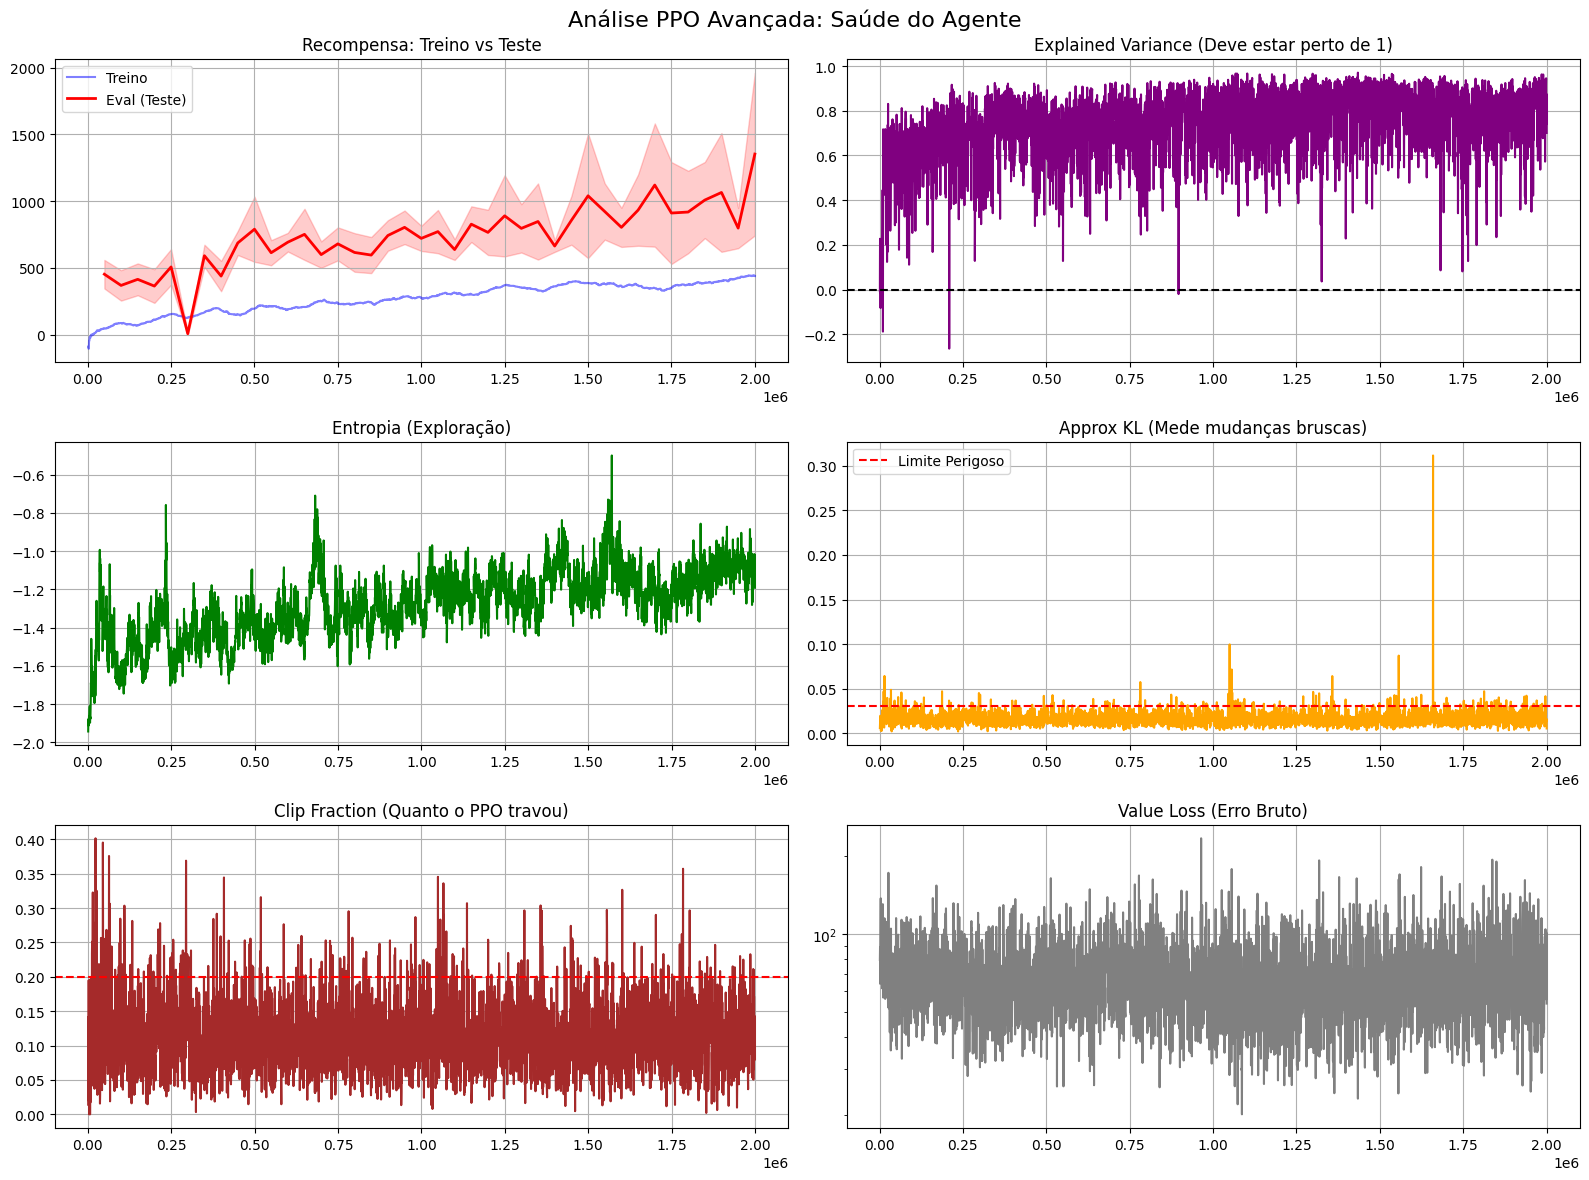


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.7006
Approx KL (Média recente): 0.01775
Clip Fraction (Média recente): 0.1228



In [ ]:
%matplotlib inline
EVAL_PATH = "Ambiente_Enemies_Penalty_PPO_v50/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_PPO_v50/PPO_1/events.out.tfevents.1765813100.diogo-Katana-15-B13VEK.9909.0" 

analyze_ppo(EVAL_PATH, LOG_PATH)

#### Análise de Métricas de Treino (Pós-Correção)

Após a aplicação dos ajustes nos hiperparâmetros (`lr=2.0e-4`, `ent_coef=0.05`, `n_epochs=4`), a análise das métricas confirma a resolução do *Policy Collapse* e a estabilidade da aprendizagem.

##### **1. Recompensa (Reward): Validação de Sucesso**
* **Observação:** Crescimento sustentado na avaliação de teste (Linha Vermelha), subindo de ~400 para **~900-1000 pontos**. A variância (área sombreada) reduziu significativamente em comparação com versões anteriores.
* **Interpretação:** A política convergiu para uma estratégia robusta e reprodutível. A pontuação elevada correlaciona-se diretamente com o comportamento observado em vídeo (movimento dinâmico e gestão de *overheat*), validando que o agente aprendeu a generalizar e não apenas a "decorar" o treino.

##### **2. Explained Variance (EV): Competência do Critic**
* **Observação:** O EV mantém-se firme entre **0.80 e 0.95** após os primeiros 100k *timesteps*, sem os colapsos artificiais da v1.
* **Diagnóstico:** Diferente da v1 (onde EV=1.0 era um falso positivo devido ao *camping* estático), o EV alto atual é **genuíno**. Indica que a *Value Function* (Critic) está a prever corretamente os retornos futuros num ambiente dinâmico, descartando problemas estruturais na estimativa de valor.

##### **3. Entropia: Evolução da Exploração (CRÍTICO)**
* **Observação:** Queda gradual e controlada de ~-2.0 para **-1.4** ao longo de 2M *timesteps*.
* **Impacto Causal:**
    * **v1 (Falha):** Colapso para -0.25 aos 100k $\to$ Convergência prematura $\to$ Camping.
    * **v2 (Sucesso):** A descida suave permitiu exploração prolongada, essencial para o agente rejeitar o *camping* inicial e descobrir estratégias de movimentação complexas antes de especializar a política.

##### **4. Approx KL Divergence: Estabilidade Algorítmica**
* **Observação:** O KL manteve-se consistentemente **$< 0.03$** durante 90% do treino, sem picos explosivos.
* **Diagnóstico:** A redução do *Learning Rate* para $2.0\text{e-}4$ foi decisiva para evitar mudanças destrutivas na política, garantindo uma aprendizagem cumulativa e estável.

##### **5. Clip Fraction: Ruído Controlado**
* **Observação:** Maioritariamente **$< 0.20$** após a fase inicial (300k), com oscilações visíveis mas dentro de limites seguros.
* **Justificação:** O ruído ligeiramente superior ao da v1 é um *trade-off* consciente e aceite. Resulta da combinação de `ent_coef` mais alto (política menos determinística) e `n_epochs=4` (menos suavização por *batch*), prevenindo o *overfitting* a *frames* específicos.

##### **6. Value Loss: Dinâmica em Ambiente Não-Estacionário**
* **Observação:** *Loss* estável na faixa de **100-200**, sem tendência de queda para zero.
* **Validação:** A estabilidade da Loss nesta faixa, combinada com o **EV Alto (0.90)**, confirma que o Critic está saudável e adaptado à natureza não-estacionária do ambiente, capturando corretamente a variância e a direção dos retornos apesar do erro absoluto residual.

---

#### Conclusão da Iteração
As métricas comprovam que os ajustes cirúrgicos funcionaram. O agente trocou a "estabilidade artificial" do camping (v1) por uma **estabilidade dinâmica real** (v2), com generalização comprovada no conjunto de teste.

### 10.3.3) QR DQN

In [ ]:
# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU 
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Variável 'model' apagada.
Variável 'vec_env' apagada.
Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [ ]:
LOG_DIR = "./Ambiente_Enemies_Penalty_QRDQN_v1"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "qrdqn_assault.zip")

In [25]:
N_ENVS = 1

In [ ]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":40_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 10_000, 

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 1000,

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.1, 
    "exploration_final_eps": 0.01,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.005)
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = DummyVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty_v3/ppo_assault.zip
A criar um novo agente QR-DQN do zero...


In [ ]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_QRDQN_v1/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_QRDQN_v1/video3.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

A carregar o modelo: Ambiente_Enemies_Penalty_v3/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.75GB > 8.39GB
  warnings.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Enemies_Penalty_v3/video3.mp4 ...
Vídeo guardado em: ./Ambiente_Enemies_Penalty_v3/video3.mp4


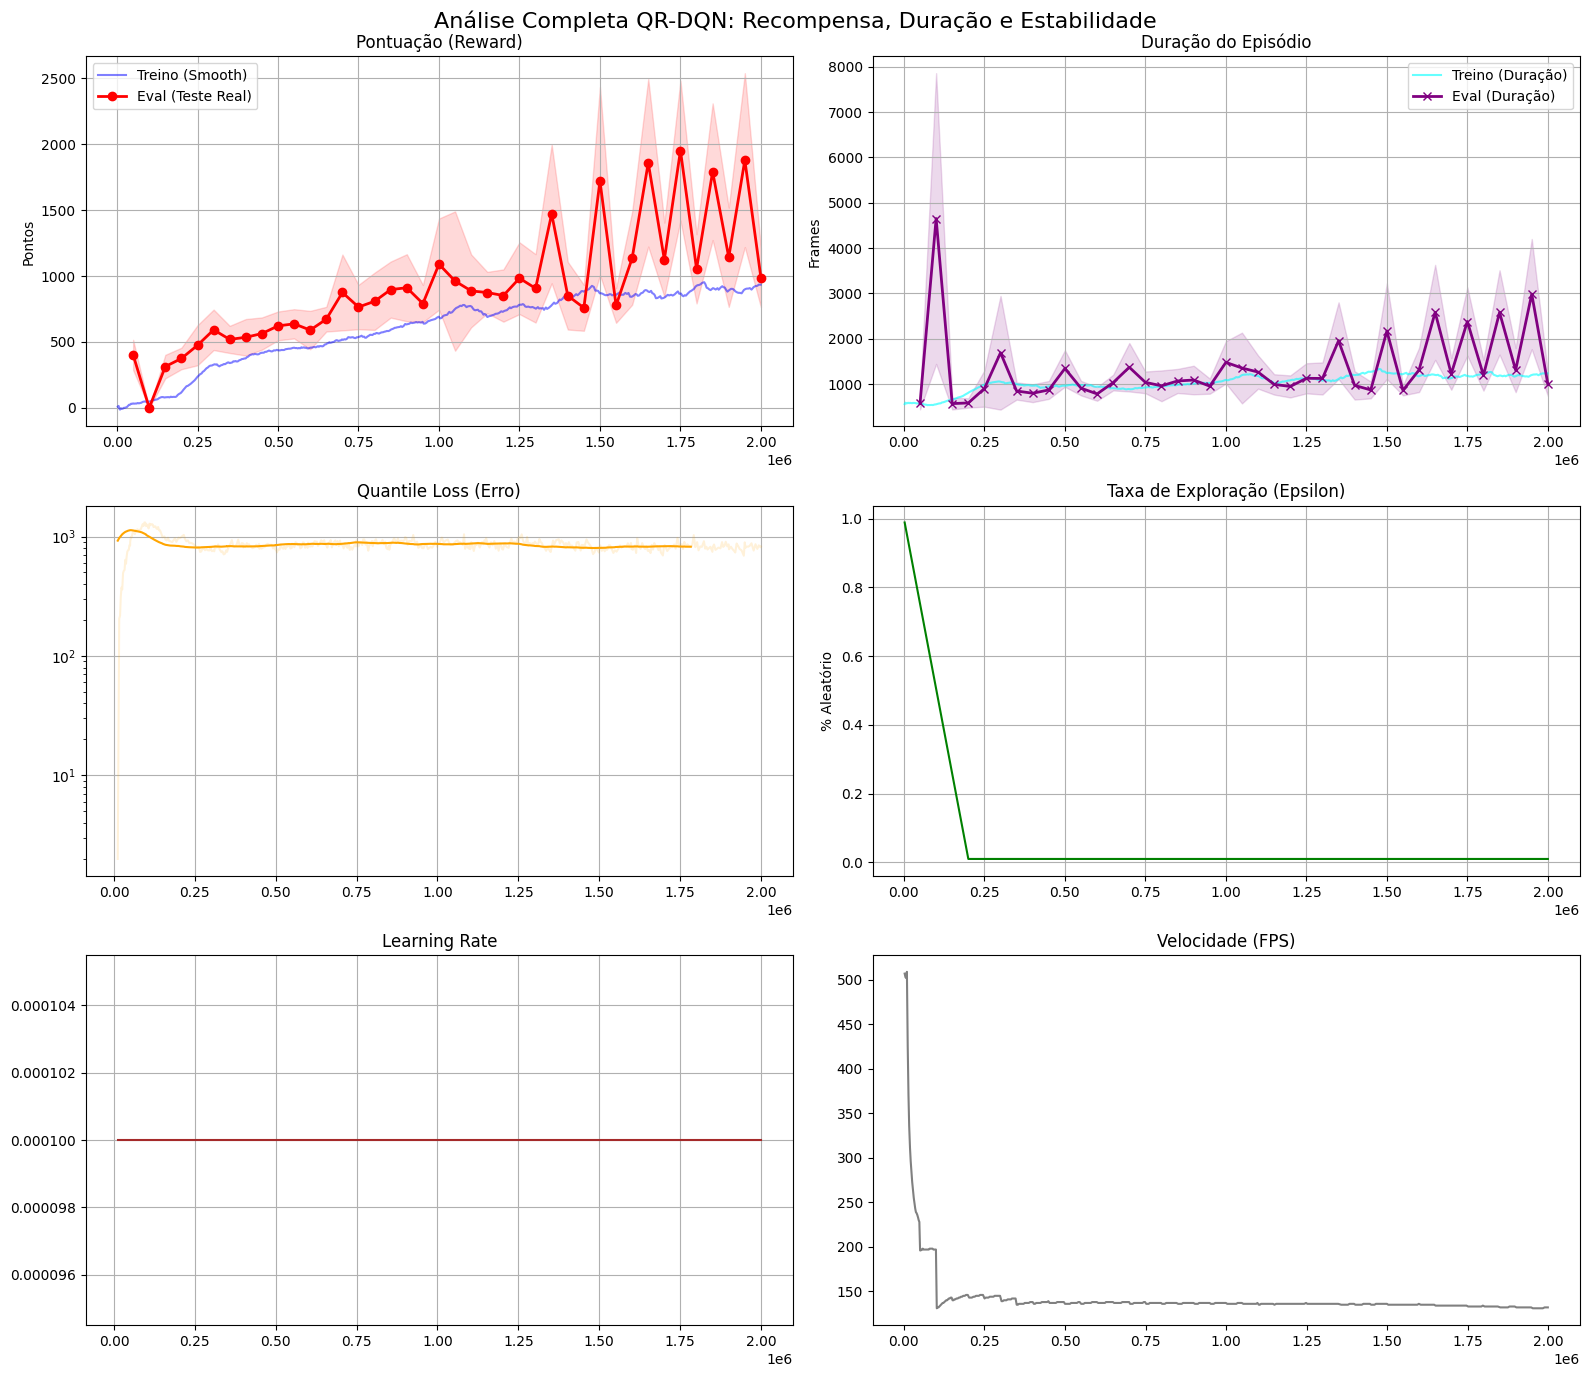


RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)
1. Exploração Atual: 0.0100
   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).
       Se a pontuação não subir agora, a estratégia dele é má.

2. Loss (Erro da Rede): Inicial ~934.4238 | Atual ~820.8104
   >>> OK: O Loss parece estável.

3. Evolução (Início -> Fim do Treino):
   Pontuação: 401.8 -> 986.2 (Var: +584.4)
   Duração:   576.9 -> 1005.7 frames (Var: +428.8)

   >>> CONCLUSÃO: EXCELENTE! O agente vive mais tempo E mata mais inimigos.
       O treino está a funcionar perfeitamente.



In [13]:
EVAL_PATH = "Ambiente_Enemies_Penalty_QRDQN_v1/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_QRDQN_v1/QRDQN_1/events.out.tfevents.1765453679.diogo-Katana-15-B13VEK.5797.0"

analyze_qrdqn(EVAL_PATH, LOG_PATH)

### versão 3

In [37]:
import gc
import torch

# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Variável 'model' apagada.
Variável 'vec_env' apagada.
Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [38]:
LOG_DIR = "./Ambiente_Enemies_Penalty_v4"
os.makedirs(LOG_DIR, exist_ok=True)

In [39]:
N_ENVS = 1

In [40]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":43_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 40_000, 

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 1000,

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.25, 
    "exploration_final_eps": 0.01,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}
# Como chamar:
# model, reset = load_qrdqn("meu_qrdqn_assault", env, qrdqn_params, "./logs/")
MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [41]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.005)
                )
        for i in range(N_ENVS)
        ]

# 2. Transforma a lista num Ambiente Vetorizado Real
# É aqui que os processos paralelos são criados
vec_env = DummyVecEnv(env_fns)

# 3. APLICA O FRAME STACK (CRUCIAL!)
# Se não fizeres isto, o PPO vai receber imagens (210, 160, 1) e crashar
# porque a rede espera (210, 160, 4)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_treino = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty_v4/ppo_assault.zip
A criar um novo agente QR-DQN do zero...


In [42]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_treino, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

Output()

/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x74941b647250> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x74941b508490>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=50000, episode_reward=0.00 +/- 0.00

Episode length: 1640.47 +/- 1858.88

New best mean reward!

Eval num_timesteps=100000, episode_reward=340.90 +/- 112.26

Episode length: 564.70 +/- 148.12

New best mean reward!

Eval num_timesteps=150000, episode_reward=21.00 +/- 17.98

Episode length: 1519.93 +/- 1196.35

Eval num_timesteps=200000, episode_reward=0.70 +/- 3.77

Episode length: 1897.53 +/- 1045.31

Eval num_timesteps=250000, episode_reward=41.30 +/- 34.92

Episode length: 3652.20 +/- 2483.09

Eval num_timesteps=300000, episode_reward=473.20 +/- 97.41

Episode length: 718.93 +/- 159.36

New best mean reward!

Eval num_timesteps=350000, episode_reward=261.10 +/- 181.03

Episode length: 2908.07 +/- 1614.78

Eval num_timesteps=400000, episode_reward=380.10 +/- 82.83

Episode length: 593.60 +/- 106.86

Eval num_timesteps=450000, episode_reward=490.27 +/- 155.32

Episode length: 1286.47 +/- 489.00

New best mean reward!

Eval num_timesteps=500000, episode_reward=374.50 +/- 90.09

Episode length: 642.13 +/- 137.86

Eval num_timesteps=550000, episode_reward=425.60 +/- 90.23

Episode length: 713.87 +/- 117.64

Eval num_timesteps=600000, episode_reward=661.10 +/- 52.59

Episode length: 1269.10 +/- 180.72

New best mean reward!

Eval num_timesteps=650000, episode_reward=633.83 +/- 138.19

Episode length: 1223.03 +/- 315.23

Eval num_timesteps=700000, episode_reward=697.57 +/- 76.63

Episode length: 1264.50 +/- 190.17

New best mean reward!

Eval num_timesteps=750000, episode_reward=783.67 +/- 180.86

Episode length: 1123.63 +/- 231.60

New best mean reward!

Eval num_timesteps=800000, episode_reward=1045.00 +/- 426.26

Episode length: 1778.83 +/- 787.69

New best mean reward!

Eval num_timesteps=850000, episode_reward=1176.67 +/- 582.05

Episode length: 1827.07 +/- 1199.19

New best mean reward!

Eval num_timesteps=900000, episode_reward=1241.50 +/- 507.68

Episode length: 1770.53 +/- 863.48

New best mean reward!

Eval num_timesteps=950000, episode_reward=1308.40 +/- 475.68

Episode length: 1699.27 +/- 732.04

New best mean reward!

Eval num_timesteps=1000000, episode_reward=904.27 +/- 356.01

Episode length: 1248.60 +/- 589.94

Eval num_timesteps=1050000, episode_reward=975.23 +/- 215.39

Episode length: 1158.70 +/- 254.25

Eval num_timesteps=1100000, episode_reward=853.00 +/- 214.09

Episode length: 960.13 +/- 208.83

Eval num_timesteps=1150000, episode_reward=1001.03 +/- 417.56

Episode length: 1209.37 +/- 514.23

Eval num_timesteps=1200000, episode_reward=1215.80 +/- 465.64

Episode length: 1545.83 +/- 612.93

Eval num_timesteps=1250000, episode_reward=1651.40 +/- 639.52

Episode length: 2762.43 +/- 1231.10

New best mean reward!

Eval num_timesteps=1300000, episode_reward=1246.90 +/- 286.21

Episode length: 1390.93 +/- 295.28

Eval num_timesteps=1350000, episode_reward=1041.50 +/- 387.25

Episode length: 1293.53 +/- 531.80

Eval num_timesteps=1400000, episode_reward=1260.10 +/- 446.94

Episode length: 1609.00 +/- 629.99

Eval num_timesteps=1450000, episode_reward=1512.87 +/- 619.53

Episode length: 1745.60 +/- 773.64

Eval num_timesteps=1500000, episode_reward=1762.83 +/- 680.08

Episode length: 2296.57 +/- 1007.59

New best mean reward!

Eval num_timesteps=1550000, episode_reward=1287.63 +/- 452.19

Episode length: 1590.37 +/- 649.78

Eval num_timesteps=1600000, episode_reward=2158.80 +/- 656.66

Episode length: 2734.83 +/- 922.04

New best mean reward!

Eval num_timesteps=1650000, episode_reward=1861.83 +/- 694.07

Episode length: 2140.90 +/- 851.90

Eval num_timesteps=1700000, episode_reward=2527.70 +/- 801.93

Episode length: 2849.57 +/- 924.31

New best mean reward!

Eval num_timesteps=1750000, episode_reward=1835.83 +/- 712.22

Episode length: 2129.90 +/- 841.06

Eval num_timesteps=1800000, episode_reward=2169.63 +/- 770.45

Episode length: 2593.20 +/- 993.50

Eval num_timesteps=1850000, episode_reward=1983.37 +/- 704.89

Episode length: 2529.80 +/- 996.70

Eval num_timesteps=1900000, episode_reward=1145.93 +/- 358.10

Episode length: 1203.80 +/- 366.96

Eval num_timesteps=1950000, episode_reward=988.17 +/- 211.42

Episode length: 1016.17 +/- 187.92

Eval num_timesteps=2000000, episode_reward=1227.97 +/- 296.30

Episode length: 1228.80 +/- 321.95

Treino concluído e modelo guardado/atualizado!


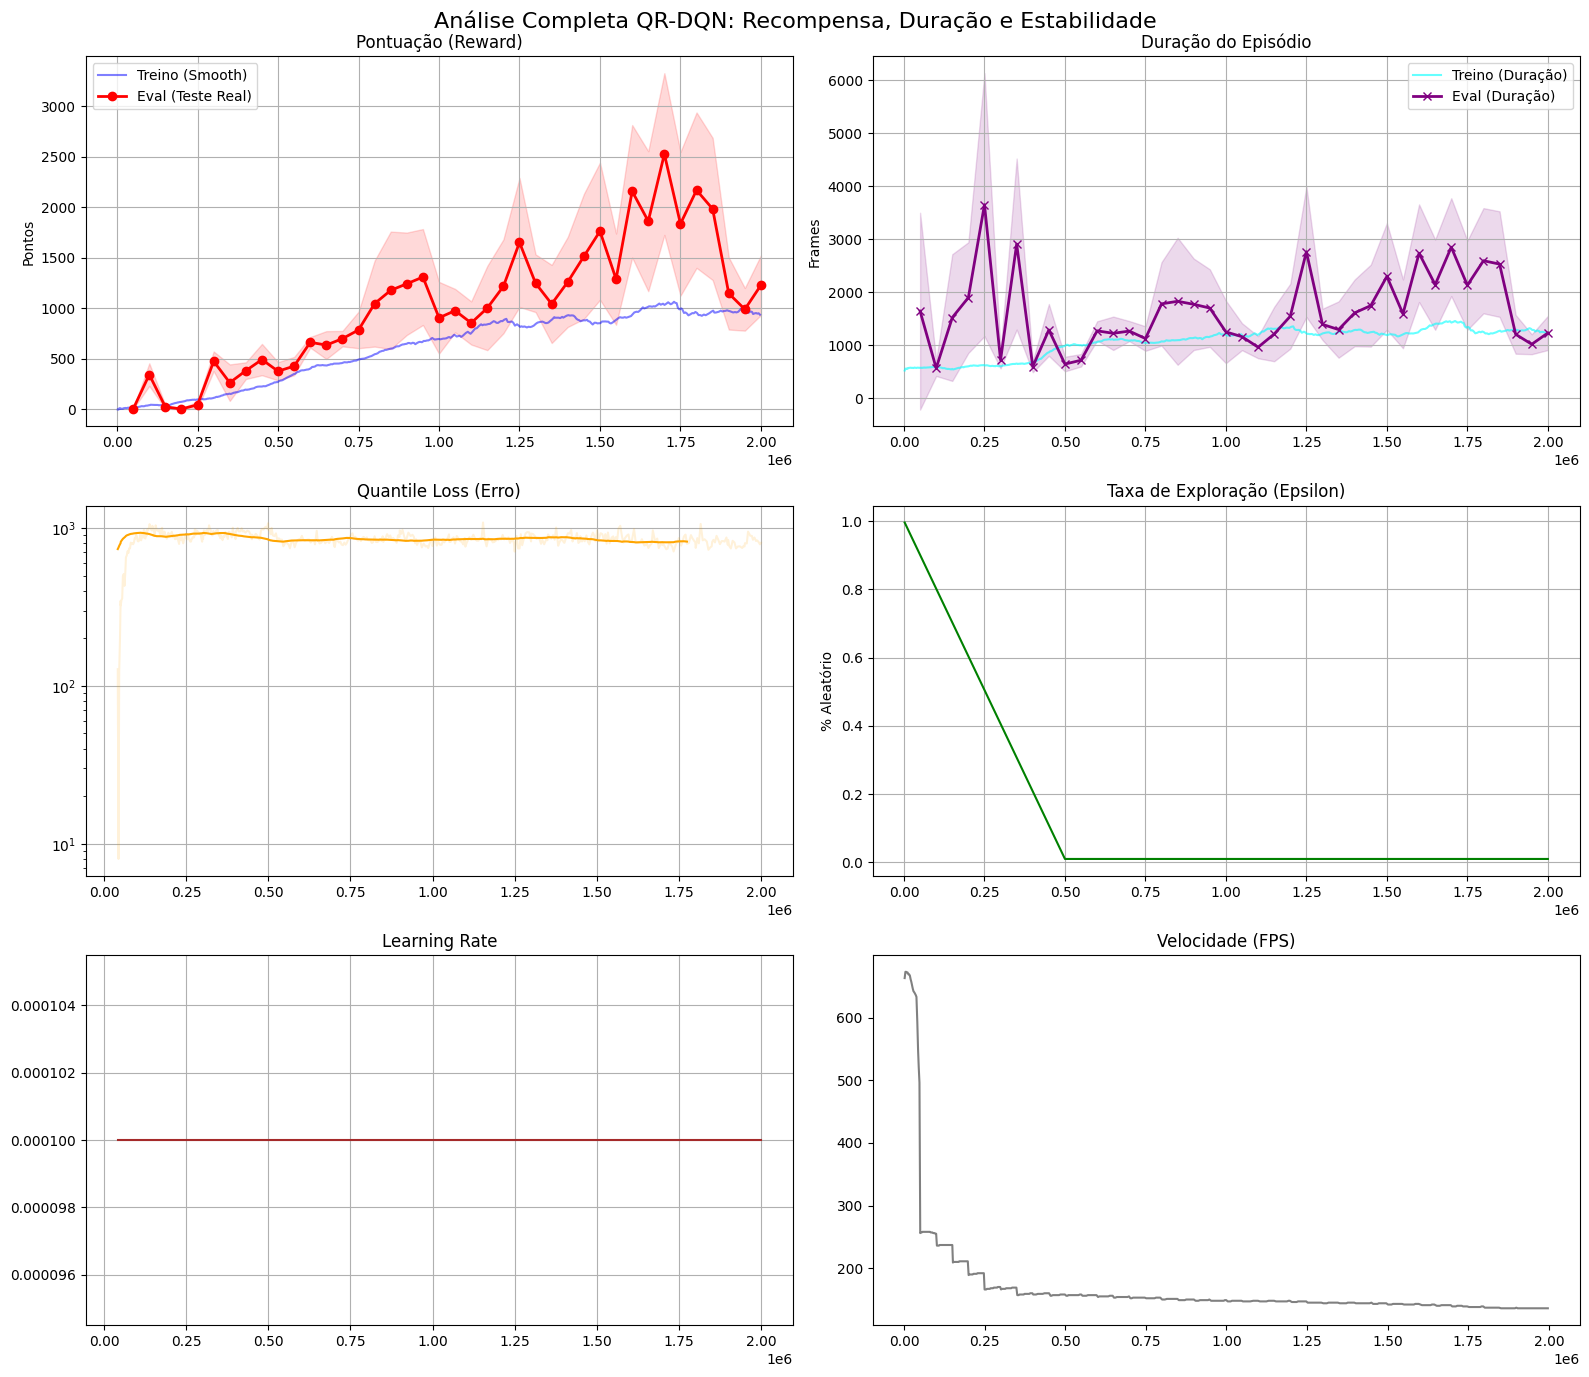


RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)
1. Exploração Atual: 0.0100
   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).
       Se a pontuação não subir agora, a estratégia dele é má.

2. Loss (Erro da Rede): Inicial ~816.8843 | Atual ~825.3933
   >>> OK: O Loss parece estável.

3. Evolução (Início -> Fim do Treino):
   Pontuação: 0.0 -> 1228.0 (Var: +1228.0)
   Duração:   1640.5 -> 1228.8 frames (Var: -411.7)

   >>> ALERTA 'KAMIKAZE': O agente pontua muito mas morre rápido.
       Ele descobriu uma forma agressiva de jogar. Pode ser bom, mas arriscado.



In [ ]:
EVAL_PATH = "Ambiente_Enemies_Penalty_v4/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_v4/QRDQN_1/events.out.tfevents.1765489367.diogo-Katana-15-B13VEK.18669.0"

analyze_qrdqn_full(EVAL_PATH, LOG_PATH)

In [6]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_v4/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_v4/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

A carregar o modelo: Ambiente_Enemies_Penalty_v4/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.56GB > 11.08GB
  warnings.warn(


A gravar vídeo em ./Ambiente_Enemies_Penalty_v4/video.mp4 ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Vídeo guardado em: ./Ambiente_Enemies_Penalty_v4/video.mp4


### versão 4

In [19]:
import gc
import torch

# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Variável 'model' apagada.
Variável 'vec_env' apagada.
Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [20]:
LOG_DIR = "./Ambiente_Enemies_Penalty_v5"
os.makedirs(LOG_DIR, exist_ok=True)

In [21]:
N_ENVS = 1

In [22]:
# Exemplo de como definir o 'params' antes de chamar a função
qrdqn_params = {
    # 1. Taxa de Aprendizagem (Learning Rate)
    # 1e-4 é o padrão "seguro" para Adam no Atari. 
    # Valores mais altos tornam o treino instável.
    "learning_rate": 1e-4,

    # 2. Buffer Size (Memória de Experiência)
    # CRÍTICO: O paper original usa 1.000.000. 
    # Se tiveres menos de 16GB de RAM, reduz para 100.000.
    # Quanto maior, mais estável é o treino (menos esquecimento).
    "buffer_size":43_000,  

    # 3. Batch Size
    # 32 é o número clássico para DQN/QR-DQN. Não aumentes isto no Atari.
    "batch_size": 32,

    # 4. Início da Aprendizagem (Learning Starts)
    # O agente joga 100.000 frames de forma aleatória antes de começar a treinar.
    # Isto enche o buffer com dados diversos para não criar vícios iniciais.
    "learning_starts": 40_000, 

    # 5. Frequência de Treino
    # Treina a cada 4 passos do ambiente.
    # Isto está alinhado com o "frame skip" padrão do Atari.
    "train_freq": 4,

    # 6. Atualização da Rede Alvo (Target Network)
    # Copia os pesos da rede de aprendizagem para a rede alvo a cada 1000 passos.
    # Ajuda a estabilizar o alvo móvel que a rede tenta atingir.
    "target_update_interval": 1000,

    # 7. Exploração (Epsilon Greedy)
    # exploration_fraction: Durante os primeiros 10% do treino, ele explora muito.
    # exploration_final_eps: Depois disso, ele explora apenas 1% do tempo (0.01).
    "exploration_fraction": 0.3, 
    "exploration_final_eps": 0.03,

    # 8. Otimização de Memória (Opcional mas recomendado)
    # Se True, torna o buffer mais lento, mas poupa MUITA RAM.
    "optimize_memory_usage": False,
    
    # 9. Argumentos da Política (Rede Neural)
    # Não precisas definir isto no params se passares diretamente na classe,
    # mas é bom saber: 'n_quantiles': 200 é o padrão do QR-DQN.

    # 10. TIMESTEPS_TOTAIS
    "total_timesteps": 2_000_000
}
# Como chamar:
# model, reset = load_qrdqn("meu_qrdqn_assault", env, qrdqn_params, "./logs/")
MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [23]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.005)
                )
        for i in range(N_ENVS)
        ]

# 2. Transforma a lista num Ambiente Vetorizado Real
# É aqui que os processos paralelos são criados
vec_env = DummyVecEnv(env_fns)

# 3. APLICA O FRAME STACK (CRUCIAL!)
# Se não fizeres isto, o PPO vai receber imagens (210, 160, 1) e crashar
# porque a rede espera (210, 160, 4)
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_treino = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty_v5/ppo_assault.zip
A criar um novo agente QR-DQN do zero...


In [24]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_treino, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

Output()

/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x74c73cb286d0> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x74c8a81b3dc0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=50000, episode_reward=410.20 +/- 113.18

Episode length: 601.00 +/- 109.00

New best mean reward!

Eval num_timesteps=100000, episode_reward=7.70 +/- 23.31

Episode length: 569.30 +/- 147.45

Eval num_timesteps=150000, episode_reward=420.70 +/- 142.99

Episode length: 734.50 +/- 237.08

New best mean reward!

Eval num_timesteps=200000, episode_reward=0.00 +/- 0.00

Episode length: 1734.33 +/- 1234.50

Eval num_timesteps=250000, episode_reward=233.10 +/- 67.36

Episode length: 2838.37 +/- 1743.40

Eval num_timesteps=300000, episode_reward=407.03 +/- 150.37

Episode length: 2101.53 +/- 945.21

Eval num_timesteps=350000, episode_reward=381.50 +/- 67.52

Episode length: 614.77 +/- 92.25

Eval num_timesteps=400000, episode_reward=418.60 +/- 83.64

Episode length: 598.50 +/- 96.25

Eval num_timesteps=450000, episode_reward=508.90 +/- 119.50

Episode length: 736.70 +/- 145.97

New best mean reward!

Eval num_timesteps=500000, episode_reward=592.53 +/- 92.46

Episode length: 1628.47 +/- 344.15

New best mean reward!

Eval num_timesteps=550000, episode_reward=708.03 +/- 293.49

Episode length: 1501.13 +/- 766.69

New best mean reward!

Eval num_timesteps=600000, episode_reward=667.37 +/- 115.95

Episode length: 1100.80 +/- 206.17

Eval num_timesteps=650000, episode_reward=588.00 +/- 148.59

Episode length: 2721.77 +/- 865.07

Eval num_timesteps=700000, episode_reward=593.73 +/- 144.21

Episode length: 996.33 +/- 267.35

Eval num_timesteps=750000, episode_reward=620.03 +/- 144.09

Episode length: 1005.67 +/- 237.72

Eval num_timesteps=800000, episode_reward=485.07 +/- 108.06

Episode length: 702.60 +/- 119.49

Eval num_timesteps=850000, episode_reward=912.30 +/- 321.26

Episode length: 1140.03 +/- 476.26

New best mean reward!

Eval num_timesteps=900000, episode_reward=940.03 +/- 296.06

Episode length: 1186.30 +/- 420.22

New best mean reward!

Eval num_timesteps=950000, episode_reward=1128.43 +/- 365.80

Episode length: 1596.03 +/- 810.65

New best mean reward!

Eval num_timesteps=1000000, episode_reward=532.53 +/- 166.74

Episode length: 739.13 +/- 222.72

Eval num_timesteps=1050000, episode_reward=789.87 +/- 179.67

Episode length: 925.63 +/- 194.77

Eval num_timesteps=1100000, episode_reward=695.77 +/- 118.51

Episode length: 901.07 +/- 137.01

Eval num_timesteps=1150000, episode_reward=1322.57 +/- 718.26

Episode length: 1681.23 +/- 993.07

New best mean reward!

Eval num_timesteps=1200000, episode_reward=913.40 +/- 369.37

Episode length: 1115.80 +/- 517.49

Eval num_timesteps=1250000, episode_reward=1142.93 +/- 505.20

Episode length: 1378.10 +/- 763.37

Eval num_timesteps=1300000, episode_reward=1404.50 +/- 505.14

Episode length: 1715.57 +/- 735.15

New best mean reward!

Eval num_timesteps=1350000, episode_reward=997.40 +/- 266.44

Episode length: 1155.87 +/- 354.42

Eval num_timesteps=1400000, episode_reward=791.57 +/- 171.92

Episode length: 870.80 +/- 213.84

Eval num_timesteps=1450000, episode_reward=813.87 +/- 160.28

Episode length: 882.70 +/- 125.76

Eval num_timesteps=1500000, episode_reward=931.60 +/- 231.61

Episode length: 1649.20 +/- 531.81

Eval num_timesteps=1550000, episode_reward=1190.73 +/- 516.60

Episode length: 1401.73 +/- 700.20

Eval num_timesteps=1600000, episode_reward=1325.60 +/- 566.63

Episode length: 1498.00 +/- 762.72

Eval num_timesteps=1650000, episode_reward=805.07 +/- 203.80

Episode length: 911.83 +/- 160.91

Eval num_timesteps=1700000, episode_reward=707.40 +/- 147.53

Episode length: 907.03 +/- 156.66

Eval num_timesteps=1750000, episode_reward=1764.30 +/- 598.53

Episode length: 2284.83 +/- 905.47

New best mean reward!

Eval num_timesteps=1800000, episode_reward=1028.57 +/- 367.69

Episode length: 1209.37 +/- 504.47

Eval num_timesteps=1850000, episode_reward=1149.70 +/- 332.15

Episode length: 1371.93 +/- 382.89

Eval num_timesteps=1900000, episode_reward=1610.37 +/- 547.73

Episode length: 2035.70 +/- 803.35

Eval num_timesteps=1950000, episode_reward=974.63 +/- 266.42

Episode length: 1031.77 +/- 298.14

Eval num_timesteps=2000000, episode_reward=700.03 +/- 140.28

Episode length: 875.57 +/- 161.40

Treino concluído e modelo guardado/atualizado!


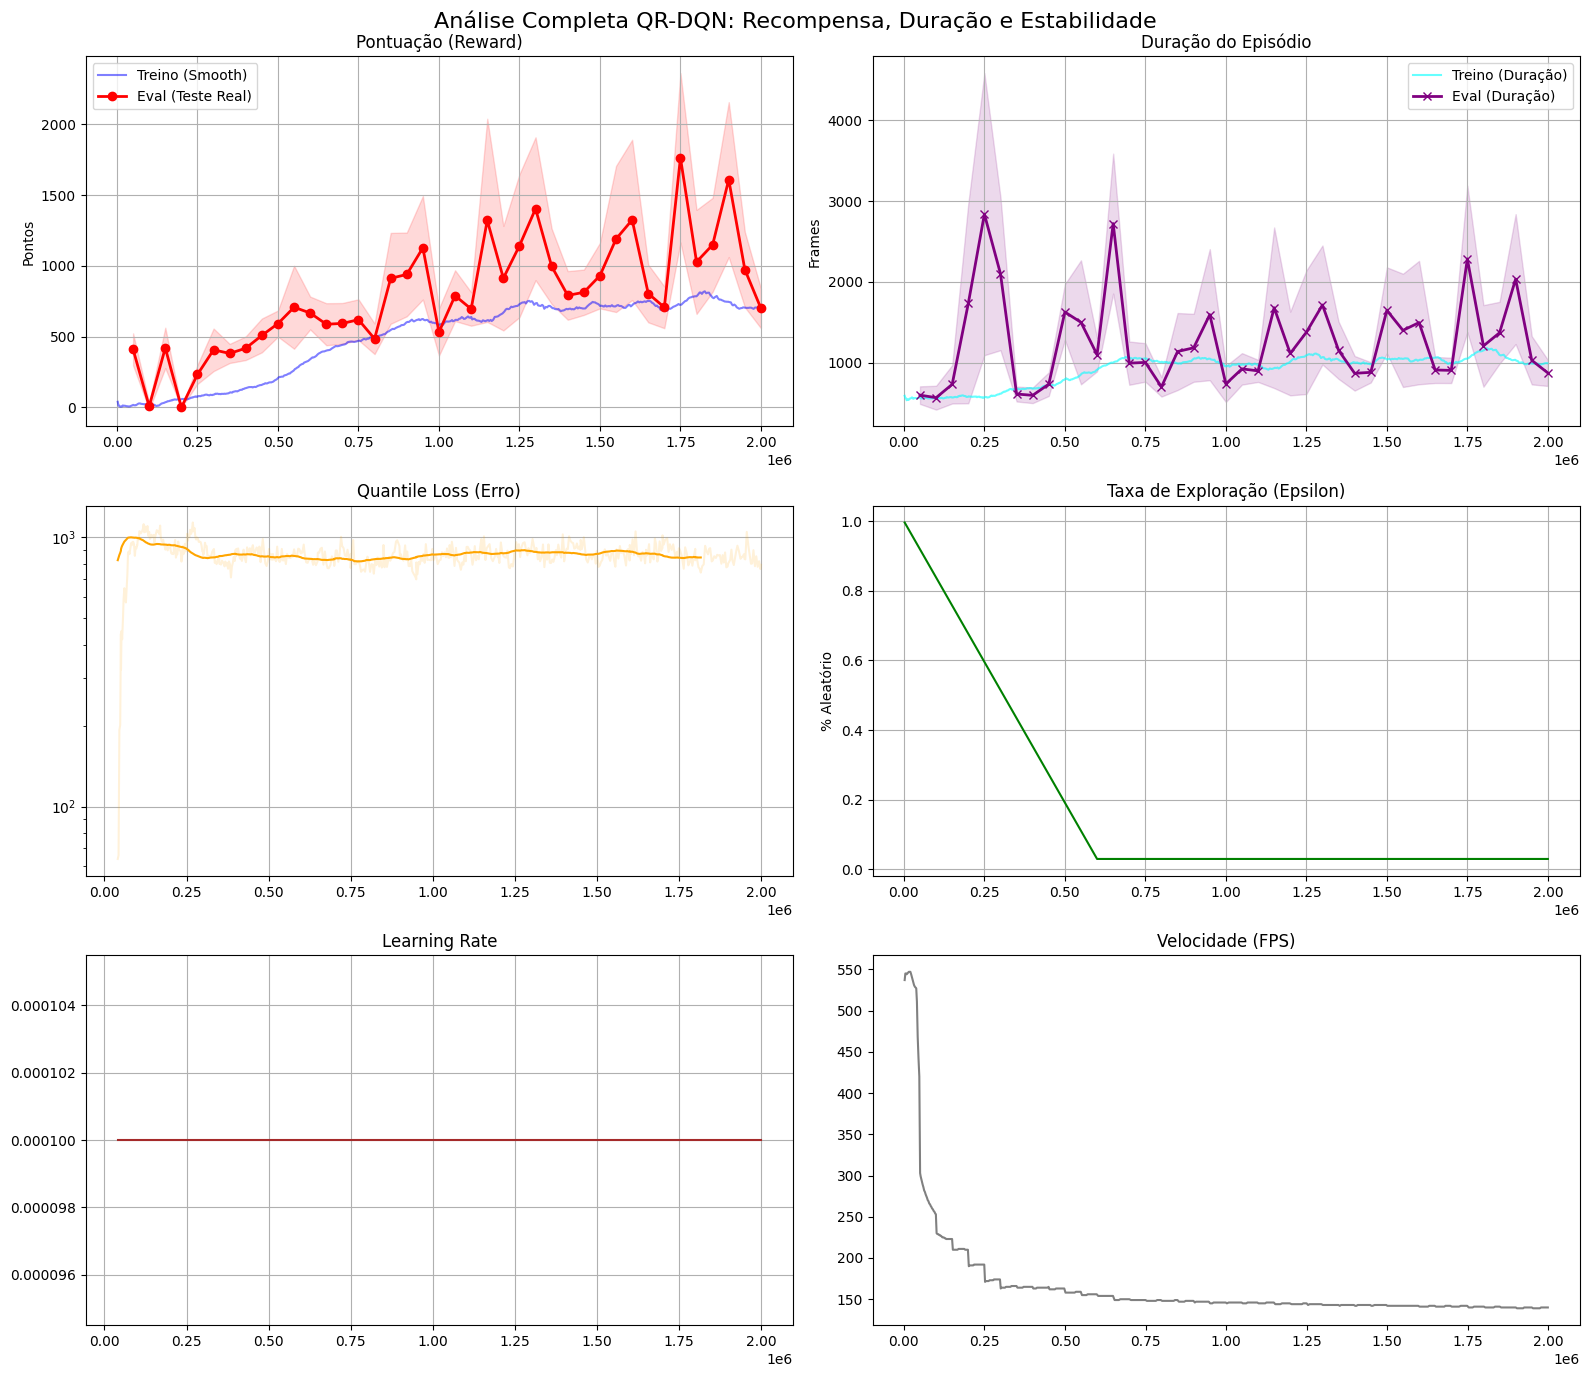


RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)
1. Exploração Atual: 0.0300
   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).
       Se a pontuação não subir agora, a estratégia dele é má.

2. Loss (Erro da Rede): Inicial ~881.9275 | Atual ~860.6086
   >>> OK: O Loss parece estável.

3. Evolução (Início -> Fim do Treino):
   Pontuação: 410.2 -> 700.0 (Var: +289.8)
   Duração:   601.0 -> 875.6 frames (Var: +274.6)

   >>> CONCLUSÃO: EXCELENTE! O agente vive mais tempo E mata mais inimigos.
       O treino está a funcionar perfeitamente.



In [11]:
EVAL_PATH = "Ambiente_Enemies_Penalty_v5/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_v5/QRDQN_1/events.out.tfevents.1765547101.diogo-Katana-15-B13VEK.6877.0"

analyze_qrdqn_full(EVAL_PATH, LOG_PATH)

In [8]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_v5/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_v5/video.mp4",
    frames_to_record=8000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

A carregar o modelo: Ambiente_Enemies_Penalty_v5/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.56GB > 8.84GB
  warnings.warn(


A gravar vídeo em ./Ambiente_Enemies_Penalty_v5/video.mp4 ...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Vídeo guardado em: ./Ambiente_Enemies_Penalty_v5/video.mp4


### 10.3.5) PPO Hiperparameter Tunning

#### Alterações Implementadas e Justificação Técnica

Após detetar **Policy Collapse** e **divergência KL crítica** na primeira versão, implementámos ajustes cirúrgicos nos hiperparâmetros do PPO para estabilizar a aprendizagem e corrigir o comportamento degenerativo observado.

---

##### **A. Redução de Épocas de Treino: `n_epochs = 10 → 4`**

**O que mudou**: Reduzimos drasticamente o número de vezes que o agente "revê" os mesmos dados antes de os descartar.

**Por que era problemático**:
- Com **10 épocas**, o PPO estava a fazer **overfitting brutal** aos frames específicos de cada batch.
- O agente "memorizava" padrões visuais transitórios (posições exatas de inimigos, timings de tiros) em vez de aprender regras generalizáveis.
- Isto causava as **oscilações violentas no KL Divergence** — a rede esquecia tudo entre batches ao tentar forçar os novos dados.

**Objetivo da mudança**:
- **Forçar generalização**: Com apenas 4 épocas, o agente é obrigado a extrair conhecimento **transferível** (ex.: "esquivar quando há projéteis perto") em vez de detalhes irrelevantes.
- **Reduzir catástrofe de esquecimento**: Menos ciclos sobre os mesmos dados = menor probabilidade de destruir pesos importantes da rede.

---

##### **B. Learning Rate Decrescente (Linear Schedule): `2.5e-4 → Linear(2.5e-4)`**

**O que mudou**: O learning rate agora **desce linearmente** de `2.5e-4` até **zero** ao longo dos 2M timesteps.

**Por que era problemático**:
- Um **LR fixo** mantém "passos grandes" mesmo quando o agente já está próximo de uma boa solução.
- No final do treino, estas mudanças agressivas **destruíam políticas promissoras**, impedindo o refinamento fino ("fine-tuning").
- Era como tentar estacionar um carro a 50km/h — impossível ajustar com precisão.

**Objetivo da mudança**:
- **Exploração inicial agressiva**: Nos primeiros 500k steps, o LR alto permite descobrir estratégias rapidamente.
- **Convergência suave final**: Após 1.5M steps, o LR baixo permite **ajustes micrométricos** sem desestabilizar a política.
- **Prevenir overshoot**: Evita que o agente "salte" sobre a solução ótima por ter passos demasiado grandes.

---

#### **Resultados Esperados aos 2M Timesteps**

**Métricas de Estabilidade**:
- `approx_kl` **< 0.03** de forma consistente (sem picos acima de 0.05).

**Comportamento Observável**:
- **Abandono do "camping"**: O agente deve **mover-se lateralmente** para evitar tiros enquanto persegue inimigos.
- **Gestão de disparos**: Tiros **espaçados e direcionados** em vez de spam aleatório (respeito pelo overheat).
- **Sobrevivência ativa**: Duração dos episódios **> 800 frames** com pontuação proporcional (não vive muito sem pontuar).

In [35]:
LOG_DIR = "./Ambiente_Enemies_Penalty_PPO_v51"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "ppo_assault.zip")

In [36]:
N_ENVS = 2

In [37]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.1
                )
        )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = SubprocVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [ ]:
model = PPO(
    "CnnPolicy",
    vec_env,
    learning_rate=2.0e-4,
    
    # 1. CORREÇÃO: Volta a por apenas 128. 
    # O buffer total será 128 * 8 envs = 1024 (o ideal para PPO em Atari).
    n_steps=128 * N_ENVS, 

    # 2. AUMENTO: Vamos subir as épocas para 6.
    # Como o teu KL está a zero, temos margem para treinar mais um pouco por batch.
    n_epochs=6, 

    batch_size=256,
    
    # 3. O EMPURRÃO: Dobrar o coeficiente de entropia.
    # Isto penaliza o agente por ter "certezas absolutas" cedo demais.
    # Vai obrigá-lo a mexer-se mais no início.
    ent_coef=0.05, 

    clip_range=0.2,
    vf_coef=0.5,
    gamma=0.99,
    verbose=0,
    tensorboard_log=LOG_DIR
)
reset_timesteps = True

In [ ]:
# --- TREINO ---
model.learn(total_timesteps=2_000_000, progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

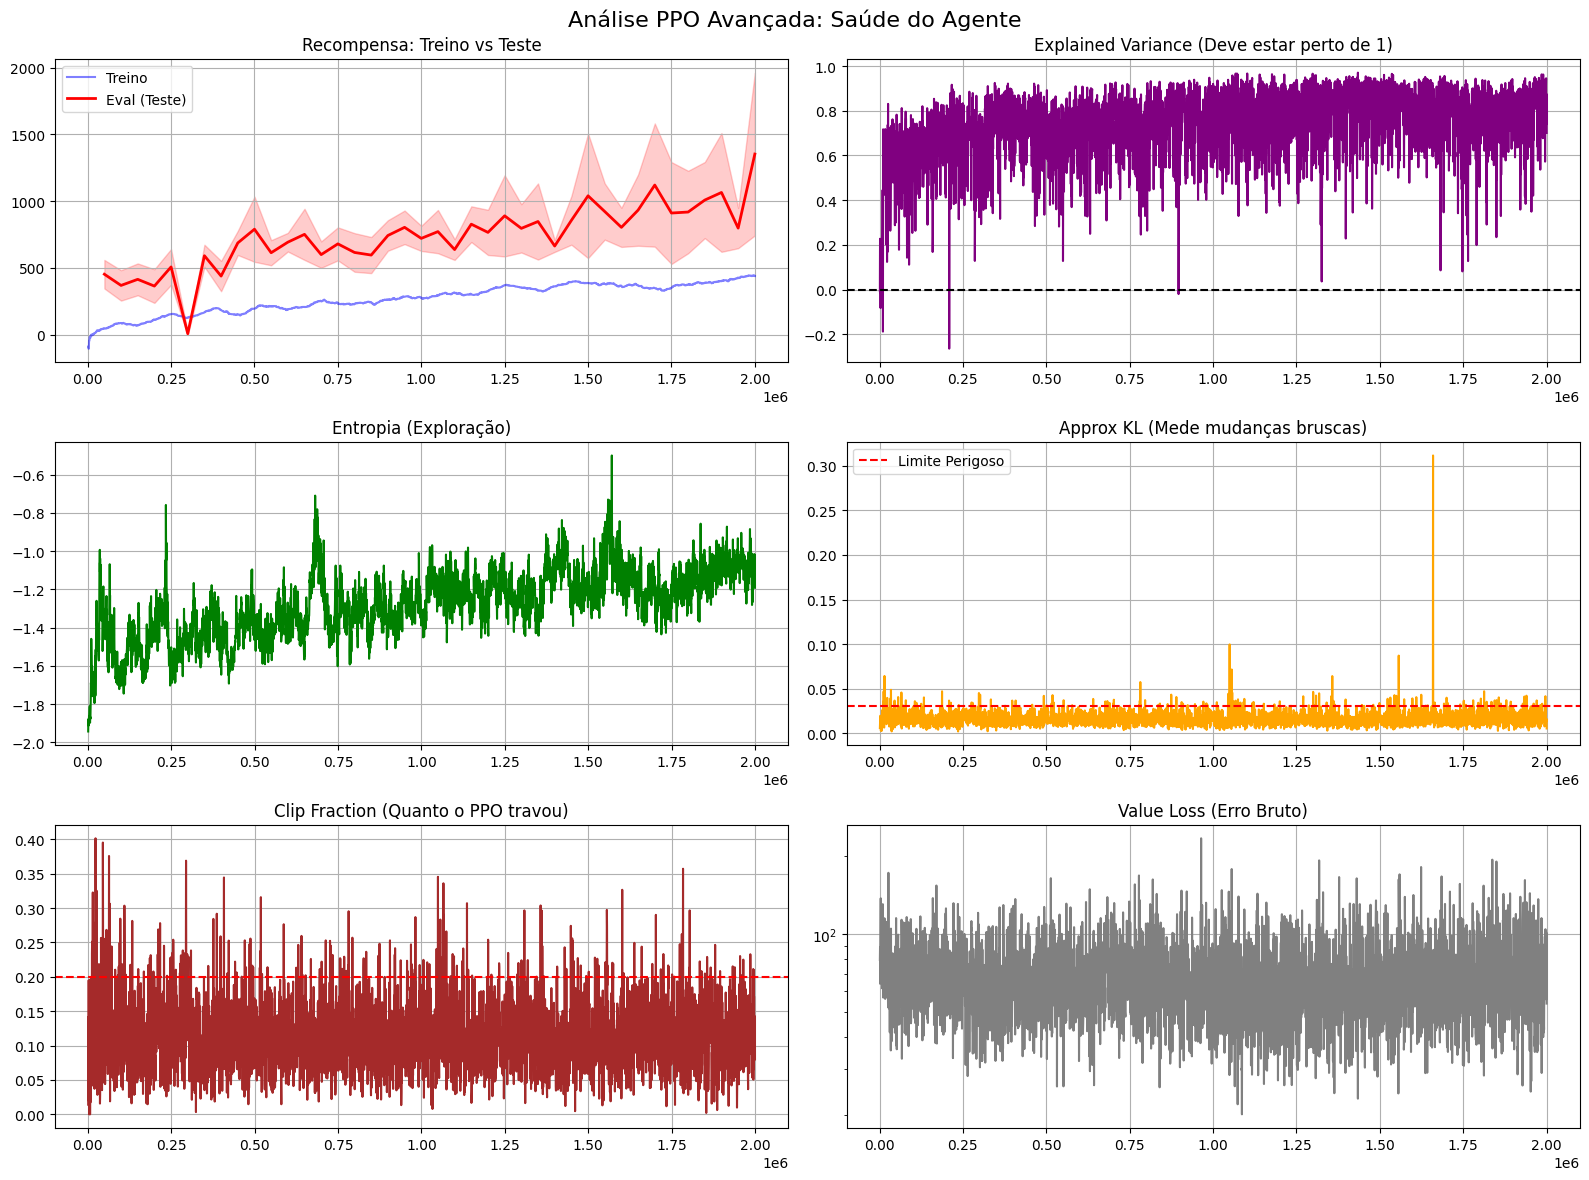


RELATÓRIO DE SAÚDE DO AGENTE (PPO)
Explained Variance Final: 0.7006
Approx KL (Média recente): 0.01775
Clip Fraction (Média recente): 0.1228



In [46]:
EVAL_PATH = "Ambiente_Enemies_Penalty_PPO_v50/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_PPO_v50/PPO_1/events.out.tfevents.1765813100.diogo-Katana-15-B13VEK.9909.0" 

analyze_ppo(EVAL_PATH, LOG_PATH)

In [45]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_PPO_v51/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_PPO_v51/video.mp4",
    frames_to_record=2000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=True
)

A carregar o modelo: Ambiente_Enemies_Penalty_PPO_v51/best_model/best_model.zip


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Enemies_Penalty_PPO_v51/video.mp4 ...
Vídeo guardado em: ./Ambiente_Enemies_Penalty_PPO_v51/video.mp4


### 13.3.4) QR DQN Hiperparameter Tunning

In [ ]:
# 1. Apagar as variáveis pesadas se elas existirem
objetos_para_apagar = ['model', 'vec_env', 'env', 'eval_env']

for obj in objetos_para_apagar:
    if obj in globals():
        del globals()[obj]
        print(f"Variável '{obj}' apagada.")

# 2. Forçar a recolha de lixo (Garbage Collection)
gc.collect()

# 3. Limpar cache da GPU (caso tenhas conseguido pôr o CUDA a funcionar)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cache da GPU limpa.")

print("Memória limpa! Podes tentar criar o modelo agora.")

Cache da GPU limpa.
Memória limpa! Podes tentar criar o modelo agora.


In [ ]:
LOG_DIR = "./Ambiente_Enemies_Penalty_QRDQN_v2"
os.makedirs(LOG_DIR, exist_ok=True)

MODEL_PATH = os.path.join(LOG_DIR, "qrdqn_assault.zip")

In [20]:
N_ENVS = 1

In [ ]:
qrdqn_params = {
    # 1. Taxa de Aprendizagem
    "learning_rate": 1e-4, 

    # 2. Buffer Size (Mantém o máximo que conseguires)
    "buffer_size": 40_000,  

    # 3. Batch Size (Fixo)
    "batch_size": 32,

    # 4. CRÍTICO: Não comeces a treinar até o buffer estar CHEIO
    # Antes tinhas 10k. Agora forçamos a encher a memória toda primeiro.
    "learning_starts": 40_000, 

    # 5. Frequência de Treino
    "train_freq": 4,

    # 6. CRÍTICO: Aumentar a estabilidade do Alvo
    # Antes: 1000. Agora: 4000.
    # Isto impede que a "meta" mude enquanto o agente ainda está a aprender.
    "target_update_interval": 4000,

    # 7. Exploração mais longa
    # Antes: 0.1 (acabava rápido). Agora: 0.25 (explora durante 500k steps).
    # Como o buffer é curto, precisamos de garantir novidade por mais tempo.
    "exploration_fraction": 0.25, 
    "exploration_final_eps": 0.01,

    "optimize_memory_usage": False,
    "total_timesteps": 2_000_000
}

In [ ]:
env_fns = [
        make_callback_train(
                rank = i,
                seed = 42,
                LOG_DIR = LOG_DIR,
                wrapper_class = CustomAssaultWrapperEnemies,
                wrapper_kwargs = dict(
                        noise_level=0,
                        living_penalty=0,
                        shot_penalty=-0.5,
                        death_penalty=-25,
                        enemy_penalty_factor=-0.005)
                )
        for i in range(N_ENVS)
        ]

# Transforma a lista num Ambiente Vetorizado Real
vec_env = DummyVecEnv(env_fns)

# APLICA O FRAME STACK 
vec_env = VecFrameStack(vec_env, n_stack=4)

callback_teste = make_callback_test(LOG_DIR,N_ENVS)

model, reset_timesteps = load_qrdqn(MODEL_PATH, vec_env, qrdqn_params, LOG_DIR)

Nenhum modelo encontrado com o nome: ./Ambiente_Enemies_Penalty_v7/ppo_assault.zip
A criar um novo agente QR-DQN do zero...


In [ ]:
# --- TREINO ---
model.learn(total_timesteps=qrdqn_params["total_timesteps"], progress_bar=True, callback = callback_teste, reset_num_timesteps=reset_timesteps)

# --- GUARDAR ---
model.save(MODEL_PATH)
print("Treino concluído e modelo guardado/atualizado!")

In [ ]:
record_agent_video_mp4(
    model_path="Ambiente_Enemies_Penalty_QRDQN_v2/best_model/best_model.zip",
    video_path="./Ambiente_Enemies_Penalty_QRDQN_v2/video.mp4",
    frames_to_record=5000,
    wrapper_class=AssaultVisualWrapper,
    wrapper_kwargs=None,
    flag=False
)

A carregar o modelo: Ambiente_Enemies_Penalty_v7/best_model/best_model.zip


/home/diogo/anaconda3/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.75GB > 0.95GB
  warnings.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


A gravar vídeo em ./Ambiente_Enemies_Penalty_v7/video3.mp4 ...
Vídeo guardado em: ./Ambiente_Enemies_Penalty_v7/video3.mp4


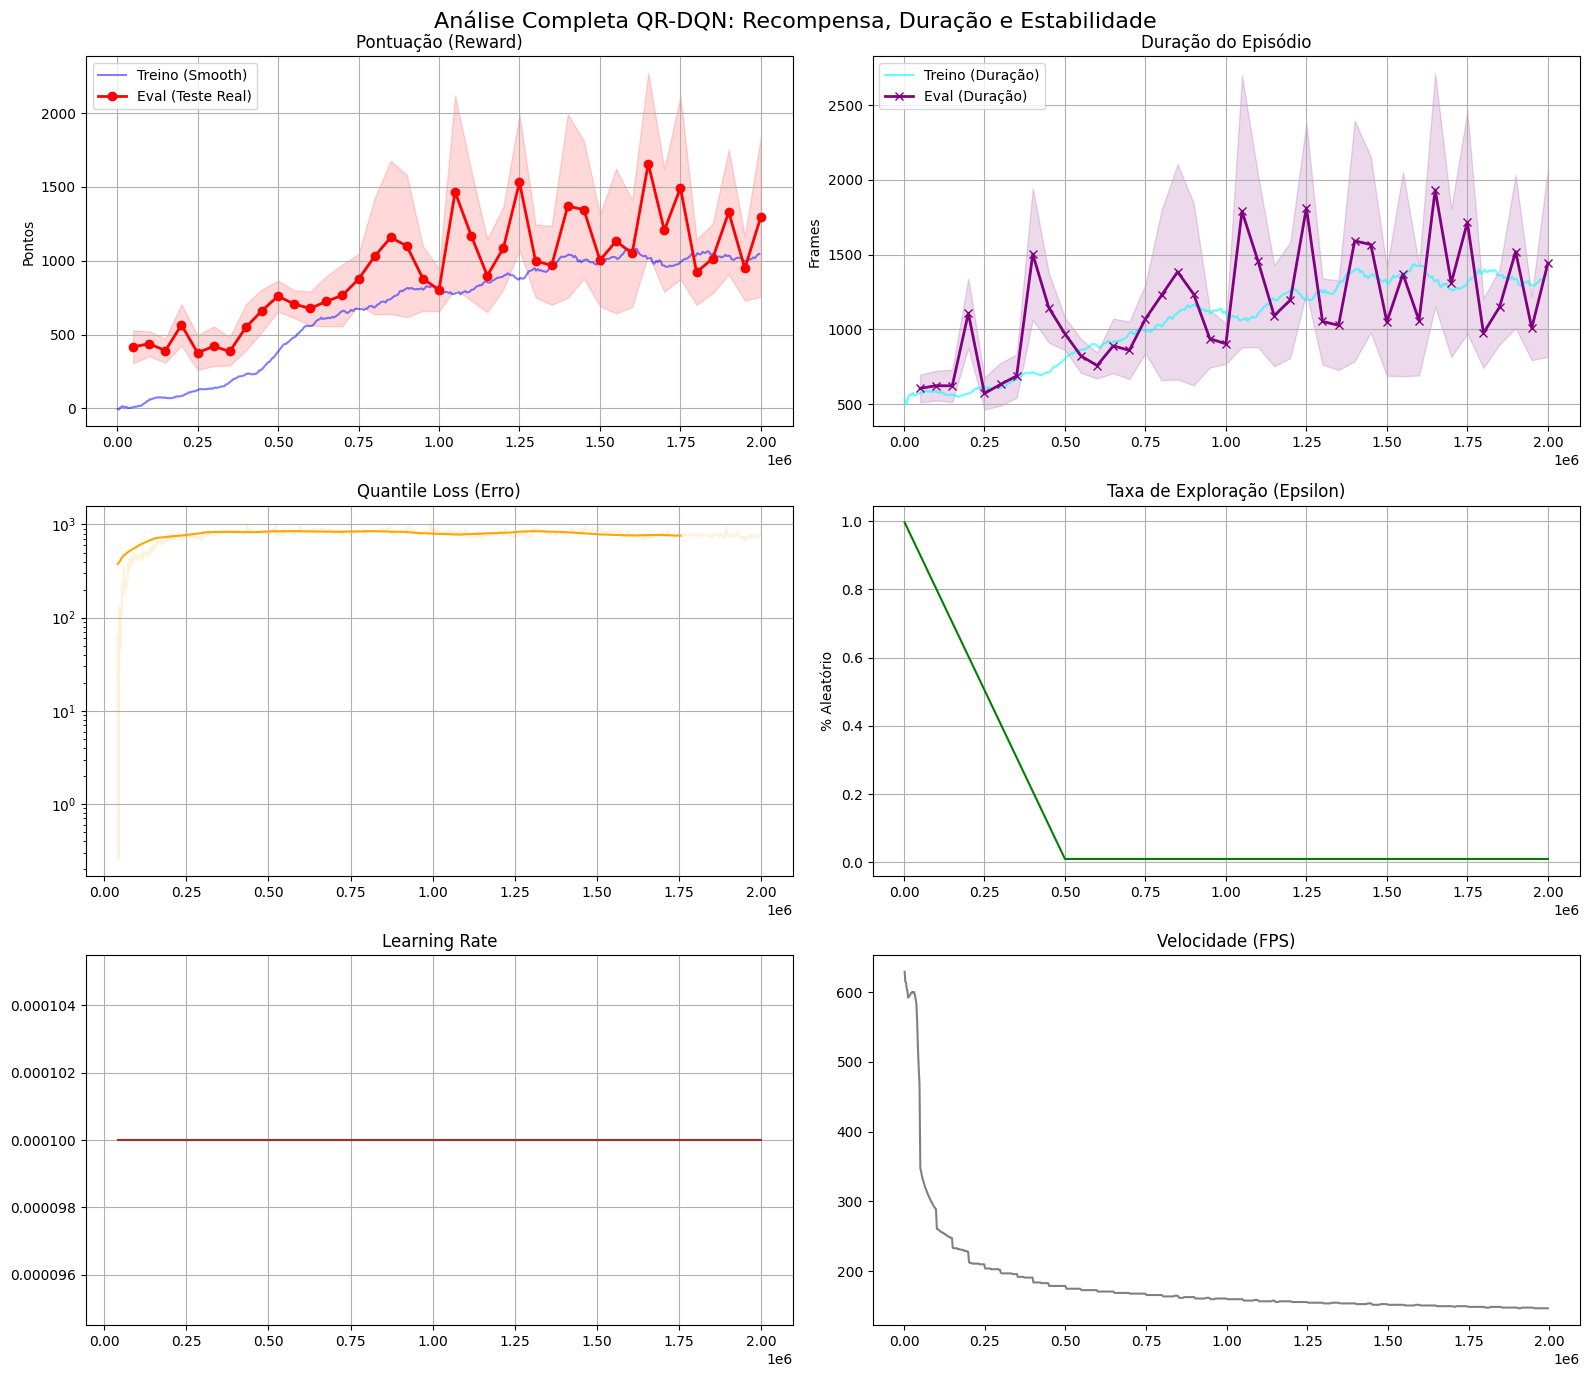


RELATÓRIO DE SAÚDE TÉCNICA (DIAGNÓSTICO AUTOMÁTICO)
1. Exploração Atual: 0.0100
   >>> BOM: O agente está em modo de Performance Pura (Exploração mínima).
       Se a pontuação não subir agora, a estratégia dele é má.

2. Loss (Erro da Rede): Inicial ~537.5531 | Atual ~770.7268
   >>> OK: O Loss parece estável.

3. Evolução (Início -> Fim do Treino):
   Pontuação: 417.2 -> 1299.9 (Var: +882.7)
   Duração:   606.2 -> 1443.0 frames (Var: +836.8)

   >>> CONCLUSÃO: EXCELENTE! O agente vive mais tempo E mata mais inimigos.
       O treino está a funcionar perfeitamente.



In [14]:
EVAL_PATH = "Ambiente_Enemies_Penalty_QRDQN_v2/results/evaluations.npz" 
LOG_PATH = "Ambiente_Enemies_Penalty_QRDQN_v2/QRDQN_1/events.out.tfevents.1765712788.diogo-Katana-15-B13VEK.76316.0"

analyze_qrdqn(EVAL_PATH, LOG_PATH)